<a href="https://colab.research.google.com/github/kenza-ily/24UCL_HospitalReadmissionPred-DiabeticPatients/blob/pipeline/COMP0189_CW1_HVWM7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CW2: Hospital Readmission Prediction for Diabetic Patients


### Imports and setup


In [1481]:
from google.colab import drive
drive.mount('/content/drive')
#As is, setting gpu=True will run the model on the connected GPU. Note, due to the size of the model, this will actually be slower than running in the CPU. See the extended exercise
gpu = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1514]:
# Basics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Extra
import random

# ML
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# DL
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [1483]:
df_raw = pd.read_csv(f"/content/drive/MyDrive/CODE/24UCL/term2/AAI/CW1/data/diabetic_data.csv", encoding="utf-8")

df = df_raw.copy()
df.columns = df.columns.str.upper()

## I. Dataset description (5%)


In [1304]:
df.head().T  # More features than 5 -> transpose gives a better vue


0          1  \
ENCOUNTER_ID                               2278392     149190   
PATIENT_NBR                                8222157   55629189   
RACE                                     Caucasian  Caucasian   
GENDER                                      Female     Female   
AGE                                         [0-10)    [10-20)   
WEIGHT                                           ?          ?   
ADMISSION_TYPE_ID                                6          1   
DISCHARGE_DISPOSITION_ID                        25          1   
ADMISSION_SOURCE_ID                              1          7   
TIME_IN_HOSPITAL                                 1          3   
PAYER_CODE                                       ?          ?   
MEDICAL_SPECIALTY         Pediatrics-Endocrinology          ?   
NUM_LAB_PROCEDURES                              41         59   
NUM_PROCEDURES                                   0          0   
NUM_MEDICATIONS                                  1         18   
NUMBER_OUTPATIENT                                0          0   
NUMBER_EMERGENCY                                 0          0   
NUMBER_INPATIENT                                 0          0   
DIAG_1                                      250.83        276   
DIAG_2                                           ?     250.01   
DIAG_3                                           ?        255   
NUMBER_DIAGNOSES                                 1          9   
MAX_GLU_SERUM                                 None       None   
A1CRESULT                                     None       None   
METFORMIN                                       No         No   
REPAGLINIDE                                     No         No   
NATEGLINIDE                                     No         No   
CHLORPROPAMIDE                                  No         No   
GLIMEPIRIDE                                     No         No   
ACETOHEXAMIDE                                   No         No   
GLIPIZIDE                                       No         No   
GLYBURIDE                                       No         No   
TOLBUTAMIDE                                     No         No   
PIOGLITAZONE                                    No         No   
ROSIGLITAZONE                                   No         No   
ACARBOSE                                        No         No   
MIGLITOL                                        No         No   
TROGLITAZONE                                    No         No   
TOLAZAMIDE                                      No         No   
EXAMIDE                                         No         No   
CITOGLIPTON                                     No         No   
INSULIN                                         No         Up   
GLYBURIDE-METFORMIN                             No         No   
GLIPIZIDE-METFORMIN                             No         No   
GLIMEPIRIDE-PIOGLITAZONE                        No         No   
METFORMIN-ROSIGLITAZONE                         No         No   
METFORMIN-PIOGLITAZONE                          No         No   
CHANGE                                          No         Ch   
DIABETESMED                                     No        Yes   
READMITTED                                      NO        >30   

                                        2          3          4  
ENCOUNTER_ID                        64410     500364      16680  
PATIENT_NBR                      86047875   82442376   42519267  
RACE                      AfricanAmerican  Caucasian  Caucasian  
GENDER                             Female       Male       Male  
AGE                               [20-30)    [30-40)    [40-50)  
WEIGHT                                  ?          ?          ?  
ADMISSION_TYPE_ID                       1          1          1  
DISCHARGE_DISPOSITION_ID                1          1          1  
ADMISSION_SOURCE_ID                     7          7          7  
TIME_IN_HOSPITAL                        2          2          1  
PAYER_C

In [1305]:
print(f"df has {df.shape[1]} features and {df.shape[0]} samples")
print(f"The features are {df.columns}")


df has 50 features and 101766 samples
The features are Index(['ENCOUNTER_ID', 'PATIENT_NBR', 'RACE', 'GENDER', 'AGE', 'WEIGHT',
       'ADMISSION_TYPE_ID', 'DISCHARGE_DISPOSITION_ID', 'ADMISSION_SOURCE_ID',
       'TIME_IN_HOSPITAL', 'PAYER_CODE', 'MEDICAL_SPECIALTY',
       'NUM_LAB_PROCEDURES', 'NUM_PROCEDURES', 'NUM_MEDICATIONS',
       'NUMBER_OUTPATIENT', 'NUMBER_EMERGENCY', 'NUMBER_INPATIENT', 'DIAG_1',
       'DIAG_2', 'DIAG_3', 'NUMBER_DIAGNOSES', 'MAX_GLU_SERUM', 'A1CRESULT',
       'METFORMIN', 'REPAGLINIDE', 'NATEGLINIDE', 'CHLORPROPAMIDE',
       'GLIMEPIRIDE', 'ACETOHEXAMIDE', 'GLIPIZIDE', 'GLYBURIDE', 'TOLBUTAMIDE',
       'PIOGLITAZONE', 'ROSIGLITAZONE', 'ACARBOSE', 'MIGLITOL', 'TROGLITAZONE',
       'TOLAZAMIDE', 'EXAMIDE', 'CITOGLIPTON', 'INSULIN',
       'GLYBURIDE-METFORMIN', 'GLIPIZIDE-METFORMIN',
       'GLIMEPIRIDE-PIOGLITAZONE', 'METFORMIN-ROSIGLITAZONE',
       'METFORMIN-PIOGLITAZONE', 'CHANGE', 'DIABETESMED', 'READMITTED'],
      dtype='object')


In [1306]:
# Single feature analysis -> latest studied
column = df.columns[49]  # set the column from its index

# Basic information
print(column)  # Print the column name
print(df[column].nunique())  # Number of unique values
print(df[column].unique())  # Values of the unique values

# Calculate the percentage of each unique value
value_counts = df[column].value_counts()
percentages = value_counts / len(df) * 100

# Create a new dataframe to store the results
table_data = {
    "Unique Value": value_counts.index,
    "Count": value_counts.values,
    "Percentage": percentages.values,
}
table_df = pd.DataFrame(table_data)

# Sort the dataframe by count in descending order
table_df = table_df.sort_values(by="Count", ascending=False)

table_df


READMITTED
3
['NO' '>30' '<30']


Unique Value  Count  Percentage
0           NO  54864   53.911916
1          >30  35545   34.928169
2          <30  11357   11.159916

In [1307]:
# Replacing all sorts of missing values per NaN
df.replace(
    {"?": np.nan, "nan": np.nan, "Unknown/Invalid": np.nan, "Other": np.nan},
    inplace=True,
)


In [1308]:
# Counting all sorts of missing data
missing_count = df.isnull().sum()
missing_percent = (missing_count / len(df)) * 100
missing_data = pd.DataFrame(
    {"Missing Count": missing_count, "Missing Percentage": missing_percent}
)
missing_data = missing_data[missing_data["Missing Count"] > 0]
# Sort and display
missing_data_sorted = missing_data.sort_values(by="Missing Percentage", ascending=False)
display(missing_data_sorted)


Missing Count  Missing Percentage
WEIGHT                     98569           96.858479
MEDICAL_SPECIALTY          49949           49.082208
PAYER_CODE                 40256           39.557416
RACE                        3779            3.713421
DIAG_3                      1423            1.398306
DIAG_2                       358            0.351787
DIAG_1                        21            0.020636
GENDER                         3            0.002948

In [1309]:
# RACE and GENDER should be the same for each patient: if not, we can't fill the missing values

## Assess if the missing values can be found elsewhere for the same patient
unknown_race_patients = df[df["RACE"].isnull()][["PATIENT_NBR", "RACE"]]
unknown_gender_patients = df[df["GENDER"].isnull()][["PATIENT_NBR", "GENDER"]]

multiple_unknown_race_patients = unknown_race_patients[
    unknown_race_patients.duplicated("PATIENT_NBR", keep=False)
]
multiple_unknown_gender_patients = unknown_gender_patients[
    unknown_gender_patients.duplicated("PATIENT_NBR", keep=False)
]

print(
    f"They are {multiple_unknown_race_patients['RACE'].count()} rows that can be filled with the same RACE value"
)
print(
    f"They are {multiple_unknown_gender_patients['GENDER'].count()} rows that can be filled with the same GENDER value"
)


They are 0 rows that can be filled with the same RACE value
They are 0 rows that can be filled with the same GENDER value


In [1310]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   ENCOUNTER_ID              101766 non-null  int64 
 1   PATIENT_NBR               101766 non-null  int64 
 2   RACE                      97987 non-null   object
 3   GENDER                    101763 non-null  object
 4   AGE                       101766 non-null  object
 5   WEIGHT                    3197 non-null    object
 6   ADMISSION_TYPE_ID         101766 non-null  int64 
 7   DISCHARGE_DISPOSITION_ID  101766 non-null  int64 
 8   ADMISSION_SOURCE_ID       101766 non-null  int64 
 9   TIME_IN_HOSPITAL          101766 non-null  int64 
 10  PAYER_CODE                61510 non-null   object
 11  MEDICAL_SPECIALTY         51817 non-null   object
 12  NUM_LAB_PROCEDURES        101766 non-null  int64 
 13  NUM_PROCEDURES            101766 non-null  int64 
 14  NUM_

In [1311]:
# Number of unique values per feature
for i in list(df.columns):
    print(
        "Number of Unique values in {} :  {} ".format(i, df[i].value_counts().shape[0])
    )


Number of Unique values in ENCOUNTER_ID :  101766 
Number of Unique values in PATIENT_NBR :  71518 
Number of Unique values in RACE :  4 
Number of Unique values in GENDER :  2 
Number of Unique values in AGE :  10 
Number of Unique values in WEIGHT :  9 
Number of Unique values in ADMISSION_TYPE_ID :  8 
Number of Unique values in DISCHARGE_DISPOSITION_ID :  26 
Number of Unique values in ADMISSION_SOURCE_ID :  17 
Number of Unique values in TIME_IN_HOSPITAL :  14 
Number of Unique values in PAYER_CODE :  17 
Number of Unique values in MEDICAL_SPECIALTY :  72 
Number of Unique values in NUM_LAB_PROCEDURES :  118 
Number of Unique values in NUM_PROCEDURES :  7 
Number of Unique values in NUM_MEDICATIONS :  75 
Number of Unique values in NUMBER_OUTPATIENT :  39 
Number of Unique values in NUMBER_EMERGENCY :  33 
Number of Unique values in NUMBER_INPATIENT :  21 
Number of Unique values in DIAG_1 :  716 
Number of Unique values in DIAG_2 :  748 
Number of Unique values in DIAG_3 :  789 


In [1312]:
print(df.dtypes.unique())  # Check the types of the features


[dtype('int64') dtype('O')]


In [1313]:
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
num_cols = [col for col in df.columns if df[col].dtypes == "int64"]

print(f"Number of object columns: {len(cat_cols)}")
print(f"Number of int64 columns: {len(num_cols)}")


Number of object columns: 37
Number of int64 columns: 13


In [1314]:
id_cols = [
    "ENCOUNTER_ID",
    "PATIENT_NBR",  # Side note: Should have been called "PATIENT_ID"
    "DISCHARGE_DISPOSITION_ID",
    "ADMISSION_SOURCE_ID",
    "ADMISSION_TYPE_ID",
]
num_cols = [col for col in num_cols if col not in id_cols]


In [1315]:
empty_coltodrop = []


In [1316]:
# FEATURE SEPARATION

## TARGET
target = "READMITTED"
print(f"The target is {target}")

## FEATURES
features = [col for col in df.columns if col != target]
num_cols = [col for col in num_cols if col != target]

### PRINTING
print("cat_cols:", len(cat_cols), cat_cols)
print("num_cols:", len(num_cols), num_cols)
print("id_columns", len(id_cols), id_cols)


The target is READMITTED
cat_cols: 37 ['RACE', 'GENDER', 'AGE', 'WEIGHT', 'PAYER_CODE', 'MEDICAL_SPECIALTY', 'DIAG_1', 'DIAG_2', 'DIAG_3', 'MAX_GLU_SERUM', 'A1CRESULT', 'METFORMIN', 'REPAGLINIDE', 'NATEGLINIDE', 'CHLORPROPAMIDE', 'GLIMEPIRIDE', 'ACETOHEXAMIDE', 'GLIPIZIDE', 'GLYBURIDE', 'TOLBUTAMIDE', 'PIOGLITAZONE', 'ROSIGLITAZONE', 'ACARBOSE', 'MIGLITOL', 'TROGLITAZONE', 'TOLAZAMIDE', 'EXAMIDE', 'CITOGLIPTON', 'INSULIN', 'GLYBURIDE-METFORMIN', 'GLIPIZIDE-METFORMIN', 'GLIMEPIRIDE-PIOGLITAZONE', 'METFORMIN-ROSIGLITAZONE', 'METFORMIN-PIOGLITAZONE', 'CHANGE', 'DIABETESMED', 'READMITTED']
num_cols: 8 ['TIME_IN_HOSPITAL', 'NUM_LAB_PROCEDURES', 'NUM_PROCEDURES', 'NUM_MEDICATIONS', 'NUMBER_OUTPATIENT', 'NUMBER_EMERGENCY', 'NUMBER_INPATIENT', 'NUMBER_DIAGNOSES']
id_columns 5 ['ENCOUNTER_ID', 'PATIENT_NBR', 'DISCHARGE_DISPOSITION_ID', 'ADMISSION_SOURCE_ID', 'ADMISSION_TYPE_ID']


### 1/ Target encoding


In [1317]:
unique_values = df[target].unique()
print(unique_values)
value_counts = df[target].value_counts()
print(value_counts)


['NO' '>30' '<30']
NO     54864
>30    35545
<30    11357
Name: READMITTED, dtype: int64


In [1318]:
# Target encoding
df["READMITTED"] = df["READMITTED"].apply(lambda x: 0 if x == "NO" else 1)


In [1319]:
unique_values = df["READMITTED"].unique()
print(unique_values)
value_counts = df["READMITTED"].value_counts()
print(value_counts)


[0 1]
0    54864
1    46902
Name: READMITTED, dtype: int64


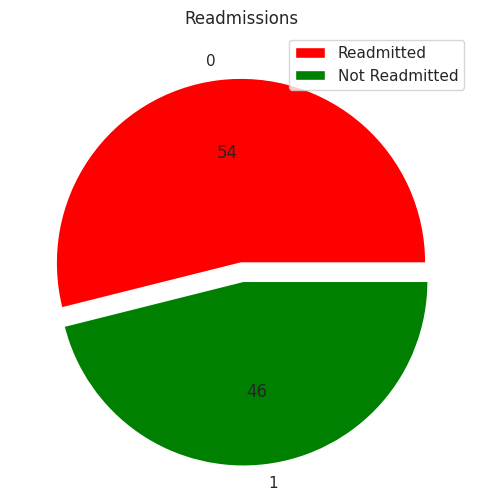

In [1320]:
labels = df[target].unique()
count = df[target].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    count,
    labels=labels,
    autopct="%.0f",
    explode=(0, 0.1),
    colors=["red", "green"],
)
plt.legend(["Readmitted", "Not Readmitted"], loc=1)

plt.title("Readmissions")
plt.show()


The following snippets aim at identifying the meaning behind "READMISSION", raising the following questions:

- To understand the readmission rate, the distribution encompasses patients that came back more than 2 times: in order to clearly map if a patient might be readmitted in a hospital, the important information is to know if he'll come back or not, then to map if he came back or not. An interesting perspective would be to see home many unique patients they are, and assess that a patient that has a second encounter was readmitted, and a patient that didn't have a second encounter was not. This data may be more effective in assessing if the patient was readmitted or not and create the needed regression. Data about how he way treated during his readmission may not be relevant here.
- This dataset follows patients for 10 years. Some patients may have multiple encounters in a decade for different conditions. An option would have been to consider encounters with a readmission of over 30 years as if it was a new patient. This paradigm would consider that a patient coming for a single condition would be readmitted within 30 days, and that readmission is assessed for one condition only.

These hypotheses will be further develop at the end of the coursework.


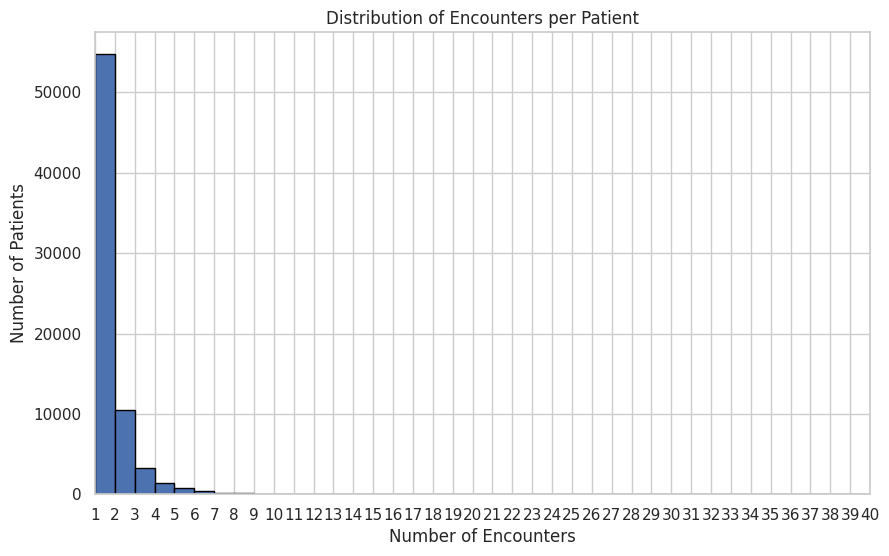

In [1321]:
# Calculate the number of encounters per patient
encounters_per_patient = df.groupby("PATIENT_NBR")["ENCOUNTER_ID"].nunique()

# Plot the distribution
plt.figure(figsize=(10, 6))
encounters_per_patient.hist(
    bins=range(1, encounters_per_patient.max() + 1), edgecolor="black"
)
plt.title("Distribution of Encounters per Patient")
plt.xlabel("Number of Encounters")
plt.ylabel("Number of Patients")
plt.xticks(range(1, encounters_per_patient.max() + 1))
plt.xlim(1, encounters_per_patient.max())
plt.show()


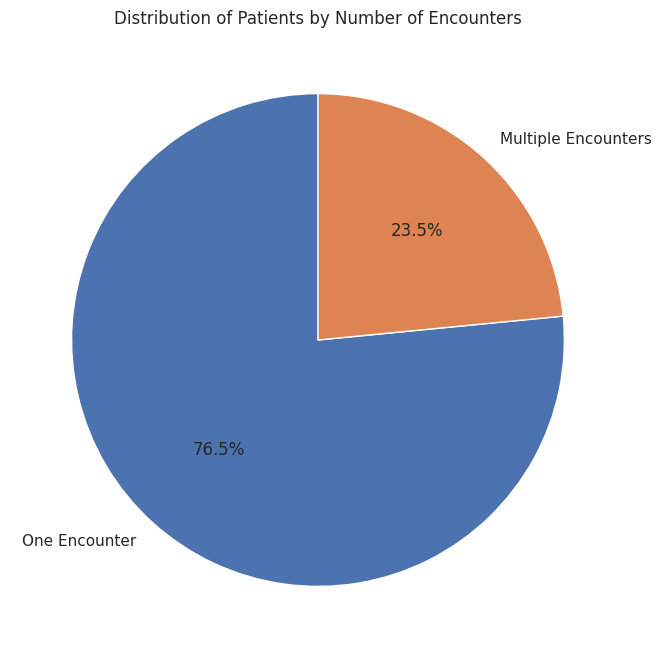

In [1322]:
# Understanding the representation of patients that came multiple times
## Creating a binary df
encounters_per_patient_binary = encounters_per_patient.map(lambda x: 0 if x == 1 else 1)

## Count occurrences of 0 and 1 in encounters_per_patient_binary
counts = encounters_per_patient_binary.value_counts()

## Plot the pie chart
plt.figure(figsize=(8, 8))
counts.plot(
    kind="pie",
    labels=["One Encounter", "Multiple Encounters"],
    autopct="%1.1f%%",
    startangle=90,
)
plt.title("Distribution of Patients by Number of Encounters")
plt.ylabel("")  # Remove y-axis label for clarity
plt.show()


This information tells us that in practise, 23% of the patients had multiple encounters - hence were readmitted, which is not the number of readmission that is a little bit over 45%.
The aim is "to predict which patients will need hospital readmission."
Here the definition of "readmission" can be tricky: Is it based on the first encounter? Or, on each encounter, to predict if he may come back?


In [1323]:
# Quick random data visualisation for encounters and readmission

# Ensure 'PATIENT_NBR' column is present
if "PATIENT_NBR" in df.columns:
    # Randomly select a PATIENT_NBR from the DataFrame
    index = random.choice(df["PATIENT_NBR"].unique())
else:
    print("PATIENT_NBR column not found in DataFrame")

# Sorting df by 'ENCOUNTER_ID'
df_sorted = df.sort_values(by="ENCOUNTER_ID")

# Display the first few rows for the randomly selected PATIENT_NBR
df_sorted.loc[df_sorted["PATIENT_NBR"] == index][["ENCOUNTER_ID", "READMITTED"]].head()


ENCOUNTER_ID  READMITTED
8096      37210968           0

In [1324]:
# Group by 'PATIENT_NBR' and find the index of the minimum 'ENCOUNTER_ID' for each group
df_simplified = df_raw.copy()
df_simplified.columns = df_simplified.columns.str.upper()


In [1325]:
df_simplified.shape


(101766, 50)

In [1326]:
df_simplified["READMITTED"] = df_simplified["READMITTED"].map(
    {"NO": 0, "<30": 1, ">30": 0}
)


In [1327]:
print(df_simplified["READMITTED"].unique())
print(df_simplified["READMITTED"].value_counts())


[0 1]
0    90409
1    11357
Name: READMITTED, dtype: int64


In [1328]:
# Keep only the encounter_id with the lower number
df_simplified = df_simplified.sort_values("ENCOUNTER_ID").drop_duplicates(
    "PATIENT_NBR", keep="first"
)
df_simplified.shape


(71518, 50)

In [1329]:
df_simplified.head()


ENCOUNTER_ID  PATIENT_NBR             RACE  GENDER       AGE WEIGHT  \
8          12522     48330783        Caucasian  Female   [80-90)      ?   
9          15738     63555939        Caucasian  Female  [90-100)      ?   
4          16680     42519267        Caucasian    Male   [40-50)      ?   
10         28236     89869032  AfricanAmerican  Female   [40-50)      ?   
5          35754     82637451        Caucasian    Male   [50-60)      ?   

    ADMISSION_TYPE_ID  DISCHARGE_DISPOSITION_ID  ADMISSION_SOURCE_ID  \
8                   2                         1                    4   
9                   3                         3                    4   
4                   1                         1                    7   
10                  1                         1                    7   
5                   2                         1                    2   

    TIME_IN_HOSPITAL  ... CITOGLIPTON INSULIN  GLYBURIDE-METFORMIN  \
8                 13  ...          No  Steady                   No   
9                 12  ...          No  Steady                   No   
4                  1  ...          No  Steady                   No   
10                 9  ...          No  Steady                   No   
5                  3  ...          No  Steady                   No   

    GLIPIZIDE-METFORMIN  GLIMEPIRIDE-PIOGLITAZONE  METFORMIN-ROSIGLITAZONE  \
8                    No                        No                       No   
9                    No                        No                       No   
4                    No                        No                       No   
10                   No                        No                       No   
5                    No                        No                       No   

    METFORMIN-PIOGLITAZONE  CHANGE DIABETESMED READMITTED  
8                       No      Ch         Yes          0  
9                       No      Ch         Yes          0  
4                       No      Ch         Yes          0  
10                      No      No         Yes          0  
5                       No      No         Yes          0  

[5 rows x 50 columns]

### 1/ Numerical columns


In [1330]:
df_num = df[num_cols]


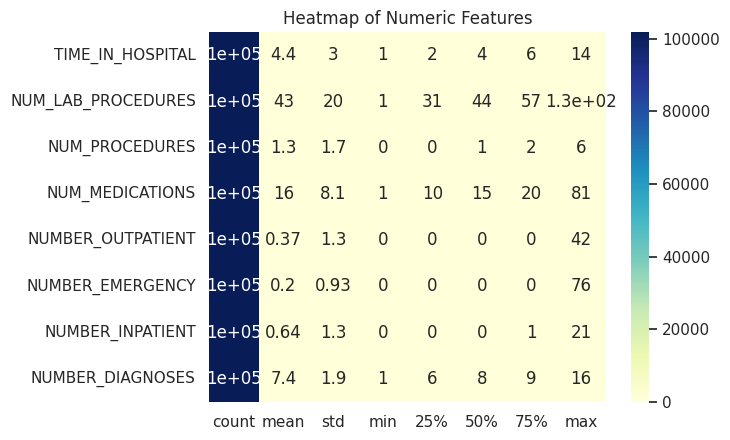

In [1331]:
sns.heatmap(df_num.describe().T, annot=True, cmap="YlGnBu")
plt.title("Heatmap of Numeric Features")
plt.show()


<ipython-input-1332-c0f17460882f>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_num.hist(bins=20, ax=ax[0])


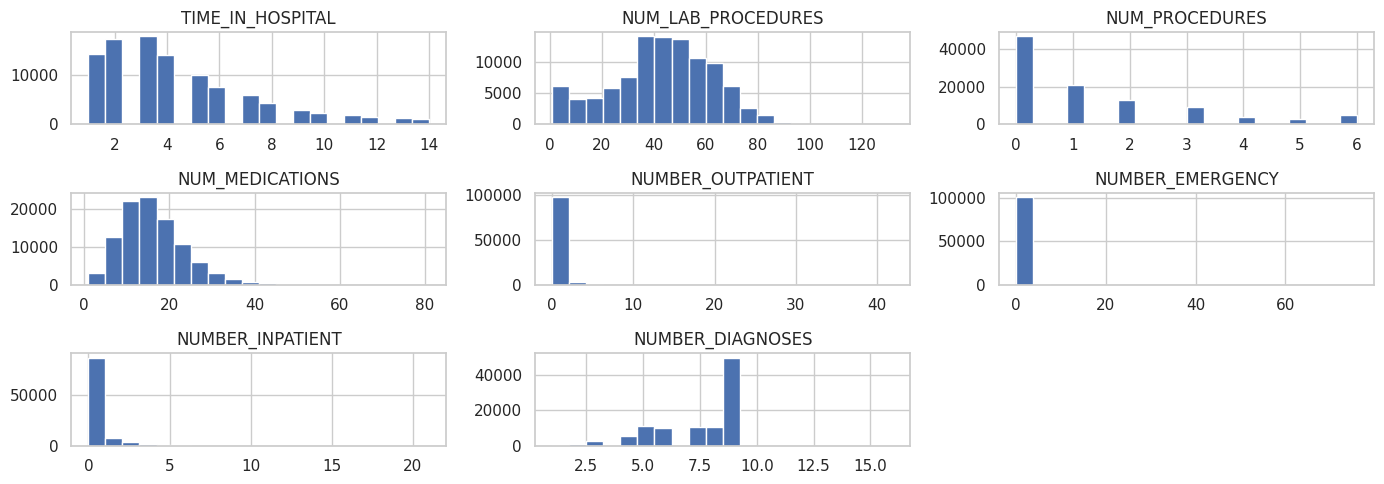

In [1332]:
# Normal histograms for all numerical values

fig, ax = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns for two subplots
df_num.hist(bins=20, ax=ax[0])
ax[0].set_xlabel(num_cols)
ax[0].set_title(num_cols)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


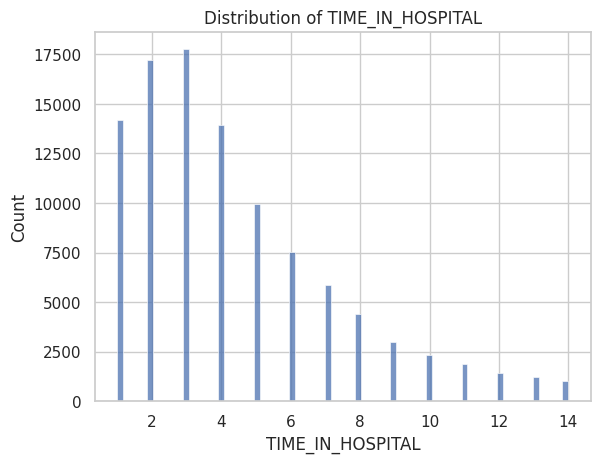

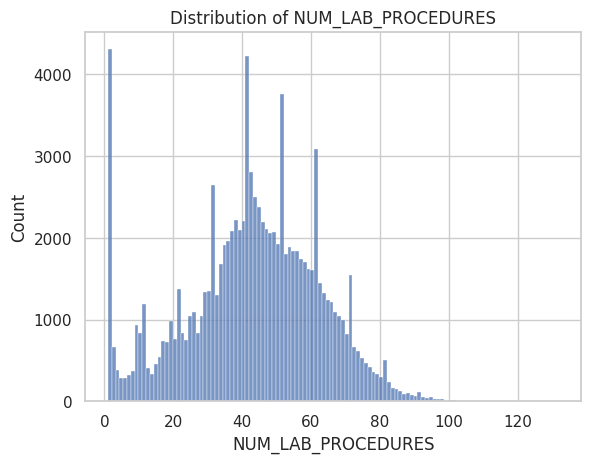

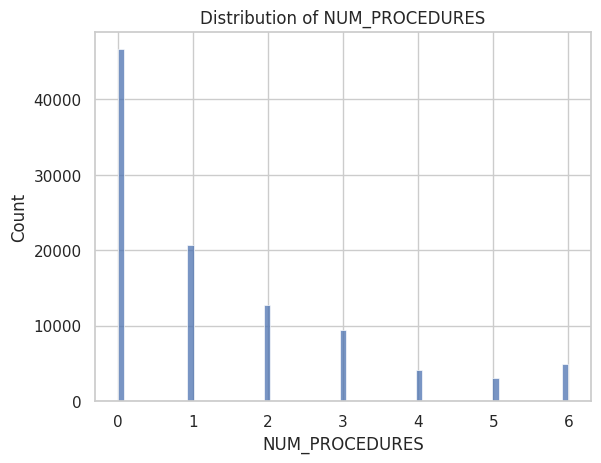

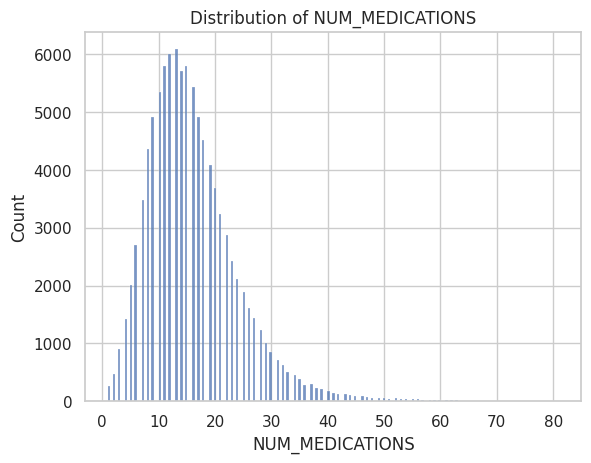

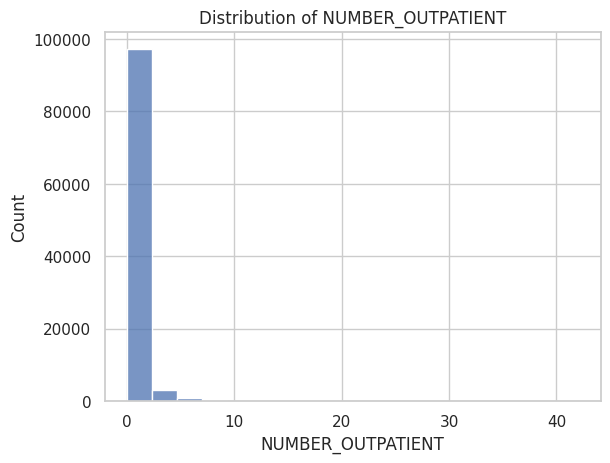

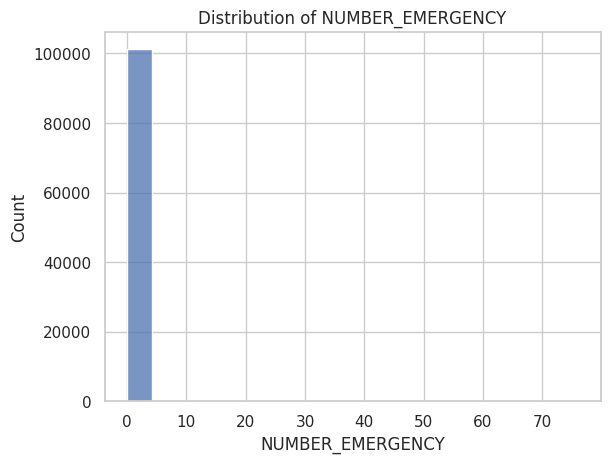

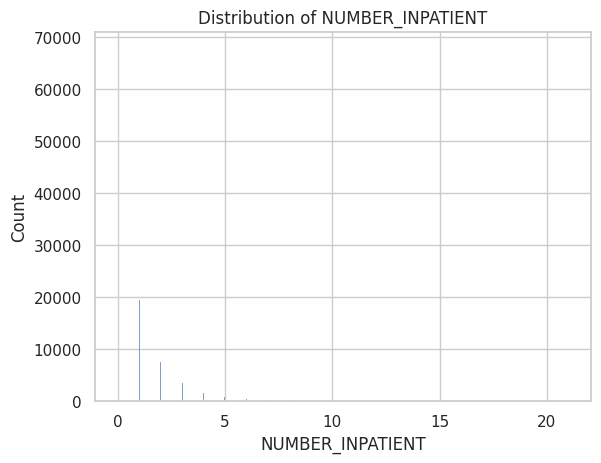

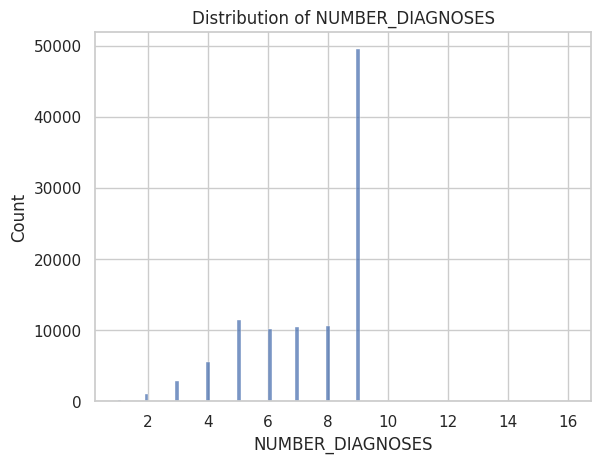

In [1333]:
# Normal histograms for all numerical values
for col in num_cols:
    sns.histplot(df[col])
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title(f"Distribution of {col}")
    plt.show()


<ipython-input-1334-f3f51d1d4f80>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="READMITTED", data=df, ax=axes[1], palette="Set2")


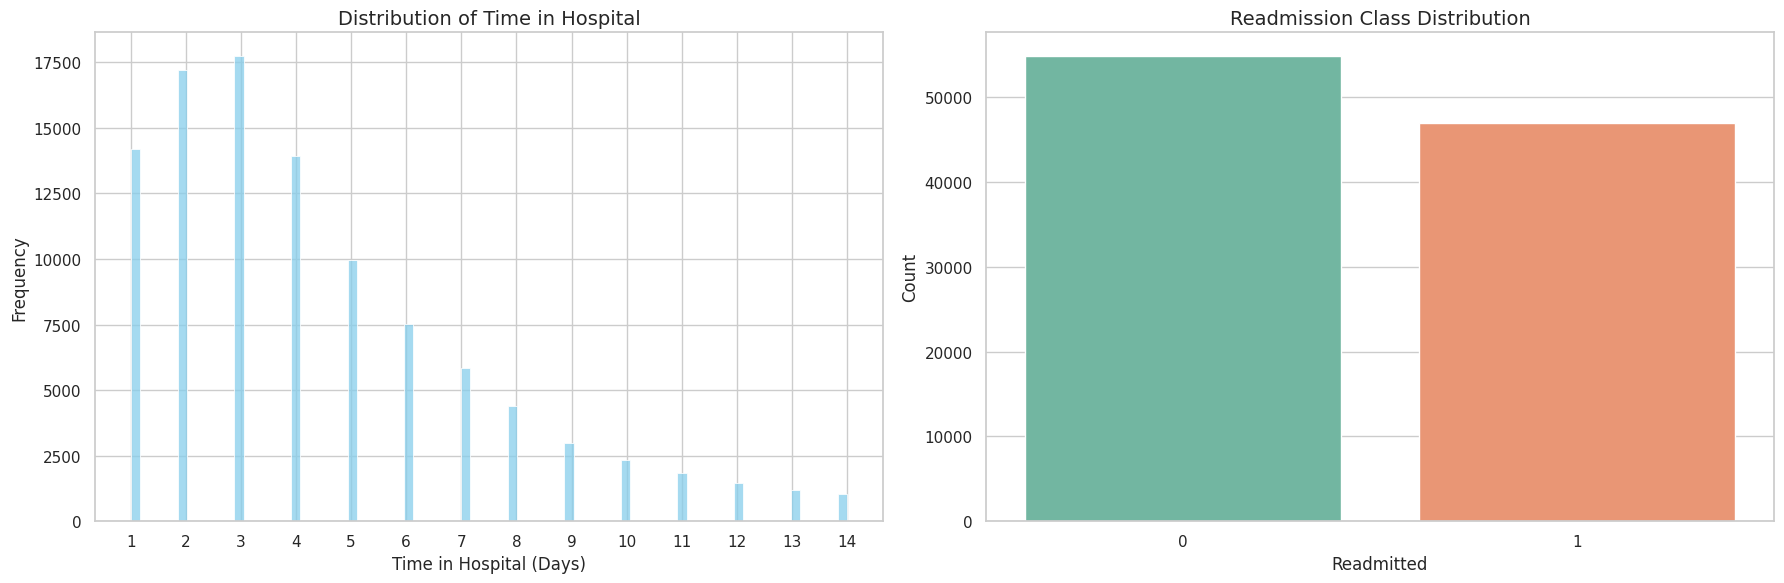

In [1334]:
# Set the style of seaborn
sns.set_style("whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histogram for a numerical feature - 'TIME_IN_HOSPITAL' as an example
sns.histplot(df["TIME_IN_HOSPITAL"], ax=axes[0], color="skyblue")
axes[0].set_title("Distribution of Time in Hospital", fontsize=14)
axes[0].set_xlabel("Time in Hospital (Days)", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

# Set x-axis tick labels for the histogram
axes[0].set_xticks(df["TIME_IN_HOSPITAL"].unique())

# Bar plot for class distribution in 'READMITTED'
sns.countplot(x="READMITTED", data=df, ax=axes[1], palette="Set2")
axes[1].set_title("Readmission Class Distribution", fontsize=14)
axes[1].set_xlabel("Readmitted", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)

plt.tight_layout()
plt.show()


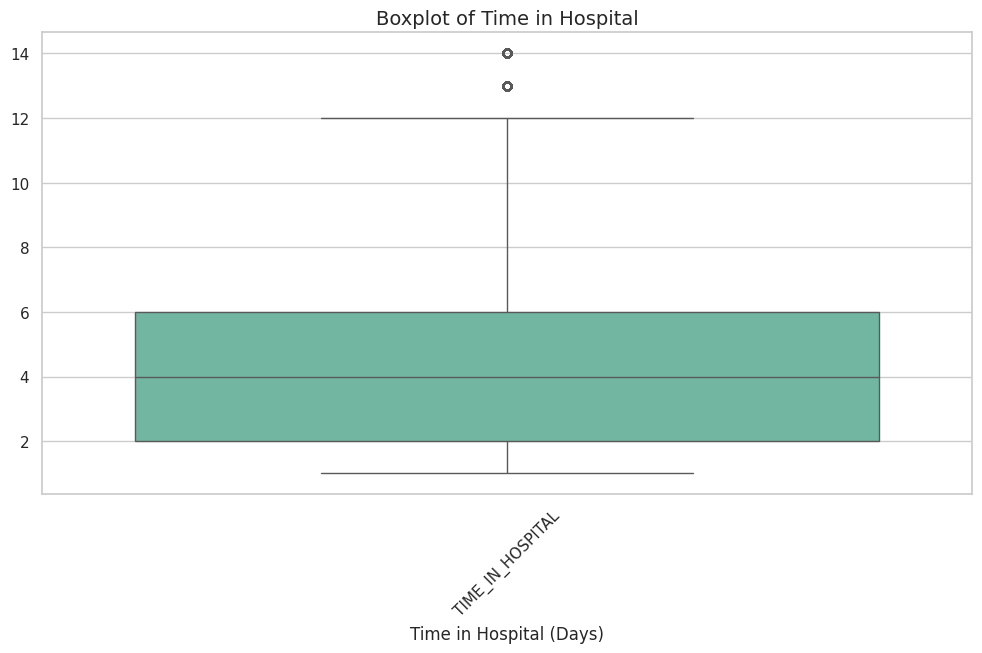

In [1335]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[["TIME_IN_HOSPITAL"]], palette="Set2")
plt.title("Boxplot of Time in Hospital", fontsize=14)
plt.xlabel("Time in Hospital (Days)", fontsize=12)
plt.xticks(rotation=45)
plt.show()


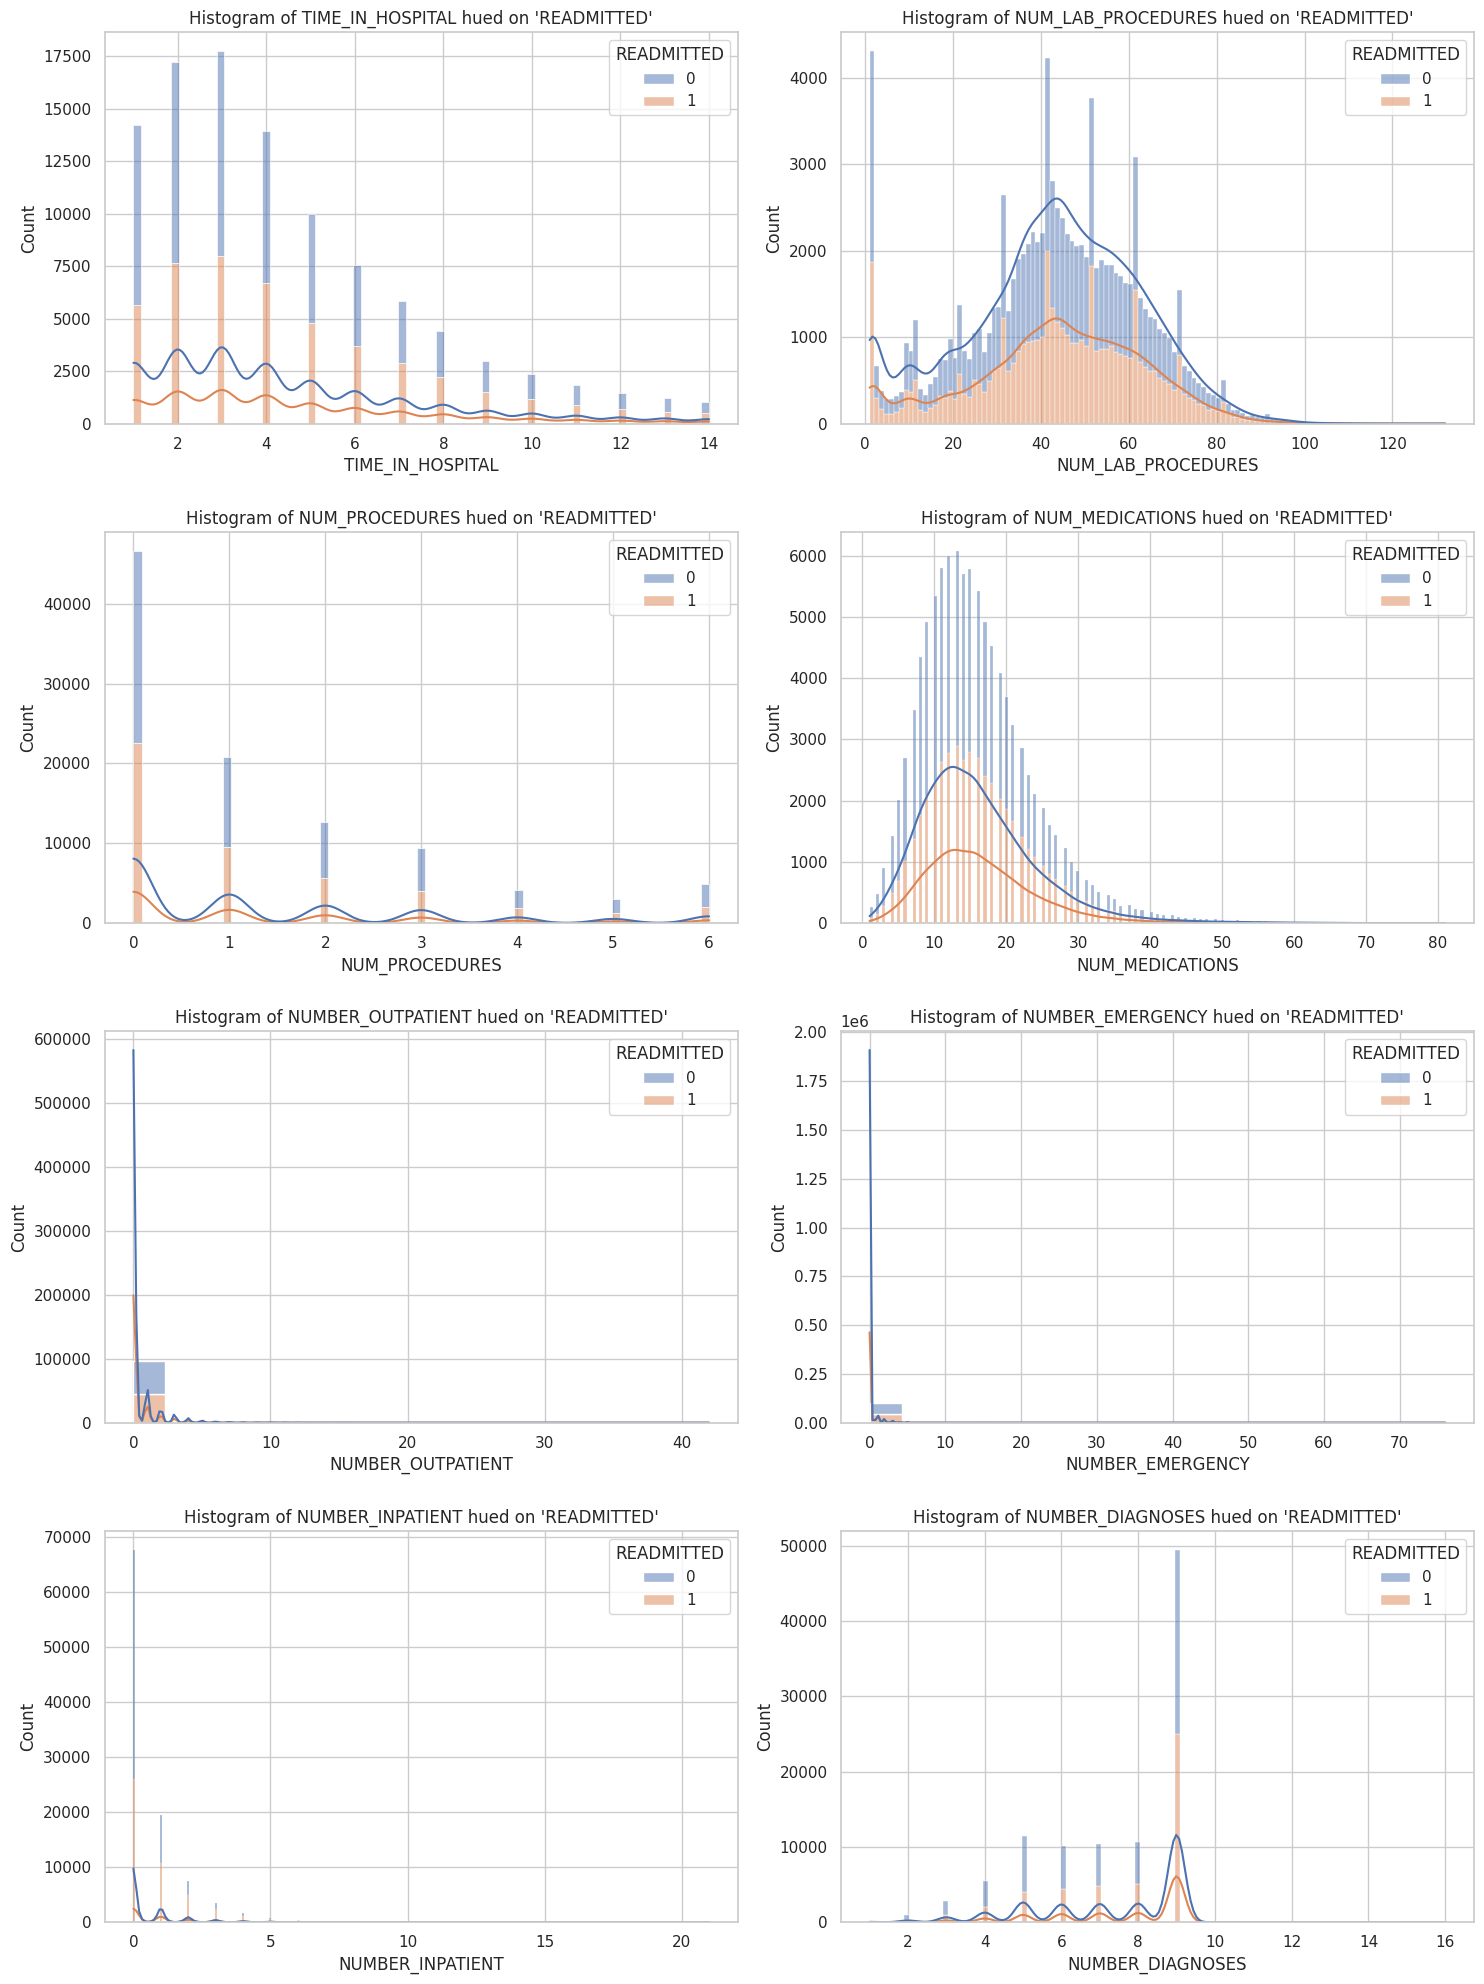

In [1336]:
# Hued histogram

fig, axes = plt.subplots(
    len(num_cols) // 2 + len(num_cols) % 2,
    2,
    figsize=(15, 5 * (len(num_cols) // 2 + len(num_cols) % 2)),
)

# Iterate over each numerical column and plot the histogram hued on "READMITTED"
for i, num_col in enumerate(
    num_cols
):  # Corrected variable name from 'col' to 'num_col'
    row = i // 2
    col_idx = i % 2  # Corrected variable name from 'col' to 'col_idx'
    sns.histplot(
        data=df,
        x=num_col,
        hue="READMITTED",
        ax=axes[row, col_idx],
        multiple="stack",
        kde=True,
    )

    # Set the title and labels for each subplot
    axes[row, col_idx].set_title(f"Histogram of {num_col} hued on 'READMITTED'")
    axes[row, col_idx].set_xlabel(num_col)
    axes[row, col_idx].set_ylabel("Count")

# If the number of numerical columns is odd, remove the last subplot (which is empty)
if len(num_cols) % 2 != 0:
    fig.delaxes(axes[-1, -1])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


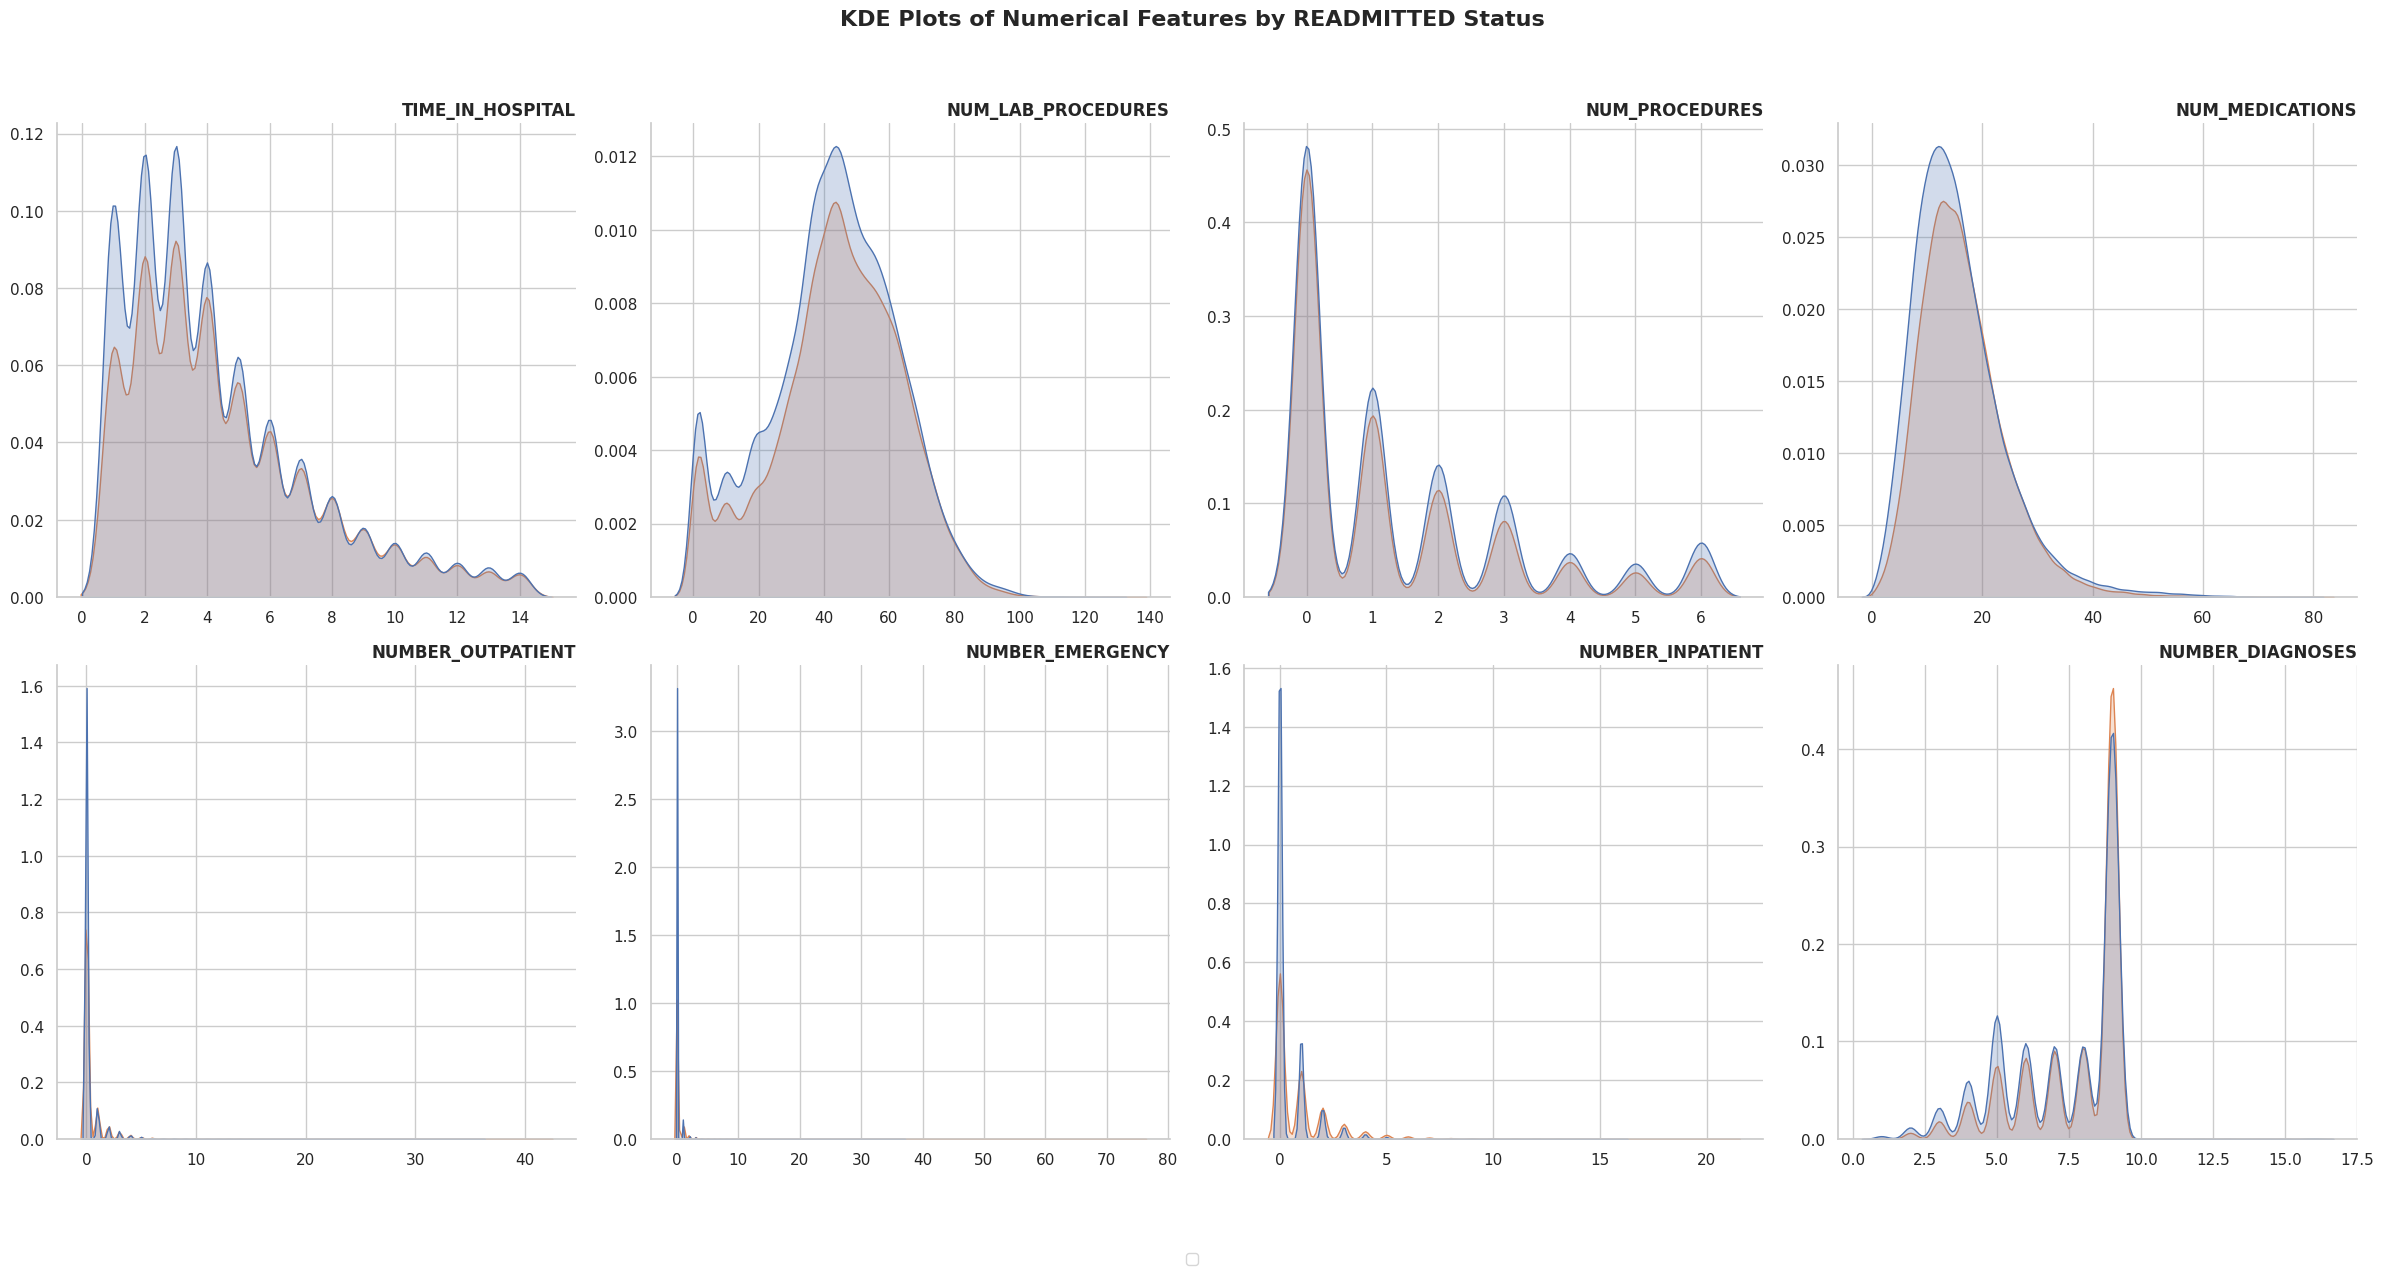

In [1337]:
# KDE Plot - Target hued

# Determine the layout of the subplots based on the number of numerical columns
num_features = len(num_cols)
num_columns = 4  # Number of columns in the subplot grid
num_rows = num_features // num_columns + (num_features % num_columns > 0)
figsize = (
    6 * num_columns,
    6 * num_rows,
)  # Adjusted figsize based on the number of subplots
fig = plt.figure(figsize=figsize)

for idx, col in enumerate(num_cols):
    ax = plt.subplot(num_rows, num_columns, idx + 1)
    sns.kdeplot(data=df, x=col, hue="READMITTED", fill=True, legend=False, ax=ax)

    # Improve subplot aesthetics
    ax.set_ylabel("")
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("")
    ax.spines["right"].set_visible(False)
    ax.set_title(f"{col}", loc="right", weight="bold", fontsize=12)

# Adjust the layout and add a title
plt.subplots_adjust(top=0.92)  # Adjust top spacing to fit the suptitle
fig.suptitle(
    "KDE Plots of Numerical Features by READMITTED Status",
    ha="center",
    fontweight="bold",
    fontsize=16,
)

# Add a legend for hue colors
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)

plt.tight_layout(
    rect=[0, 0, 1, 0.95]
)  # Adjust the rect parameter to make space for the title and legend
plt.show()


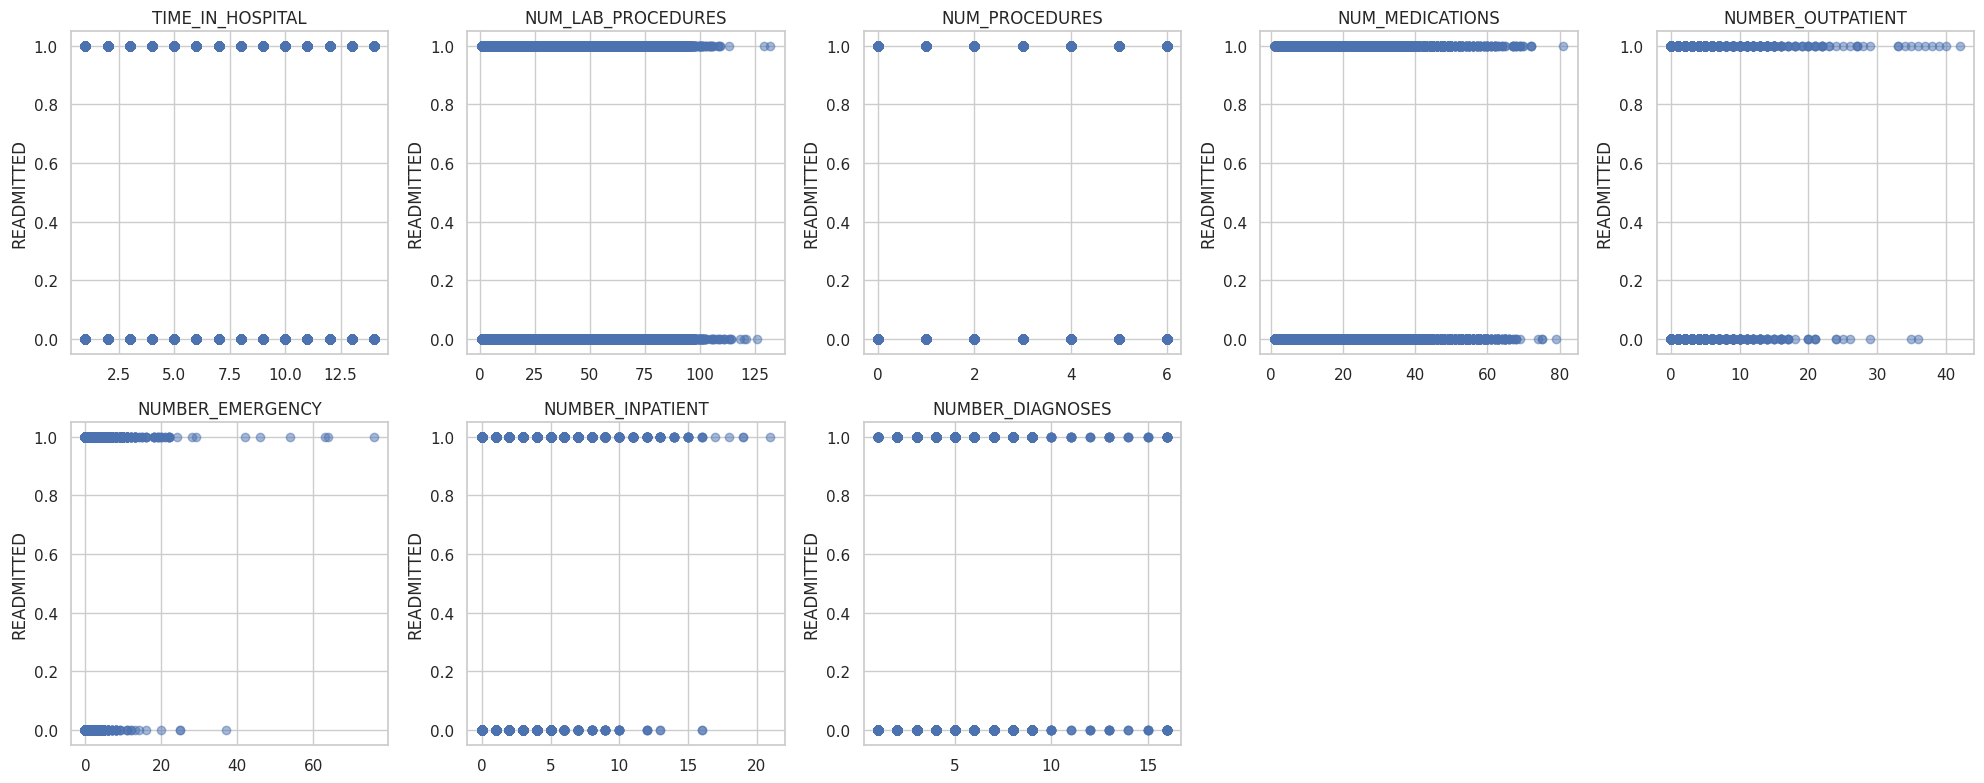

In [1338]:
# Scatter plot

# Display settings
n_cols = 5  # Number of subplot columns (you can adjust this based on your preference)
n_rows = int(np.ceil(len(df_num.columns) / n_cols))


fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(20, 4 * n_rows)
)  # Adjust the subplot grid and figure size

# Target setting
y = df["READMITTED"]

# Flatten the axes array for easy iteration if there's more than one row
if n_rows > 1:
    axes = axes.ravel()
else:
    axes = [axes]  # Ensure axes is iterable even with a single subplot

for i, ax in enumerate(axes):
    if i < len(
        df_num.columns
    ):  # Check if the current index is within the range of numerical columns
        # Plotting each numerical feature against the target variable
        ax.plot(df_num.iloc[:, i], y, "o", alpha=0.5)
        ax.set_title(f"{df_num.columns[i]}")
        ax.set_ylabel("READMITTED")
    else:
        ax.set_visible(False)  # Hide any excess axes

plt.tight_layout()  # Adjust the layout
plt.show()  # Display the plot


In [1339]:
# # Pairplot
# # ! DO NOT RERUN -> Takes a long time
# sns.set(style="ticks")
# sns.set_context("talk")
# pairplot = sns.pairplot(data=df, hue="READMITTED", markers=["o", "s"])
# plt.subplots_adjust(top=1)
# pairplot.fig.suptitle(
#     "Pairplot of Numerical Variables by Readmission", fontsize=18, y=1
# )
# plt.tight_layout()
# plt.show()


### 2/ Categorical columns


In [1340]:
print(cat_cols)


['RACE', 'GENDER', 'AGE', 'WEIGHT', 'PAYER_CODE', 'MEDICAL_SPECIALTY', 'DIAG_1', 'DIAG_2', 'DIAG_3', 'MAX_GLU_SERUM', 'A1CRESULT', 'METFORMIN', 'REPAGLINIDE', 'NATEGLINIDE', 'CHLORPROPAMIDE', 'GLIMEPIRIDE', 'ACETOHEXAMIDE', 'GLIPIZIDE', 'GLYBURIDE', 'TOLBUTAMIDE', 'PIOGLITAZONE', 'ROSIGLITAZONE', 'ACARBOSE', 'MIGLITOL', 'TROGLITAZONE', 'TOLAZAMIDE', 'EXAMIDE', 'CITOGLIPTON', 'INSULIN', 'GLYBURIDE-METFORMIN', 'GLIPIZIDE-METFORMIN', 'GLIMEPIRIDE-PIOGLITAZONE', 'METFORMIN-ROSIGLITAZONE', 'METFORMIN-PIOGLITAZONE', 'CHANGE', 'DIABETESMED', 'READMITTED']


#### a. Medications


In [1341]:
# Splitting categorical features into medication and non-medication, as cat_med have the same output values
cat_med = [
    "ACARBOSE",
    "ACETOHEXAMIDE",
    "CHLORPROPAMIDE",
    "GLIMEPIRIDE",
    "GLIMEPIRIDE-PIOGLITAZONE",
    "GLIPIZIDE",
    "GLIPIZIDE-METFORMIN",
    "GLYBURIDE",
    "GLYBURIDE-METFORMIN",
    "INSULIN",
    "METFORMIN",
    "METFORMIN-PIOGLITAZONE",
    "METFORMIN-ROSIGLITAZONE",
    "MIGLITOL",
    "NATEGLINIDE",
    "PIOGLITAZONE",
    "REPAGLINIDE",
    "ROSIGLITAZONE",
    "TOLAZAMIDE",
    "TOLBUTAMIDE",
    "TROGLITAZONE",
]
cat_nonmed = [col for col in cat_cols if col not in cat_med]


In [1342]:
len(cat_med)


21

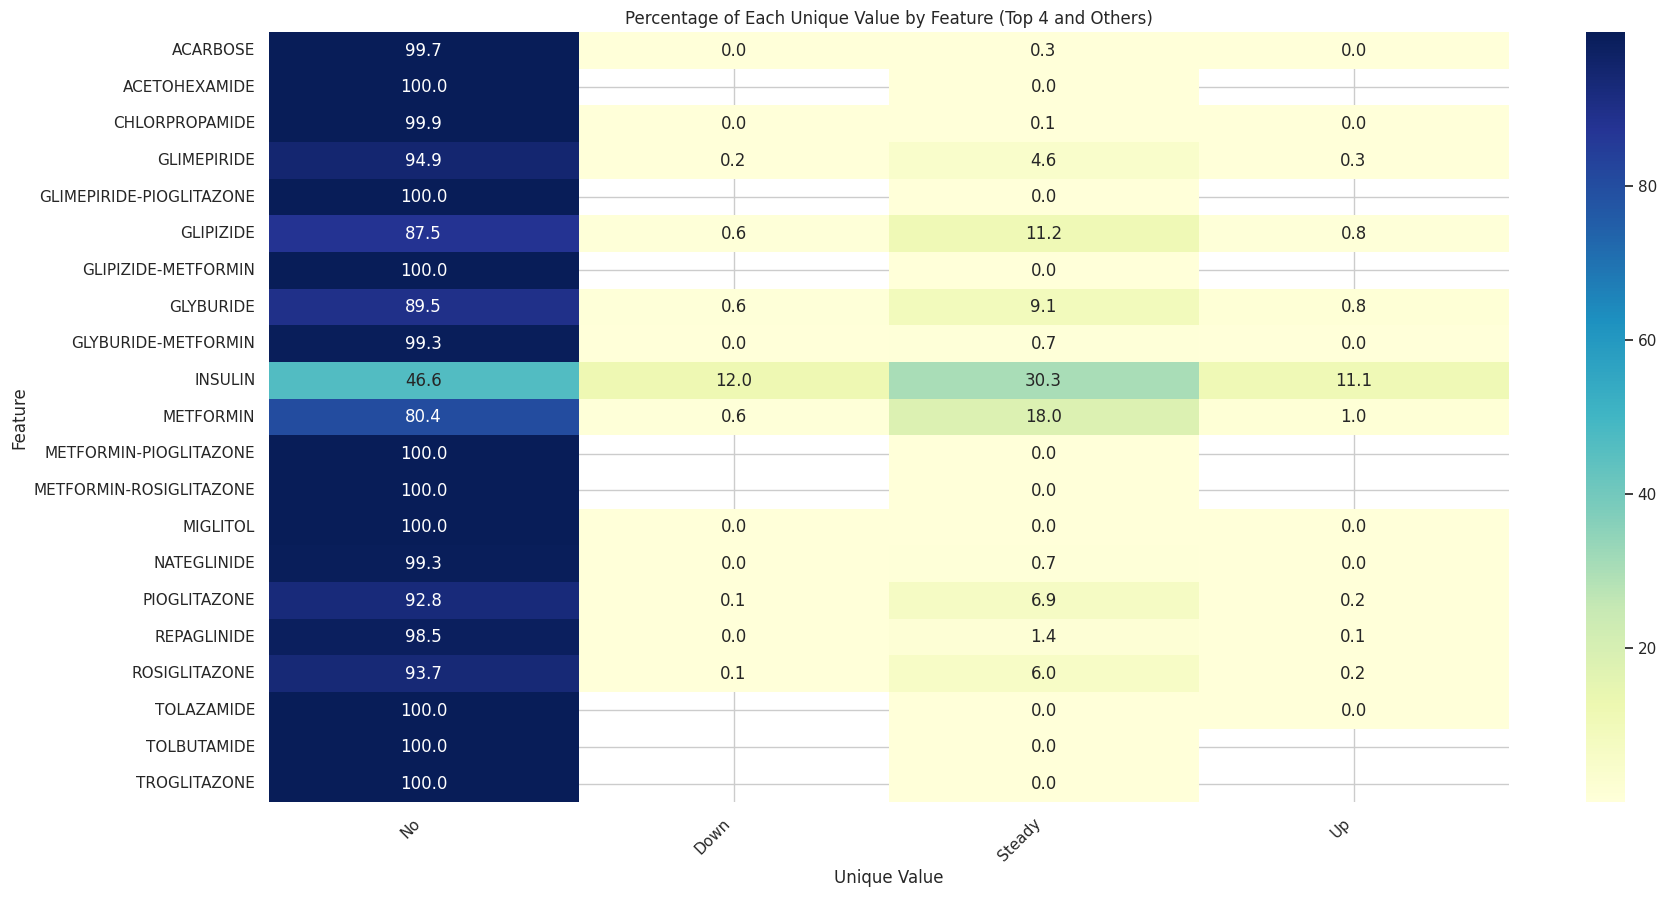

In [1343]:
# Medication heatmap data
heatmap_data = pd.DataFrame()

for col in cat_med:
    value_counts = df[col].value_counts()
    if len(value_counts) > 5:  # If more than 5 unique values
        # Take top 4 and create a Series for 'Other'
        top_values = value_counts.iloc[:4]
        other_sum = pd.Series(
            [value_counts.iloc[4:].sum()], index=["Other"]
        )  # Corrected to ensure 'Other' is a Series

        # Combine top values with 'Other' using concat
        new_values = pd.concat([top_values, other_sum])
        percentages = new_values / len(df) * 100
    else:
        percentages = value_counts / len(df) * 100

    # Create a temporary DataFrame to store the data for the current column
    temp_df = pd.DataFrame(
        {
            "Feature": col,
            "Unique Value": percentages.index,
            "Percentage": percentages.values,
        }
    )

    # Append the temporary DataFrame to the main heatmap_data DataFrame
    heatmap_data = pd.concat([heatmap_data, temp_df], ignore_index=True)

# Pivot the DataFrame to get a matrix suitable for a heatmap
pivot_table = heatmap_data.pivot(
    index="Feature", columns="Unique Value", values="Percentage"
)  # Corrected pivot call

# Reorder the x values
order = ["No", "Down", "Steady", "Up"]
pivot_table = pivot_table.reindex(columns=order)

# Plotting the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Percentage of Each Unique Value by Feature (Top 4 and Others)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()


In [1344]:
cat_med_todrop = [
    feature
    for feature in cat_med
    if df[feature].value_counts(normalize=True).max() > 0.95
]
print(cat_med_todrop)


['ACARBOSE', 'ACETOHEXAMIDE', 'CHLORPROPAMIDE', 'GLIMEPIRIDE-PIOGLITAZONE', 'GLIPIZIDE-METFORMIN', 'GLYBURIDE-METFORMIN', 'METFORMIN-PIOGLITAZONE', 'METFORMIN-ROSIGLITAZONE', 'MIGLITOL', 'NATEGLINIDE', 'REPAGLINIDE', 'TOLAZAMIDE', 'TOLBUTAMIDE', 'TROGLITAZONE']


#### b. Non-medications


In [1345]:
print(cat_nonmed)


['RACE', 'GENDER', 'AGE', 'WEIGHT', 'PAYER_CODE', 'MEDICAL_SPECIALTY', 'DIAG_1', 'DIAG_2', 'DIAG_3', 'MAX_GLU_SERUM', 'A1CRESULT', 'EXAMIDE', 'CITOGLIPTON', 'CHANGE', 'DIABETESMED', 'READMITTED']


`Race` Distribution


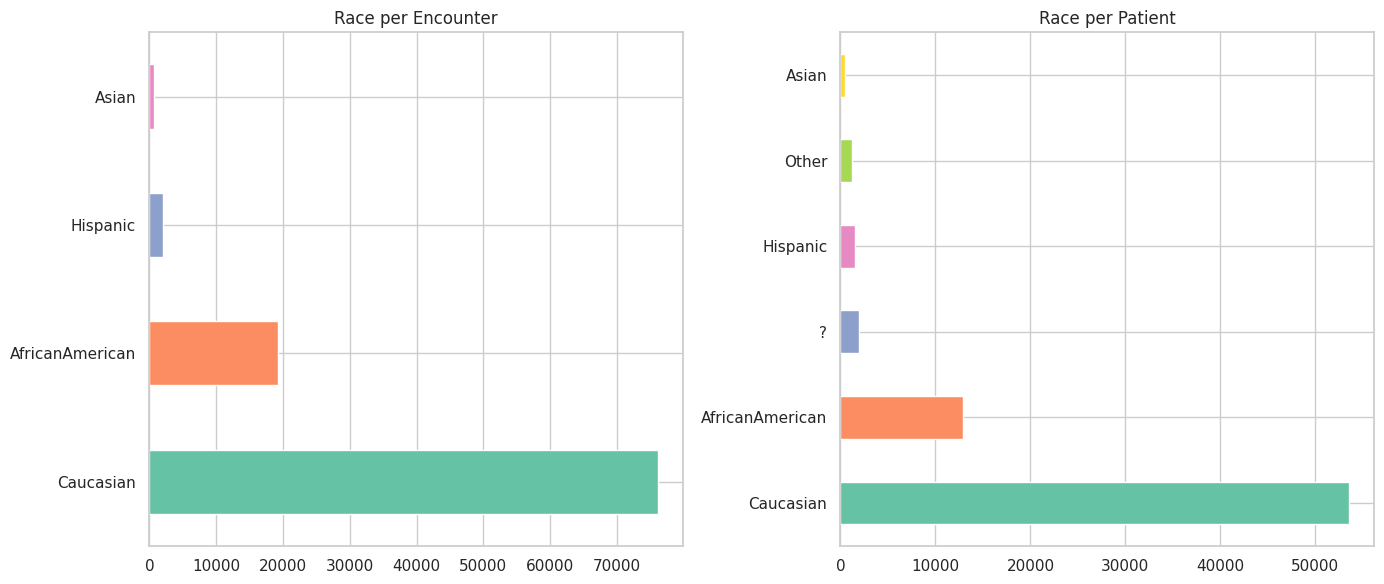

In [1346]:
# Race distribution: bar plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot Race per encounter on the first subplot
df["RACE"].value_counts().plot(kind="barh", color=sns.color_palette("Set2"), ax=axes[0])
axes[0].set_title("Race per Encounter")

# Plot Race per patient on the second subplot
df_simplified["RACE"].value_counts().plot(
    kind="barh", color=sns.color_palette("Set2"), ax=axes[1]
)
axes[1].set_title("Race per Patient")

# Layout
plt.tight_layout()
plt.show()


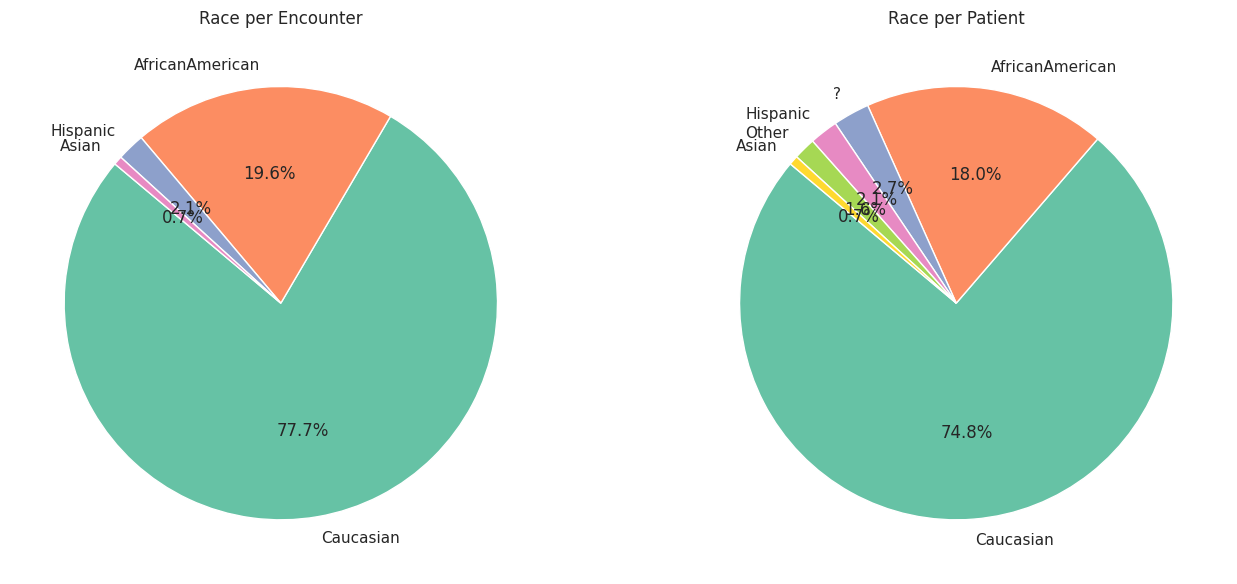

In [1347]:
# Race distribution: Pie plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot 'Race per encounter' on the first subplot
race_counts_encounter = df["RACE"].value_counts()
axes[0].pie(
    race_counts_encounter,
    labels=race_counts_encounter.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("Set2"),
)
axes[0].set_title("Race per Encounter")

# Plot 'Race per patient' on the second subplot
race_counts_patient = df_simplified["RACE"].value_counts()
axes[1].pie(
    race_counts_patient,
    labels=race_counts_patient.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("Set2"),
)
axes[1].set_title("Race per Patient")

# Adjust layout to prevent overlap and ensure clarity
plt.tight_layout()
plt.show()


`Gender` Distribution


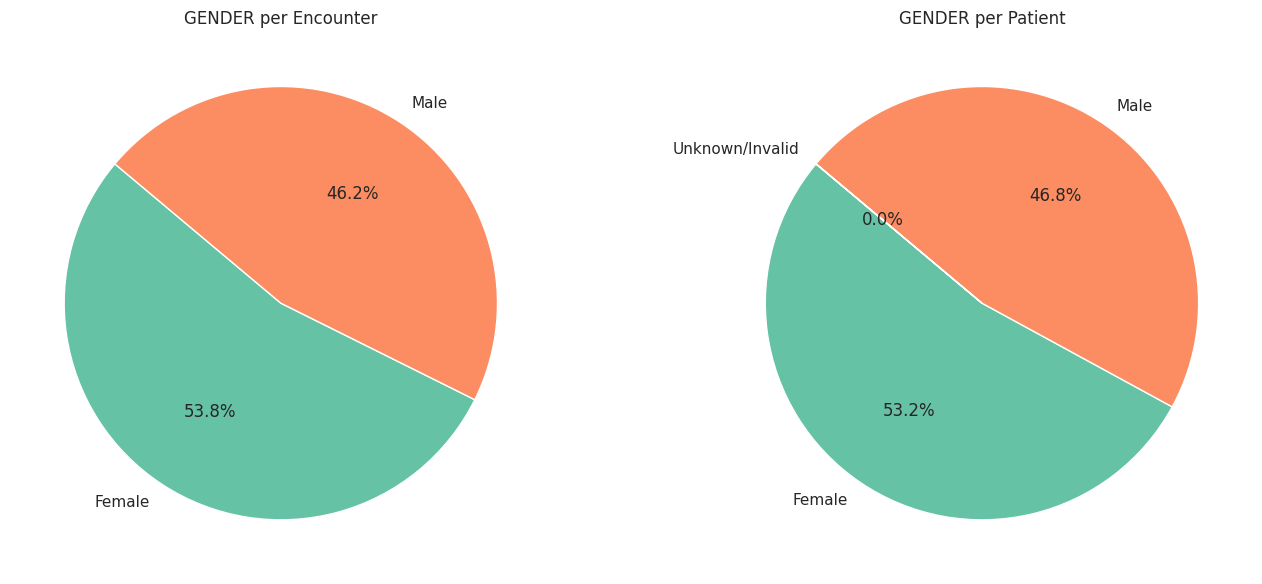

In [1348]:
# Set up the matplotlib figure with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot 'Race per encounter' on the first subplot
race_counts_encounter = df["GENDER"].value_counts()
axes[0].pie(
    race_counts_encounter,
    labels=race_counts_encounter.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("Set2"),
)
axes[0].set_title("GENDER per Encounter")

# Plot 'Race per patient' on the second subplot
race_counts_patient = df_simplified["GENDER"].value_counts()
axes[1].pie(
    race_counts_patient,
    labels=race_counts_patient.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("Set2"),
)
axes[1].set_title("GENDER per Patient")

# Adjust layout to prevent overlap and ensure clarity
plt.tight_layout()
plt.show()


`Age` Distribution


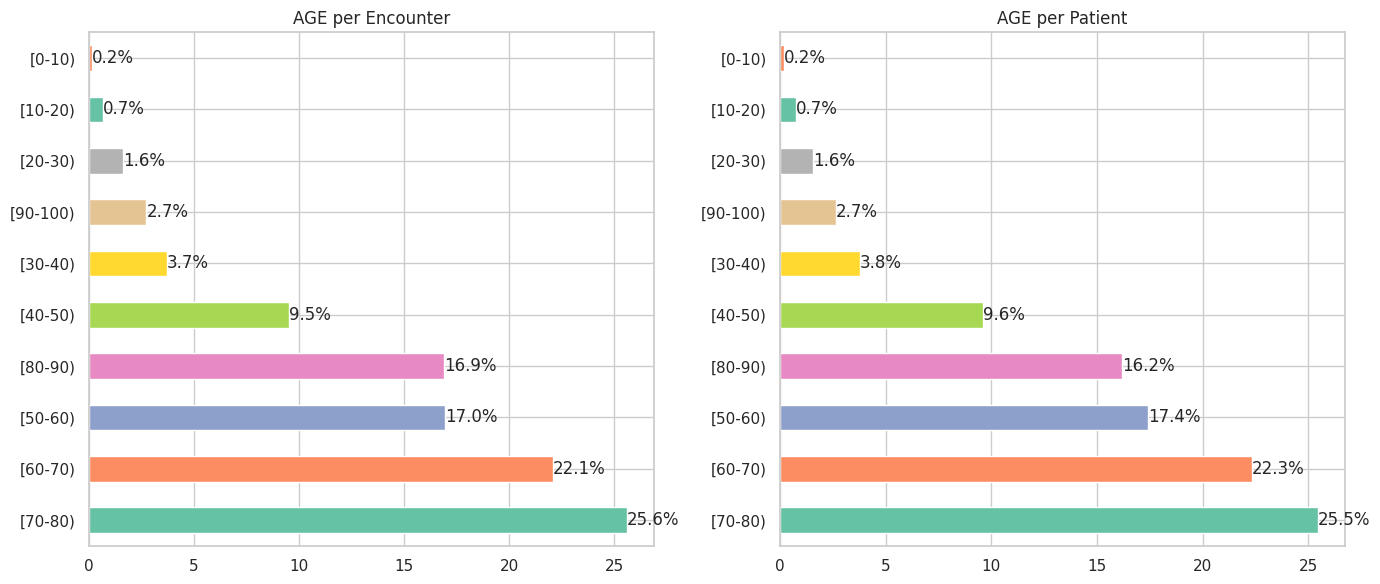

In [1349]:
# Age Distribution: bar plots

# Set up the matplotlib figure with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Race per encounter bar plot
race_counts_encounter = (
    df["AGE"].value_counts(normalize=True) * 100
)  # Convert counts to percentages
race_counts_encounter.plot(kind="barh", color=sns.color_palette("Set2"), ax=axes[0])
axes[0].set_title("AGE per Encounter")
# Add percentage text next to each bar
for index, value in enumerate(race_counts_encounter):
    axes[0].text(value, index, f"{value:.1f}%", va="center")

# Race per patient bar plot
race_counts_patient = (
    df_simplified["AGE"].value_counts(normalize=True) * 100
)  # Convert counts to percentages
race_counts_patient.plot(kind="barh", color=sns.color_palette("Set2"), ax=axes[1])
axes[1].set_title("AGE per Patient")
# Add percentage text next to each bar
for index, value in enumerate(race_counts_patient):
    axes[1].text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


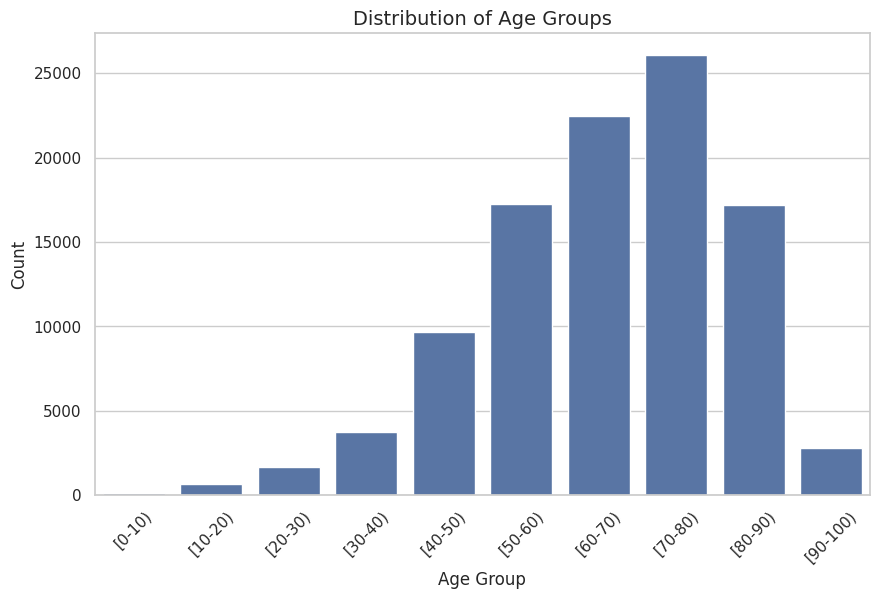

In [1350]:
# Age Distribution: histogram
plt.figure(figsize=(10, 6))
sns.countplot(x="AGE", data=df, order=sorted(df["AGE"].unique()))
plt.title("Distribution of Age Groups", fontsize=14)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()


High class imbalance towards older patients, which is normal for a diabete type-2

=> No Feature Engineering needed

=> Encoding: Ordinal Encoding (Ranking existing)


`Weight` Distribution


In [1351]:
df["WEIGHT"].unique()


array([nan, '[75-100)', '[50-75)', '[0-25)', '[100-125)', '[25-50)',
       '[125-150)', '[175-200)', '[150-175)', '>200'], dtype=object)

In [1352]:
df["WEIGHT"].isna().sum()


98569

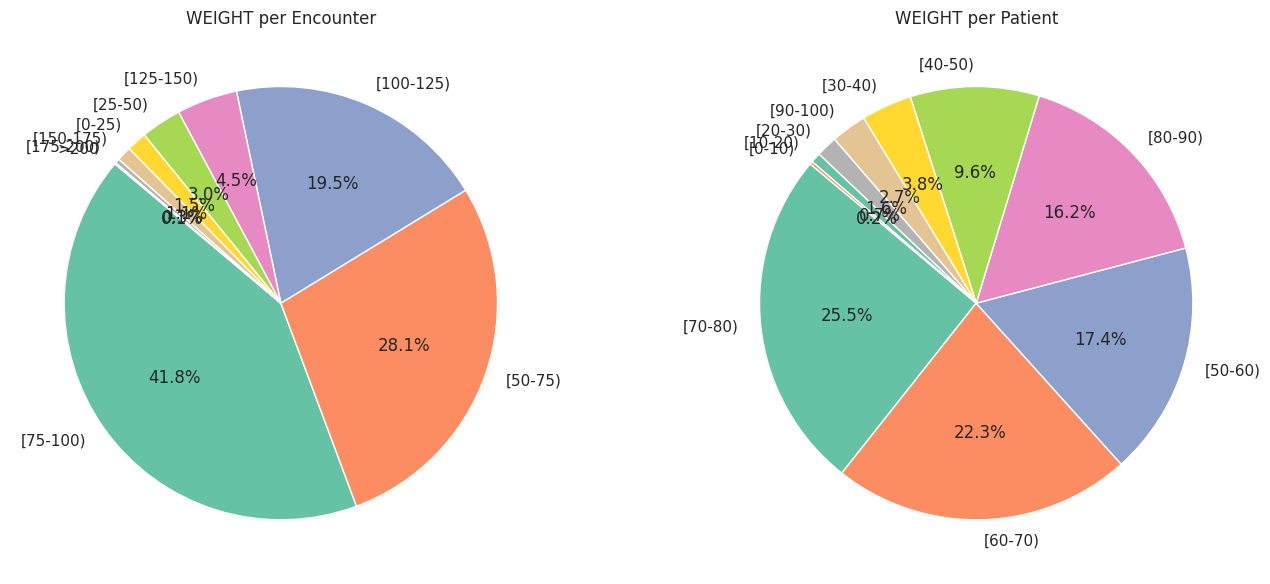

In [1353]:
# Set up the matplotlib figure with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot 'WEIGHT per encounter' on the first subplot
counts_encounter = df["WEIGHT"].value_counts()
axes[0].pie(
    counts_encounter,
    labels=counts_encounter.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("Set2"),
)
axes[0].set_title("WEIGHT per Encounter")

# Plot 'WEIGHT per patient' on the second subplot
counts_patient = df_simplified["WEIGHT"].value_counts()
axes[1].pie(
    race_counts_patient,
    labels=race_counts_patient.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("Set2"),
)
axes[1].set_title("WEIGHT per Patient")

# Adjust layout to prevent overlap and ensure clarity
plt.tight_layout()
plt.show()


In [1354]:
empty_coltodrop.append("WEIGHT")


`Payer-code` Distribution


In [1355]:
df["PAYER_CODE"].isna().sum()


40256

In [1356]:
df["PAYER_CODE"].nunique()


17

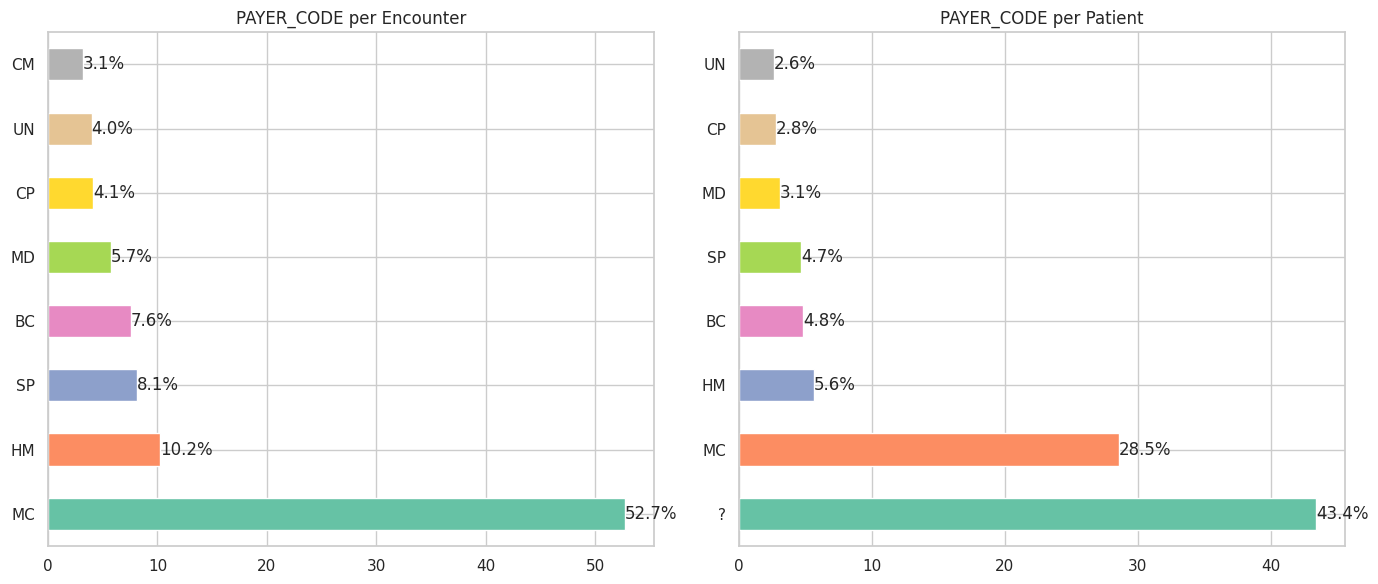

In [1357]:
# Set up the matplotlib figure with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# PAYER_CODE per encounter bar plot
counts_encounter = (
    df["PAYER_CODE"].value_counts(normalize=True) * 100
)  # Convert counts to percentages
# Filter values where percentage is greater than 2%
filtered_counts_encounter = counts_encounter[counts_encounter > 2]
filtered_counts_encounter.plot(kind="barh", color=sns.color_palette("Set2"), ax=axes[0])
axes[0].set_title("PAYER_CODE per Encounter")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_encounter):
    axes[0].text(value, index, f"{value:.1f}%", va="center")

# PAYER_CODE per patient bar plot
counts_patient = (
    df_simplified["PAYER_CODE"].value_counts(normalize=True) * 100
)  # Convert counts to percentages
# Filter values where percentage is greater than 2%
filtered_counts_patient = counts_patient[counts_patient > 2]
filtered_counts_patient.plot(kind="barh", color=sns.color_palette("Set2"), ax=axes[1])
axes[1].set_title("PAYER_CODE per Patient")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_patient):
    axes[1].text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


In [1358]:
df["PAYER_CODE"].nunique()


17

In [1359]:
df[cat_nonmed].nunique()


RACE                   4
GENDER                 2
AGE                   10
WEIGHT                 9
PAYER_CODE            17
MEDICAL_SPECIALTY     72
DIAG_1               716
DIAG_2               748
DIAG_3               789
MAX_GLU_SERUM          4
A1CRESULT              4
EXAMIDE                1
CITOGLIPTON            1
CHANGE                 2
DIABETESMED            2
READMITTED             2
dtype: int64

In [1360]:
cat_nonmed_analysis = ["DIAG_1", "DIAG_2", "DIAG_3", "MEDICAL_SPECIALTY"]


`Medical Speciality` Distribution


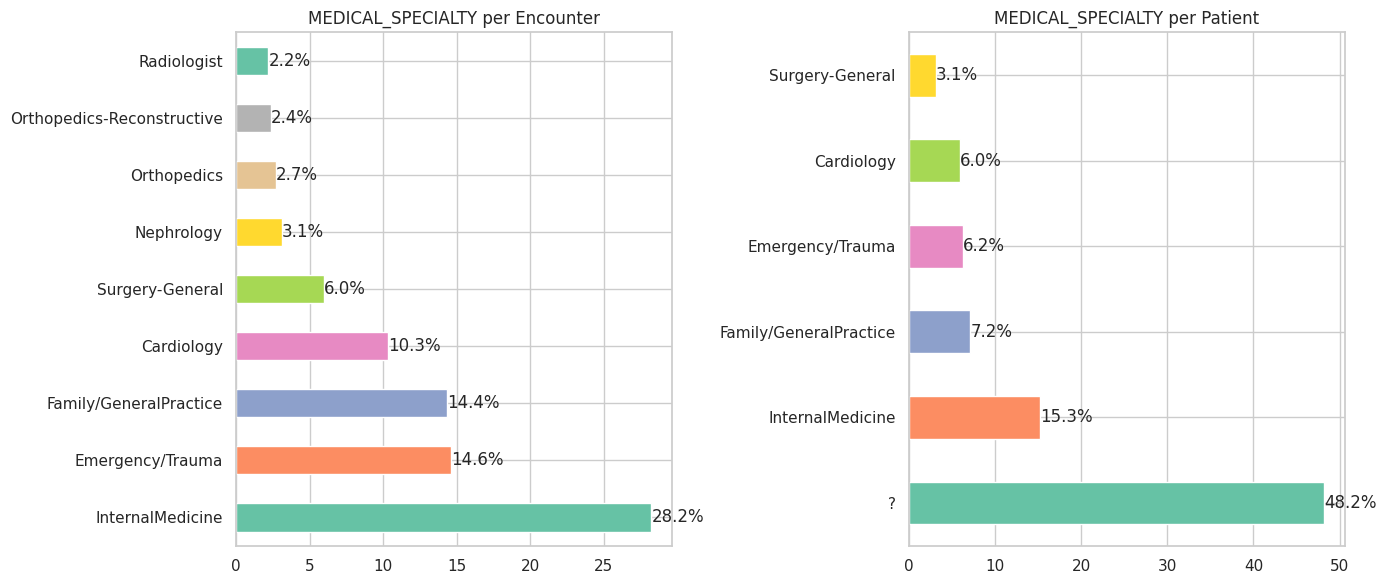

In [1361]:
# Set up the matplotlib figure with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# MEDICAL_SPECIALTYER_CODE per encounter bar plot
counts_encounter = (
    df["MEDICAL_SPECIALTY"].value_counts(normalize=True) * 100
)  # Convert counts to percentages
# Filter values where percentage is greater than 2%
filtered_counts_encounter = counts_encounter[counts_encounter > 2]
filtered_counts_encounter.plot(kind="barh", color=sns.color_palette("Set2"), ax=axes[0])
axes[0].set_title("MEDICAL_SPECIALTY per Encounter")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_encounter):
    axes[0].text(value, index, f"{value:.1f}%", va="center")

# MEDICAL_SPECIALTY per patient bar plot
counts_patient = (
    df_simplified["MEDICAL_SPECIALTY"].value_counts(normalize=True) * 100
)  # Convert counts to percentages
# Filter values where percentage is greater than 2%
filtered_counts_patient = counts_patient[counts_patient > 2]
filtered_counts_patient.plot(kind="barh", color=sns.color_palette("Set2"), ax=axes[1])
axes[1].set_title("MEDICAL_SPECIALTY per Patient")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_patient):
    axes[1].text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


`Diagnosis` Distribution


In [1362]:
%pip install icd9cms
from icd9cms.icd9 import search


In [1363]:
# ASSESSING THE COMPLEXITY
df[["DIAG_1", "DIAG_2", "DIAG_3"]].nunique()


DIAG_1    716
DIAG_2    748
DIAG_3    789
dtype: int64

In [1364]:
# DECODING

import icd9cms


def get_icd9_description(code):
    try:
        # Ensure the code is a string, remove decimal point if present
        code_str = str(code).replace(".", "")
        # Lookup the description
        description = icd9cms.search(code_str).short_desc
    except Exception as e:
        description = "OTHER"
    return description


df_diag = df[["DIAG_1", "DIAG_2", "DIAG_3", "ENCOUNTER_ID", "PATIENT_NBR"]].copy()

df_diag["DIAG_1_DESCRIPTION"] = df_diag["DIAG_1"].apply(get_icd9_description)
df_diag["DIAG_2_DESCRIPTION"] = df_diag["DIAG_2"].apply(get_icd9_description)
df_diag["DIAG_3_DESCRIPTION"] = df_diag["DIAG_3"].apply(get_icd9_description)

df_diag.head()


DIAG_1  DIAG_2 DIAG_3  ENCOUNTER_ID  PATIENT_NBR  \
0  250.83     NaN    NaN       2278392      8222157   
1     276  250.01    255        149190     55629189   
2     648     250    V27         64410     86047875   
3       8  250.43    403        500364     82442376   
4     197     157    250         16680     42519267   

                                  DIAG_1_DESCRIPTION  \
0                                   DMI oth uncntrld   
1  Disorders of fluid electrolyte and acid-base b...   
2  Other current conditions in the mother classif...   
3                                              OTHER   
4  Secondary malignant neoplasm of respiratory an...   

               DIAG_2_DESCRIPTION                   DIAG_3_DESCRIPTION  
0                           OTHER                                OTHER  
1        DMI wo cmp nt st uncntrl          Disorders of adrenal glands  
2               Diabetes mellitus                  Outcome of delivery  
3              DMI renal uncntrld  Hypertensive chronic kidney disease  
4  Malignant neoplasm of pancreas                    Diabetes mellitus

In [1365]:
def get_icd9_parent(code):
    try:
        # Ensure the code is a string, remove decimal point if present
        code_str = str(code).replace(".", "")
        # Lookup the description
        description = icd9cms.search(code_str).ancestors
    except Exception as e:
        description = "OTHER"
    return description


df_diag["DIAG_1_PARENT"] = df_diag["DIAG_1"].apply(get_icd9_parent)
df_diag["DIAG_2_PARENT"] = df_diag["DIAG_2"].apply(get_icd9_parent)
df_diag["DIAG_3_PARENT"] = df_diag["DIAG_3"].apply(get_icd9_parent)

df_diag.head()


DIAG_1  DIAG_2 DIAG_3  ENCOUNTER_ID  PATIENT_NBR  \
0  250.83     NaN    NaN       2278392      8222157   
1     276  250.01    255        149190     55629189   
2     648     250    V27         64410     86047875   
3       8  250.43    403        500364     82442376   
4     197     157    250         16680     42519267   

                                  DIAG_1_DESCRIPTION  \
0                                   DMI oth uncntrld   
1  Disorders of fluid electrolyte and acid-base b...   
2  Other current conditions in the mother classif...   
3                                              OTHER   
4  Secondary malignant neoplasm of respiratory an...   

               DIAG_2_DESCRIPTION                   DIAG_3_DESCRIPTION  \
0                           OTHER                                OTHER   
1        DMI wo cmp nt st uncntrl          Disorders of adrenal glands   
2               Diabetes mellitus                  Outcome of delivery   
3              DMI renal uncntrld  Hypertensive chronic kidney disease   
4  Malignant neoplasm of pancreas                    Diabetes mellitus   

                                       DIAG_1_PARENT  \
0  <bound method Node.ancestors of 25083:DMI oth ...   
1  <bound method Node.ancestors of 276:Disorders ...   
2  <bound method Node.ancestors of 648:Other curr...   
3                                              OTHER   
4  <bound method Node.ancestors of 197:Secondary ...   

                                       DIAG_2_PARENT  \
0                                              OTHER   
1  <bound method Node.ancestors of 25001:DMI wo c...   
2  <bound method Node.ancestors of 250:Diabetes m...   
3  <bound method Node.ancestors of 25043:DMI rena...   
4  <bound method Node.ancestors of 157:Malignant ...   

                                       DIAG_3_PARENT  
0                                              OTHER  
1  <bound method Node.ancestors of 255:Disorders ...  
2  <bound method Node.ancestors of V27:Outcome of...  
3  <bound method Node.ancestors of 403:Hypertensi...  
4  <bound method Node.ancestors of 250:Diabetes m...

In [1366]:
df_diag.columns


Index(['DIAG_1', 'DIAG_2', 'DIAG_3', 'ENCOUNTER_ID', 'PATIENT_NBR',
       'DIAG_1_DESCRIPTION', 'DIAG_2_DESCRIPTION', 'DIAG_3_DESCRIPTION',
       'DIAG_1_PARENT', 'DIAG_2_PARENT', 'DIAG_3_PARENT'],
      dtype='object')

In [1367]:
dir(icd9cms.search("648"))


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'alt_code',
 'ancestors',
 'children',
 'code',
 'descendants',
 'is_leaf',
 'leaves',
 'long_desc',
 'parent',
 'short_desc',
 'siblings']

In [1368]:
print(icd9cms.search("648").siblings)


[640:Hemorrhage in early pregnancy:None, 641:Antepartum hemorrhage abruptio placentae and placenta previa:None, 642:Hypertension complicating pregnancy childbirth and the puerperium:None, 643:Excessive vomiting in pregnancy:None, 644:Early or threatened labor:None, 645:Late pregnancy:None, 646:Other complications of pregnancy not elsewhere classified:None, 647:Infectious and parasitic conditions in the mother classifiable elsewhere but complicating pregnancy childbirth or the puerperium:None, 649:Other conditions or status of the mother complicating pregnancy, childbirth, or the puerperium:None]


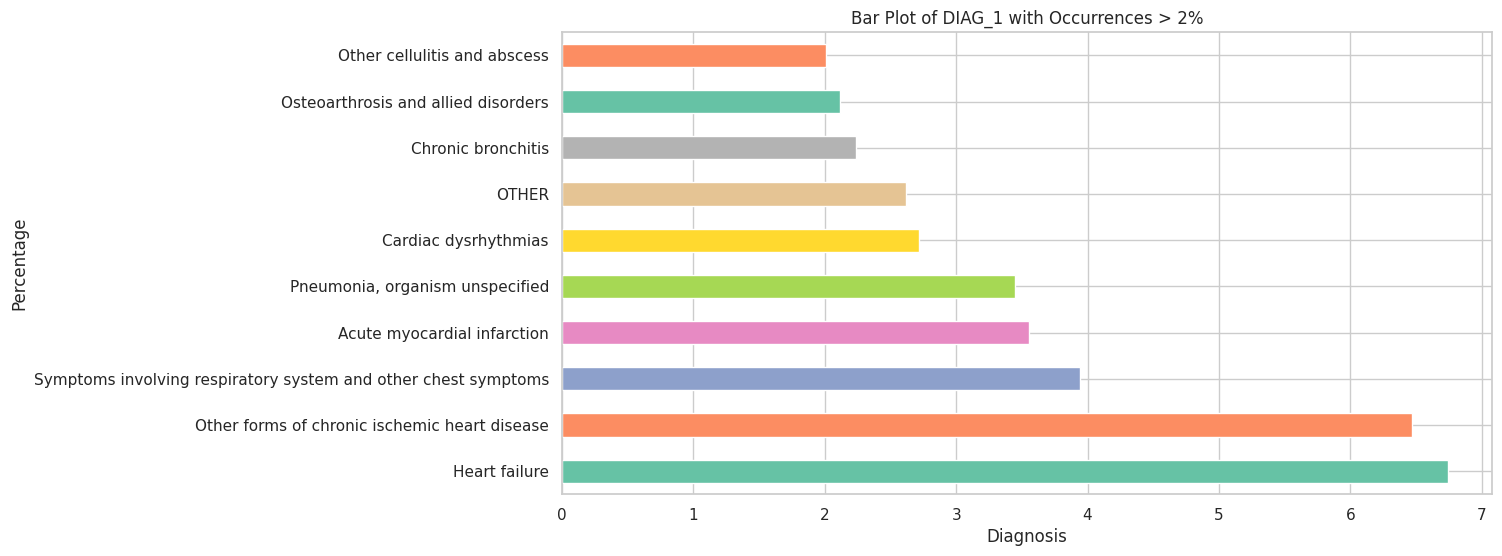

In [1369]:
import matplotlib.pyplot as plt

# Calculate the percentage of each diagnosis
diagnosis_counts = df_diag["DIAG_1_DESCRIPTION"].value_counts(normalize=True) * 100

# Filter the diagnoses with more than 2% occurrences
filtered_diagnoses = diagnosis_counts[diagnosis_counts > 2]

# Sort the filtered diagnoses by the number of occurrences
sorted_diagnoses = filtered_diagnoses.sort_values(ascending=False)

# Plot the bar plot
plt.figure(figsize=(12, 6))
sorted_diagnoses.plot(kind="barh", color=sns.color_palette("Set2"))
plt.xlabel("Diagnosis")
plt.ylabel("Percentage")
plt.title("Bar Plot of DIAG_1 with Occurrences > 2%")
plt.show()


In [1370]:
# Count the occurrences of each 'ADMISSION_TYPE_ID'
diag_counts = df_diag["DIAG_1"].value_counts(ascending=True)

# Create a DataFrame with 'ADMISSION_TYPE_ID' and its count
diag_counts_df = diag_counts.reset_index()
diag_counts_df.columns = ["DIAG_1", "COUNT"]

# Merge with the descriptions to get a full table
diag_description_df = df_diag[["DIAG_1", "DIAG_1_DESCRIPTION"]].drop_duplicates()
diag_table = diag_counts_df.merge(diag_description_df, on="DIAG_1", how="left")

# Sort the table by the count of 'ADMISSION_TYPE_ID' from least to most present
diag_table_sorted = diag_table.sort_values(by="COUNT")
diag_table_sorted[["DIAG_1_DESCRIPTION", "DIAG_1", "COUNT"]].tail(10)


DIAG_1_DESCRIPTION DIAG_1  COUNT
706                     Occlusion of cerebral arteries    434   2028
707                       Other cellulitis and abscess    682   2042
708                Osteoarthrosis and allied disorders    715   2151
709                                 Chronic bronchitis    491   2275
710                               Cardiac dysrhythmias    427   2766
711                    Pneumonia, organism unspecified    486   3508
712                        Acute myocardial infarction    410   3614
713  Symptoms involving respiratory system and othe...    786   4016
714      Other forms of chronic ischemic heart disease    414   6581
715                                      Heart failure    428   6862

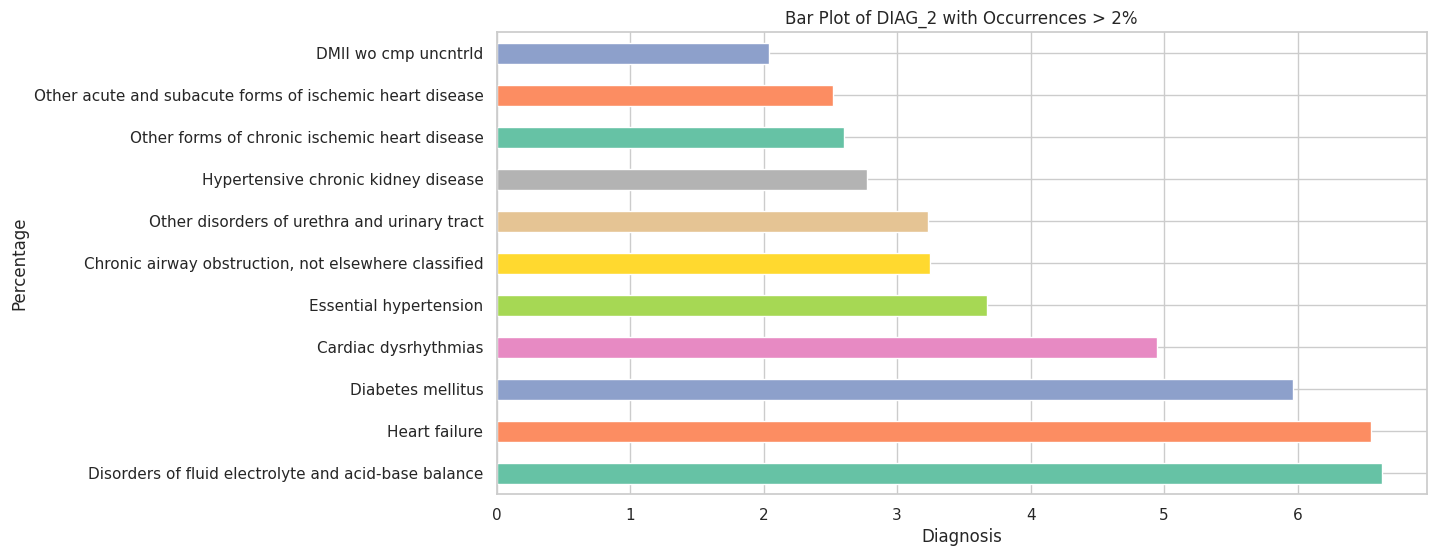

In [1371]:
# Calculate the percentage of each diagnosis
diagnosis_counts = df_diag["DIAG_2_DESCRIPTION"].value_counts(normalize=True) * 100

# Filter the diagnoses with more than 2% occurrences
filtered_diagnoses = diagnosis_counts[diagnosis_counts > 2]

# Sort the filtered diagnoses by the number of occurrences
sorted_diagnoses = filtered_diagnoses.sort_values(ascending=False)

# Plot the bar plot
plt.figure(figsize=(12, 6))
sorted_diagnoses.plot(kind="barh", color=sns.color_palette("Set2"))
plt.xlabel("Diagnosis")
plt.ylabel("Percentage")
plt.title("Bar Plot of DIAG_2 with Occurrences > 2%")
plt.show()


In [1372]:
# Count the occurrences of each 'ADMISSION_TYPE_ID'
diag_counts = df_diag["DIAG_2"].value_counts(ascending=True)

# Create a DataFrame with 'ADMISSION_TYPE_ID' and its count
diag_counts_df = diag_counts.reset_index()
diag_counts_df.columns = ["DIAG_2", "COUNT"]

# Merge with the descriptions to get a full table
diag_description_df = df_diag[["DIAG_2", "DIAG_2_DESCRIPTION"]].drop_duplicates()
diag_table = diag_counts_df.merge(diag_description_df, on="DIAG_2", how="left")

# Sort the table by the count of 'ADMISSION_TYPE_ID' from least to most present
diag_table_sorted = diag_table.sort_values(by="COUNT")
diag_table_sorted[["DIAG_2_DESCRIPTION", "DIAG_2", "COUNT"]].tail(10)


DIAG_2_DESCRIPTION DIAG_2  COUNT
738  Other acute and subacute forms of ischemic hea...    411   2566
739      Other forms of chronic ischemic heart disease    414   2650
740                Hypertensive chronic kidney disease    403   2823
741       Other disorders of urethra and urinary tract    599   3288
742  Chronic airway obstruction, not elsewhere clas...    496   3305
743                             Essential hypertension    401   3736
744                               Cardiac dysrhythmias    427   5036
745                                  Diabetes mellitus    250   6071
746                                      Heart failure    428   6662
747  Disorders of fluid electrolyte and acid-base b...    276   6752

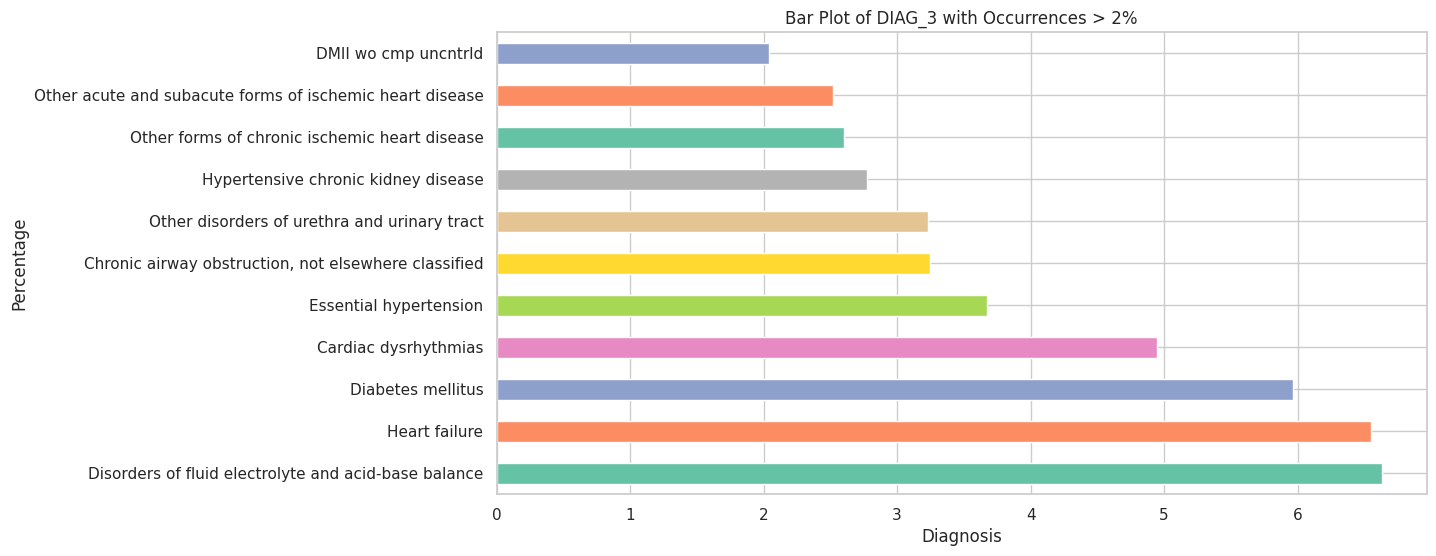

In [1373]:
# DIAG 3 PLOT
diagnosis_counts = df_diag["DIAG_2_DESCRIPTION"].value_counts(normalize=True) * 100

filtered_diagnoses = diagnosis_counts[diagnosis_counts > 2]

sorted_diagnoses = filtered_diagnoses.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sorted_diagnoses.plot(kind="barh", color=sns.color_palette("Set2"))
plt.xlabel("Diagnosis")
plt.ylabel("Percentage")
plt.title("Bar Plot of DIAG_3 with Occurrences > 2%")
plt.show()


In [1374]:
# DIAG 3 TABLE
diag_counts = df_diag["DIAG_3"].value_counts(ascending=True)

diag_counts_df = diag_counts.reset_index()
diag_counts_df.columns = ["DIAG_3", "COUNT"]

diag_description_df = df_diag[["DIAG_3", "DIAG_3_DESCRIPTION"]].drop_duplicates()
diag_table = diag_counts_df.merge(diag_description_df, on="DIAG_3", how="left")

diag_table_sorted = diag_table.sort_values(by="COUNT")
diag_table_sorted[["DIAG_3_DESCRIPTION", "DIAG_3", "COUNT"]].tail(10)


DIAG_3_DESCRIPTION DIAG_3  COUNT
779                     Disorders of lipoid metabolism    272   1969
780                       Chronic kidney disease (ckd)    585   1992
781                Hypertensive chronic kidney disease    403   2357
782  Chronic airway obstruction, not elsewhere clas...    496   2605
783      Other forms of chronic ischemic heart disease    414   3664
784                               Cardiac dysrhythmias    427   3955
785                                      Heart failure    428   4577
786  Disorders of fluid electrolyte and acid-base b...    276   5175
787                             Essential hypertension    401   8289
788                                  Diabetes mellitus    250  11555

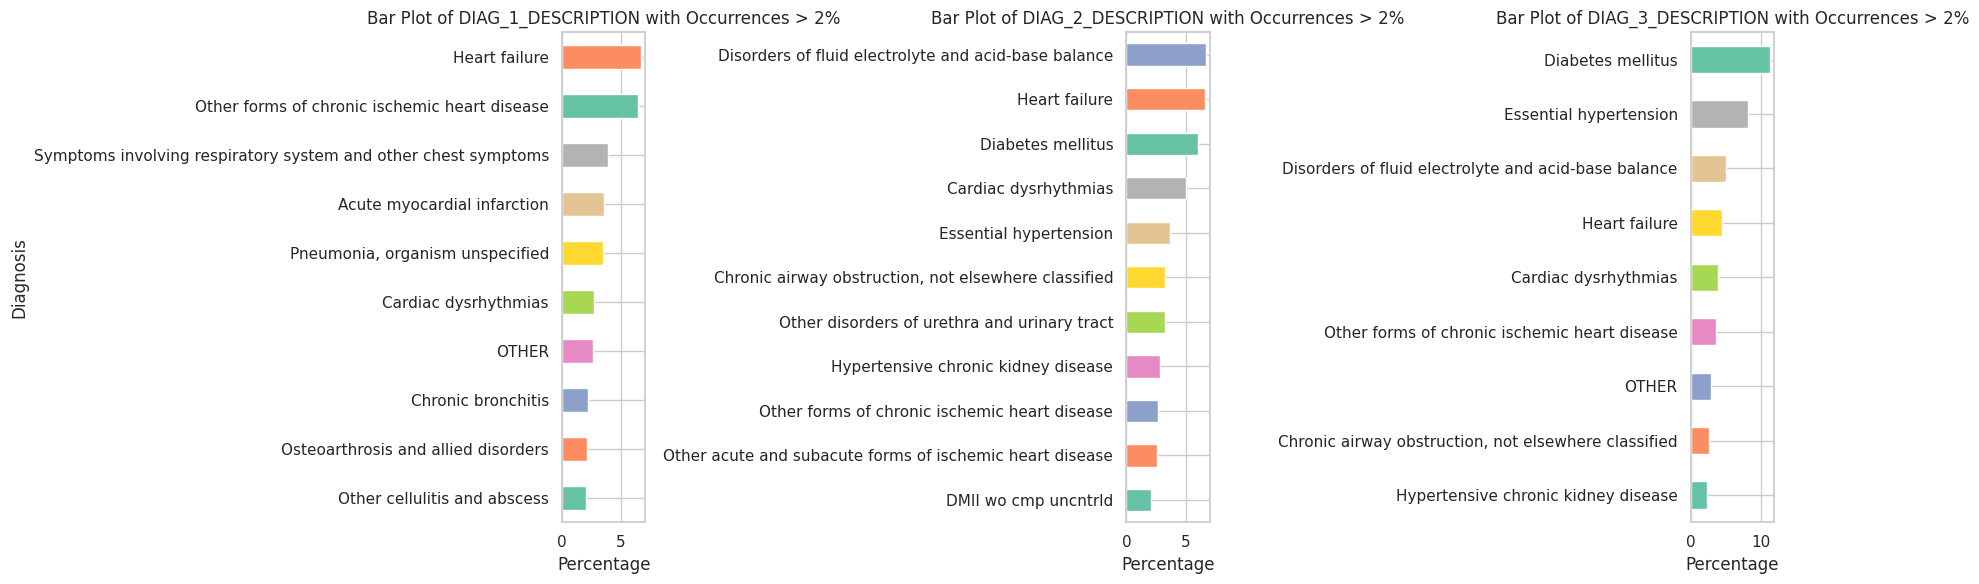

In [1375]:
# THREE PLOTS TOGETHER
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# List of diagnosis columns to plot
diagnosis_columns = ["DIAG_1_DESCRIPTION", "DIAG_2_DESCRIPTION", "DIAG_3_DESCRIPTION"]

# Loop through each diagnosis column and create a bar plot
for i, diag_col in enumerate(diagnosis_columns):
    # Calculate the percentage of each diagnosis
    diagnosis_counts = df_diag[diag_col].value_counts(normalize=True) * 100

    # Filter the diagnoses with more than 2% occurrences
    filtered_diagnoses = diagnosis_counts[diagnosis_counts > 2]

    # Sort the filtered diagnoses by the number of occurrences for a horizontal plot
    sorted_diagnoses = filtered_diagnoses.sort_values(ascending=True)

    # Plot the horizontal bar plot on the subplot
    sorted_diagnoses.plot(kind="barh", ax=axes[i], color=sns.color_palette("Set2"))
    axes[i].set_xlabel("Percentage")  # X label now represents 'Percentage'
    axes[i].set_title(f"Bar Plot of {diag_col} with Occurrences > 2%")

# Set a common y-label
axes[0].set_ylabel("Diagnosis")  # Y label now represents 'Diagnosis'

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


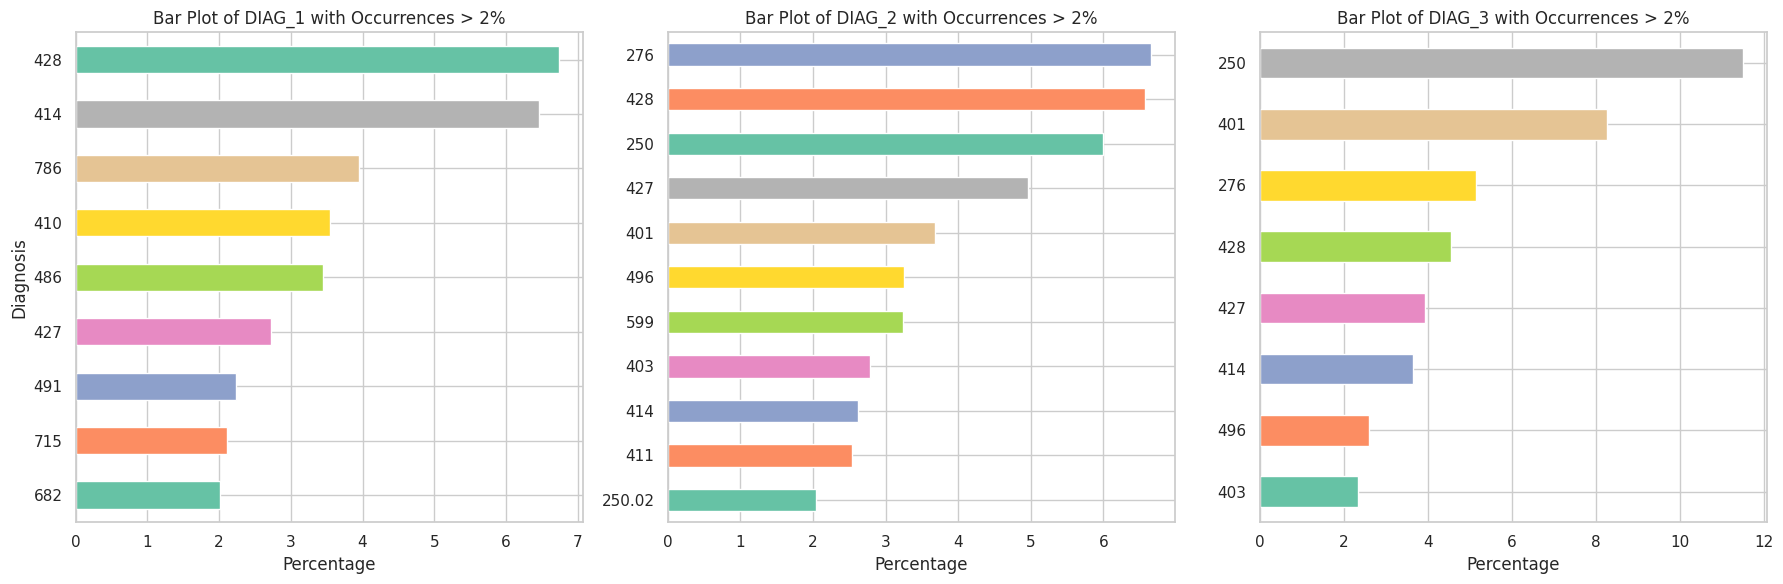

In [1376]:
# Bar plots together

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# List of diagnosis columns to plot
diagnosis_columns = ["DIAG_1", "DIAG_2", "DIAG_3"]

# Loop through each diagnosis column and create a bar plot
for i, diag_col in enumerate(diagnosis_columns):
    # Calculate the percentage of each diagnosis
    diagnosis_counts = df_diag[diag_col].value_counts(normalize=True) * 100

    # Filter the diagnoses with more than 2% occurrences
    filtered_diagnoses = diagnosis_counts[diagnosis_counts > 2]

    # Sort the filtered diagnoses by the number of occurrences for a horizontal plot
    sorted_diagnoses = filtered_diagnoses.sort_values(ascending=True)

    # Plot the horizontal bar plot on the subplot
    sorted_diagnoses.plot(kind="barh", ax=axes[i], color=sns.color_palette("Set2"))
    axes[i].set_xlabel("Percentage")  # X label now represents 'Percentage'
    axes[i].set_title(f"Bar Plot of {diag_col} with Occurrences > 2%")

# Set a common y-label
axes[0].set_ylabel("Diagnosis")  # Y label now represents 'Diagnosis'

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


MAX_GLU_SERUM


In [1377]:
df["MAX_GLU_SERUM"].isnull().sum()


0

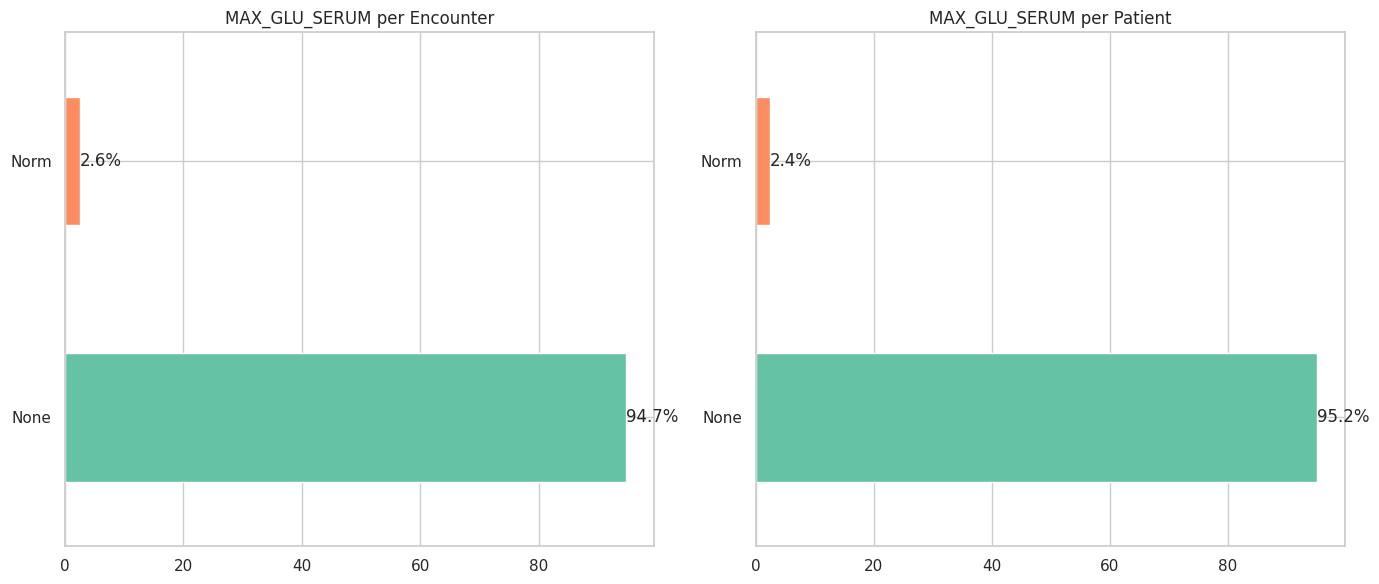

In [1378]:
# BAR PLOT
feature_toplot = "MAX_GLU_SERUM"

# Set up the matplotlib figure with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# PAYMEDICAL_SPECIALTYER_CODE per encounter bar plot
counts_encounter = (
    df[feature_toplot].value_counts(normalize=True) * 100
)  # Convert counts to percentages
# Filter values where percentage is greater than 2%
filtered_counts_encounter = counts_encounter[counts_encounter > 2]
filtered_counts_encounter.plot(kind="barh", color=sns.color_palette("Set2"), ax=axes[0])
axes[0].set_title(f"{feature_toplot} per Encounter")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_encounter):
    axes[0].text(value, index, f"{value:.1f}%", va="center")

# MEDICAL_SPECIALTY per patient bar plot
counts_patient = (
    df_simplified[feature_toplot].value_counts(normalize=True) * 100
)  # Convert counts to percentages
# Filter values where percentage is greater than 2%
filtered_counts_patient = counts_patient[counts_patient > 2]
filtered_counts_patient.plot(kind="barh", color=sns.color_palette("Set2"), ax=axes[1])
axes[1].set_title(f"{feature_toplot} per Patient")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_patient):
    axes[1].text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


A1C Results


In [1379]:
df["A1CRESULT"].isna().sum()
df["A1CRESULT"] = df["A1CRESULT"].fillna("NO TEST TAKEN")


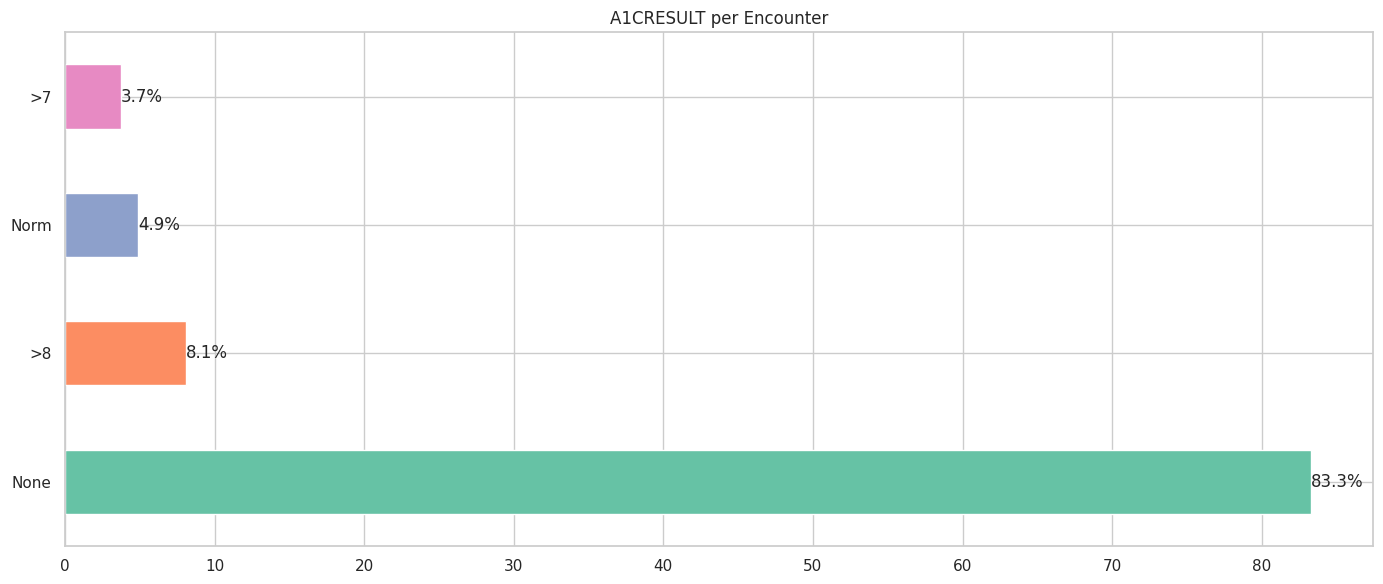

In [1380]:
# BAR PLOT
feature_toplot = "A1CRESULT"

# Set up the matplotlib figure for a single plot
fig, ax = plt.subplots(figsize=(14, 6))

# A1CRESULT per encounter bar plot
counts_encounter = (
    df[feature_toplot].value_counts(normalize=True) * 100
)  # Convert counts to percentages

# Filter values where percentage is greater than 2%
filtered_counts_encounter = counts_encounter[counts_encounter > 2]

# Create horizontal bar plot
filtered_counts_encounter.plot(kind="barh", color=sns.color_palette("Set2"), ax=ax)

# Set title
ax.set_title(f"{feature_toplot} per Encounter")

# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_encounter):
    ax.text(value, index, f"{value:.1f}%", va="center")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


Examide


In [1381]:
df["EXAMIDE"].nunique()


1

In [1382]:
empty_coltodrop.append("EXAMIDE")
empty_coltodrop


['WEIGHT', 'EXAMIDE']

CITOGLIPTON


In [1383]:
df["CITOGLIPTON"].nunique()


1

In [1384]:
empty_coltodrop.append("CITOGLIPTON")
empty_coltodrop


['WEIGHT', 'EXAMIDE', 'CITOGLIPTON']

`CHANGE`


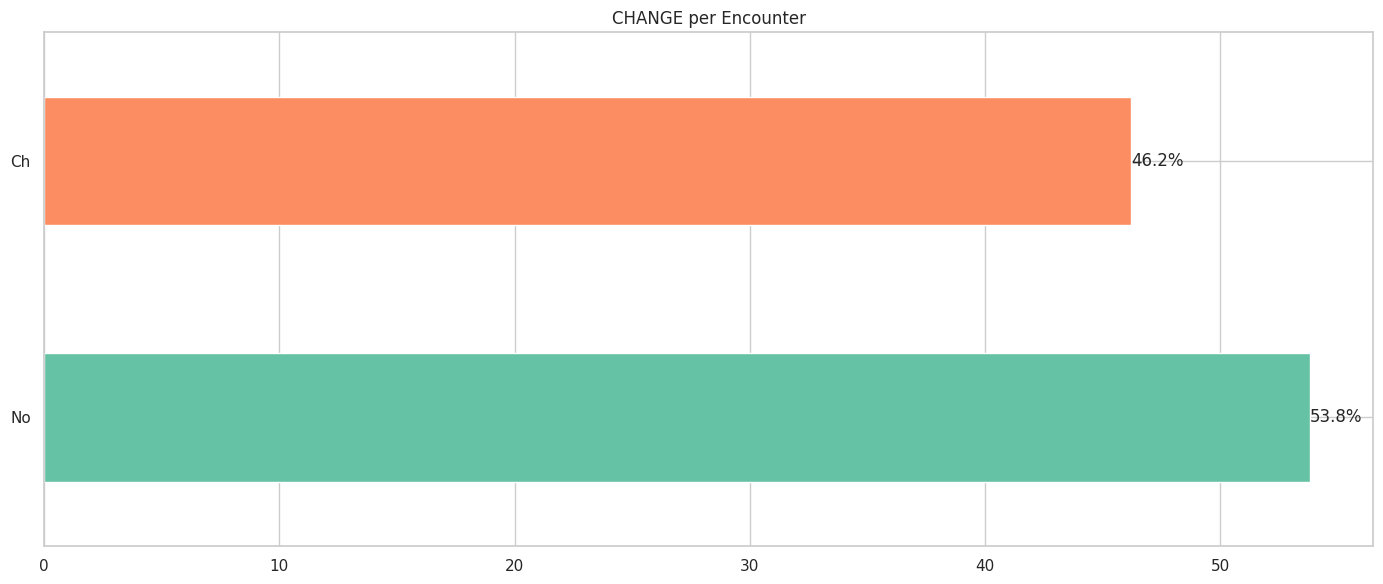

In [1385]:
# BAR PLOT
feature_toplot = "CHANGE"


fig, ax = plt.subplots(figsize=(14, 6))

counts_encounter = df[feature_toplot].value_counts(normalize=True) * 100

filtered_counts_encounter = counts_encounter[counts_encounter > 2]

filtered_counts_encounter.plot(kind="barh", color=sns.color_palette("Set2"), ax=ax)

ax.set_title(f"{feature_toplot} per Encounter")

for index, value in enumerate(filtered_counts_encounter):
    ax.text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


DIABETESMED


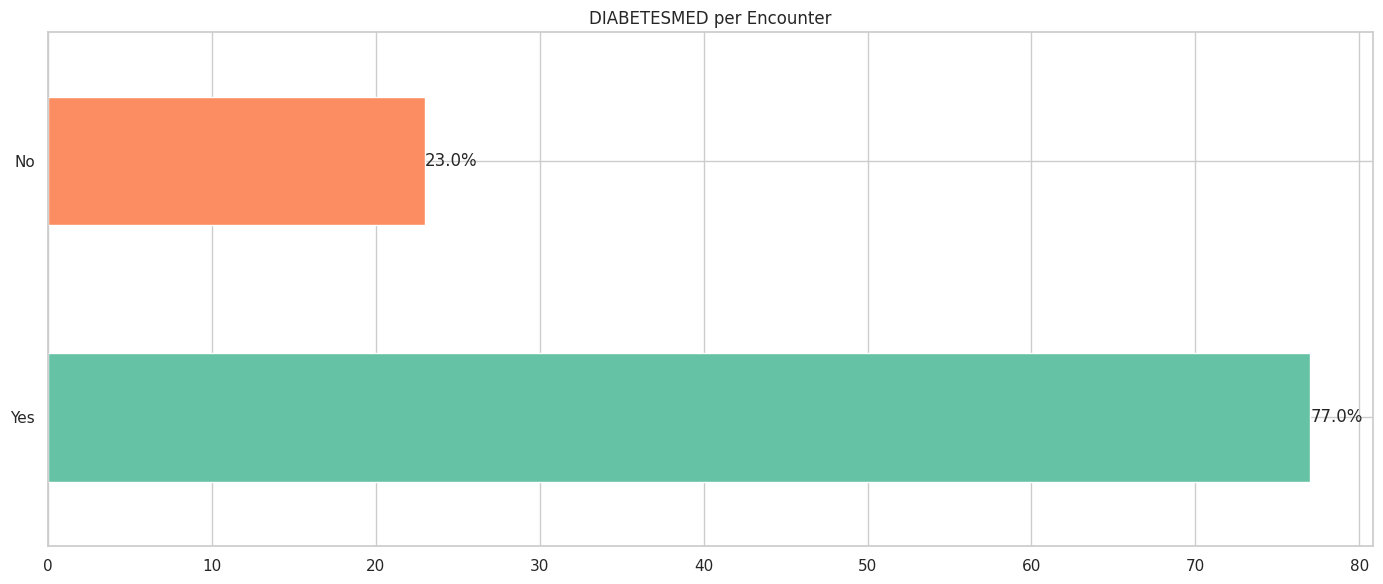

In [1386]:
# BAR PLOT
feature_toplot = "DIABETESMED"


fig, ax = plt.subplots(figsize=(14, 6))

counts_encounter = df[feature_toplot].value_counts(normalize=True) * 100

filtered_counts_encounter = counts_encounter[counts_encounter > 2]

filtered_counts_encounter.plot(kind="barh", color=sns.color_palette("Set2"), ax=ax)

ax.set_title(f"{feature_toplot} per Encounter")

for index, value in enumerate(filtered_counts_encounter):
    ax.text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


All categorical data


In [1387]:
cat_nonmed_plotting = [col for col in cat_nonmed if col not in empty_coltodrop]
cat_nonmed_plotting = [
    col for col in cat_nonmed_plotting if col not in cat_nonmed_analysis
]
cat_nonmed_plotting.remove("READMITTED")

cat_nonmed_plotting


['RACE',
 'GENDER',
 'AGE',
 'PAYER_CODE',
 'MAX_GLU_SERUM',
 'A1CRESULT',
 'CHANGE',
 'DIABETESMED']

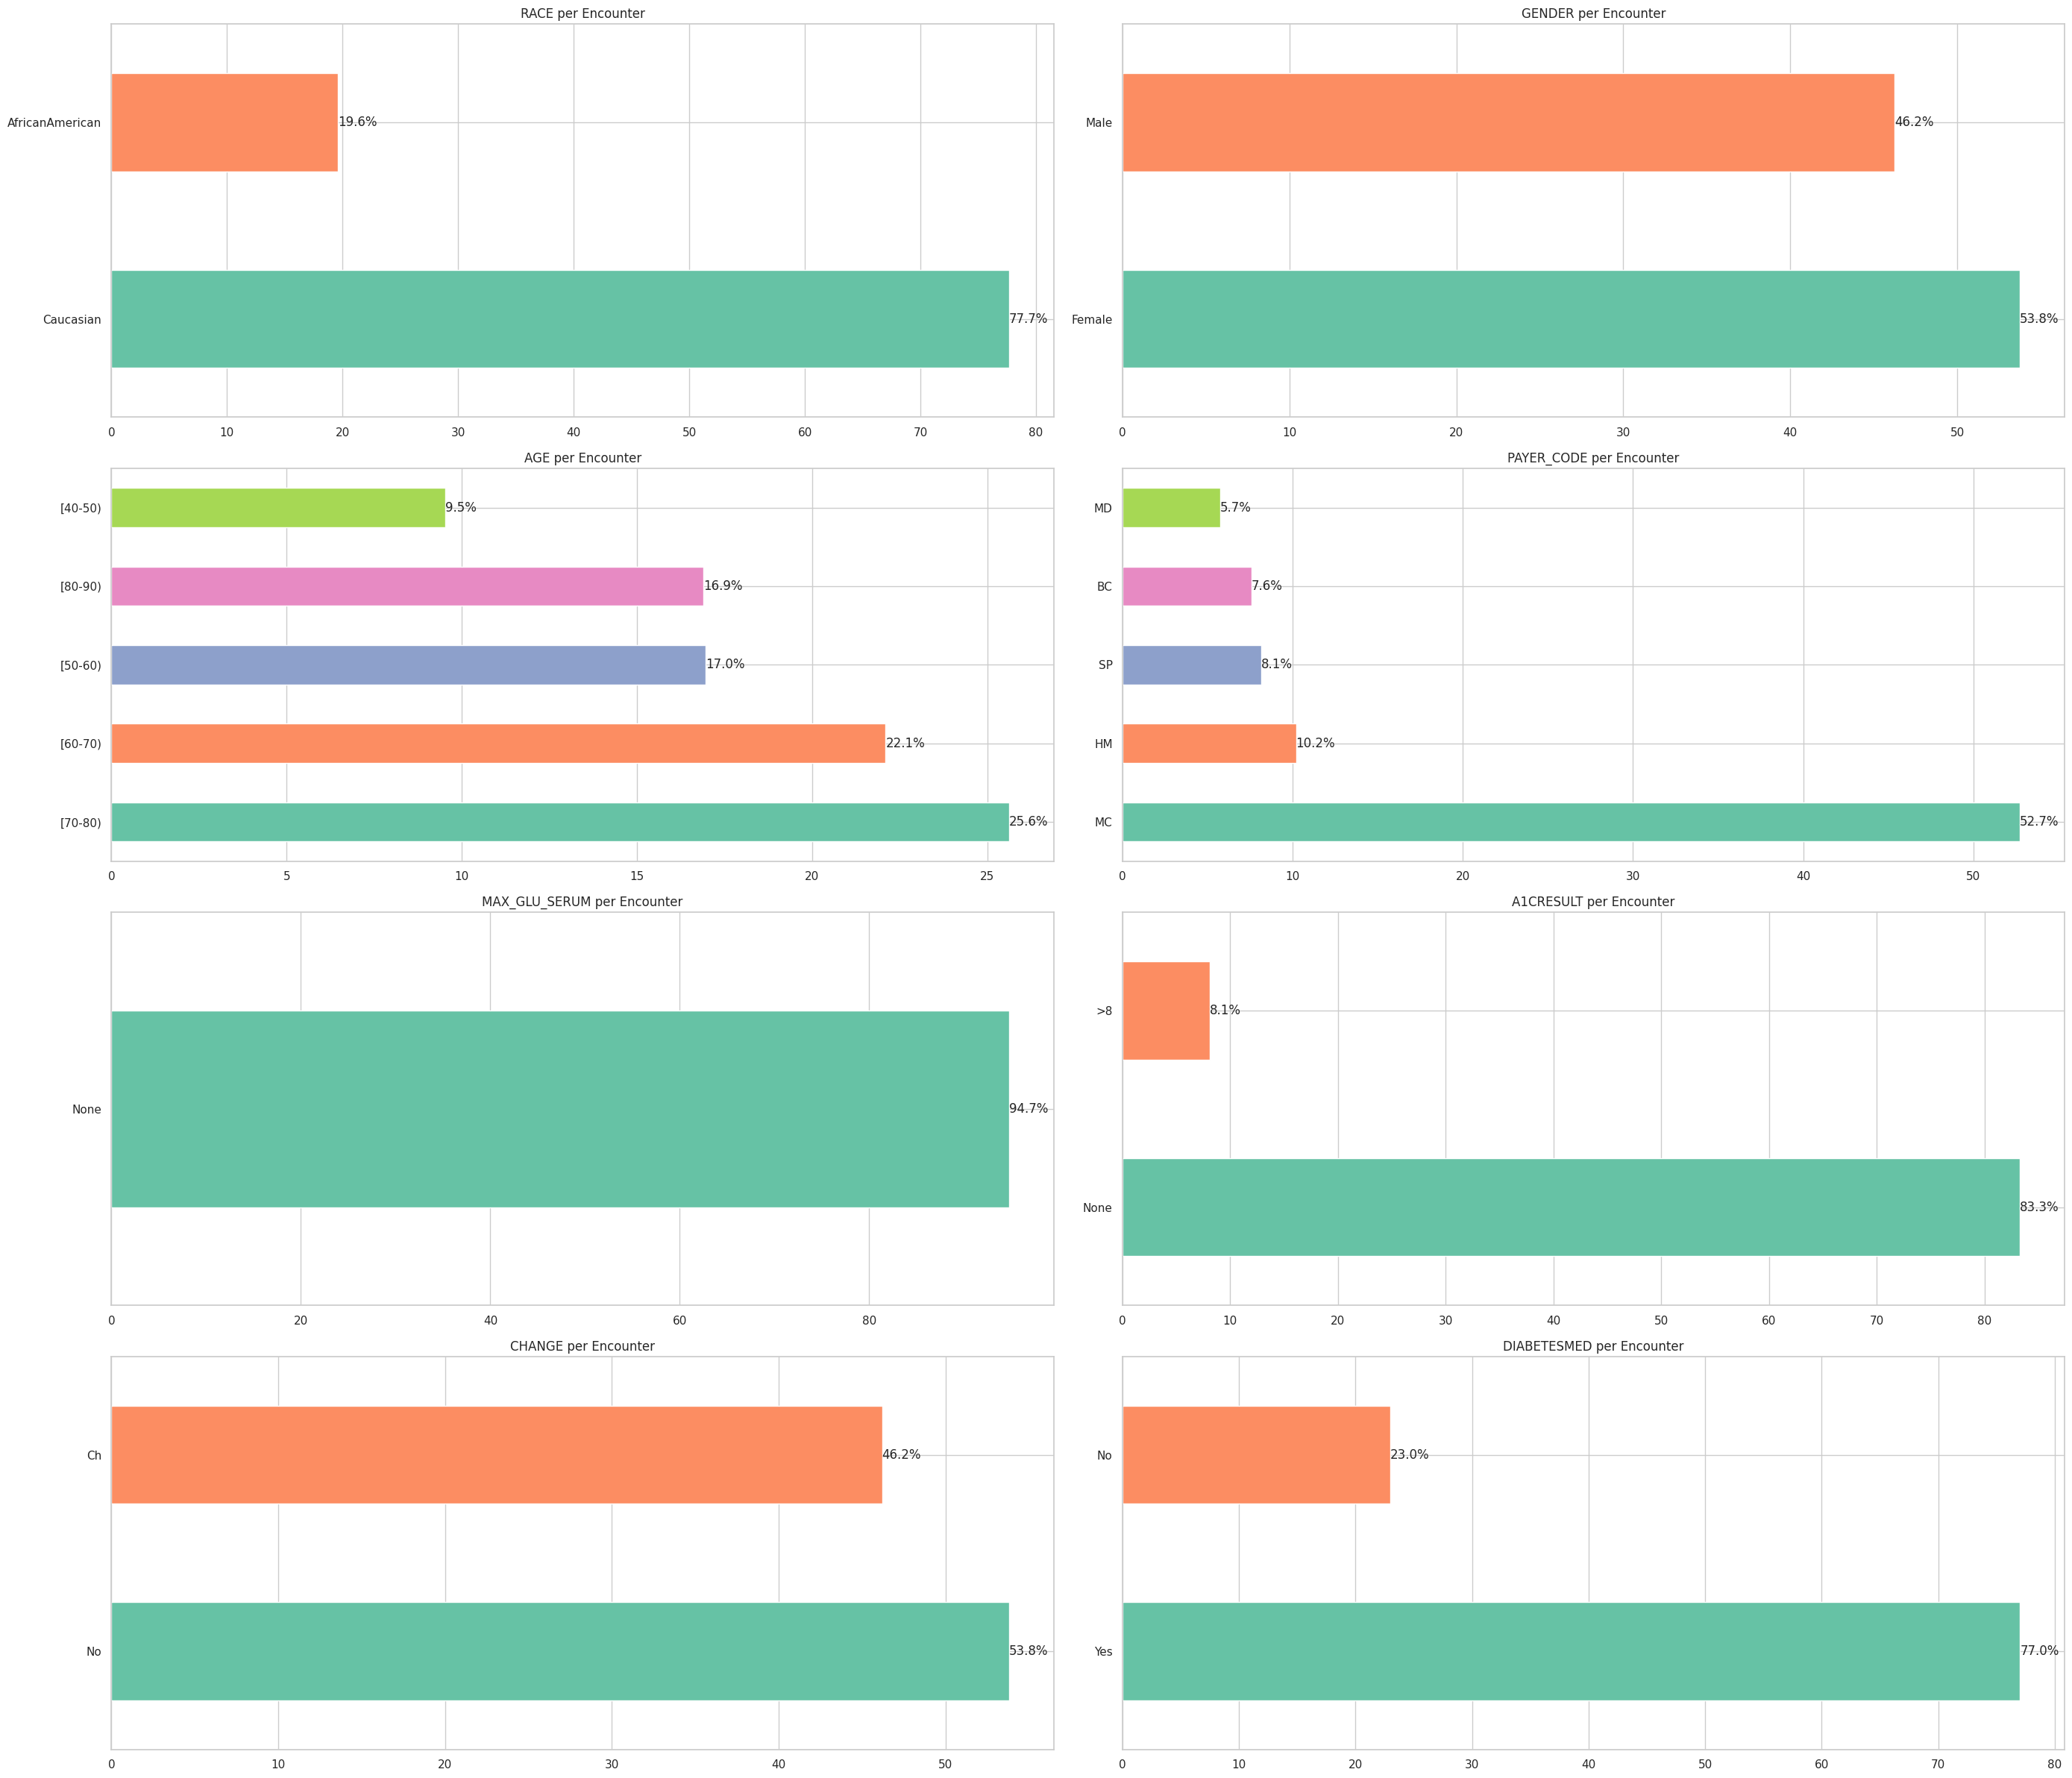

In [1388]:
# Number of plots per row
plots_per_row = 2

# Calculate the number of rows needed
num_rows = len(cat_nonmed_plotting) // plots_per_row + (
    len(cat_nonmed_plotting) % plots_per_row > 0
)

# Set up the matplotlib figure
fig, axes = plt.subplots(
    nrows=num_rows, ncols=plots_per_row, figsize=(14 * plots_per_row, 6 * num_rows)
)

for i, feature_toplot in enumerate(cat_nonmed_plotting):
    # Determine the current subplot row and column
    row = i // plots_per_row
    col = i % plots_per_row

    # Current axis
    ax = axes[row, col] if num_rows > 1 else axes[col]

    # Feature counts and filtering
    counts_encounter = (
        df[feature_toplot].value_counts(normalize=True) * 100
    )  # Convert counts to percentages
    filtered_counts_encounter = counts_encounter[
        counts_encounter > 5
    ]  # Filter values where percentage is greater than 2%

    # Plot
    filtered_counts_encounter.plot(kind="barh", color=sns.color_palette("Set2"), ax=ax)
    ax.set_title(f"{feature_toplot} per Encounter")

    # Add percentage text next to each bar
    for index, value in enumerate(filtered_counts_encounter):
        ax.text(value, index, f"{value:.1f}%", va="center")

# Adjust layout to prevent overlap and ensure clarity
plt.tight_layout()
plt.show()


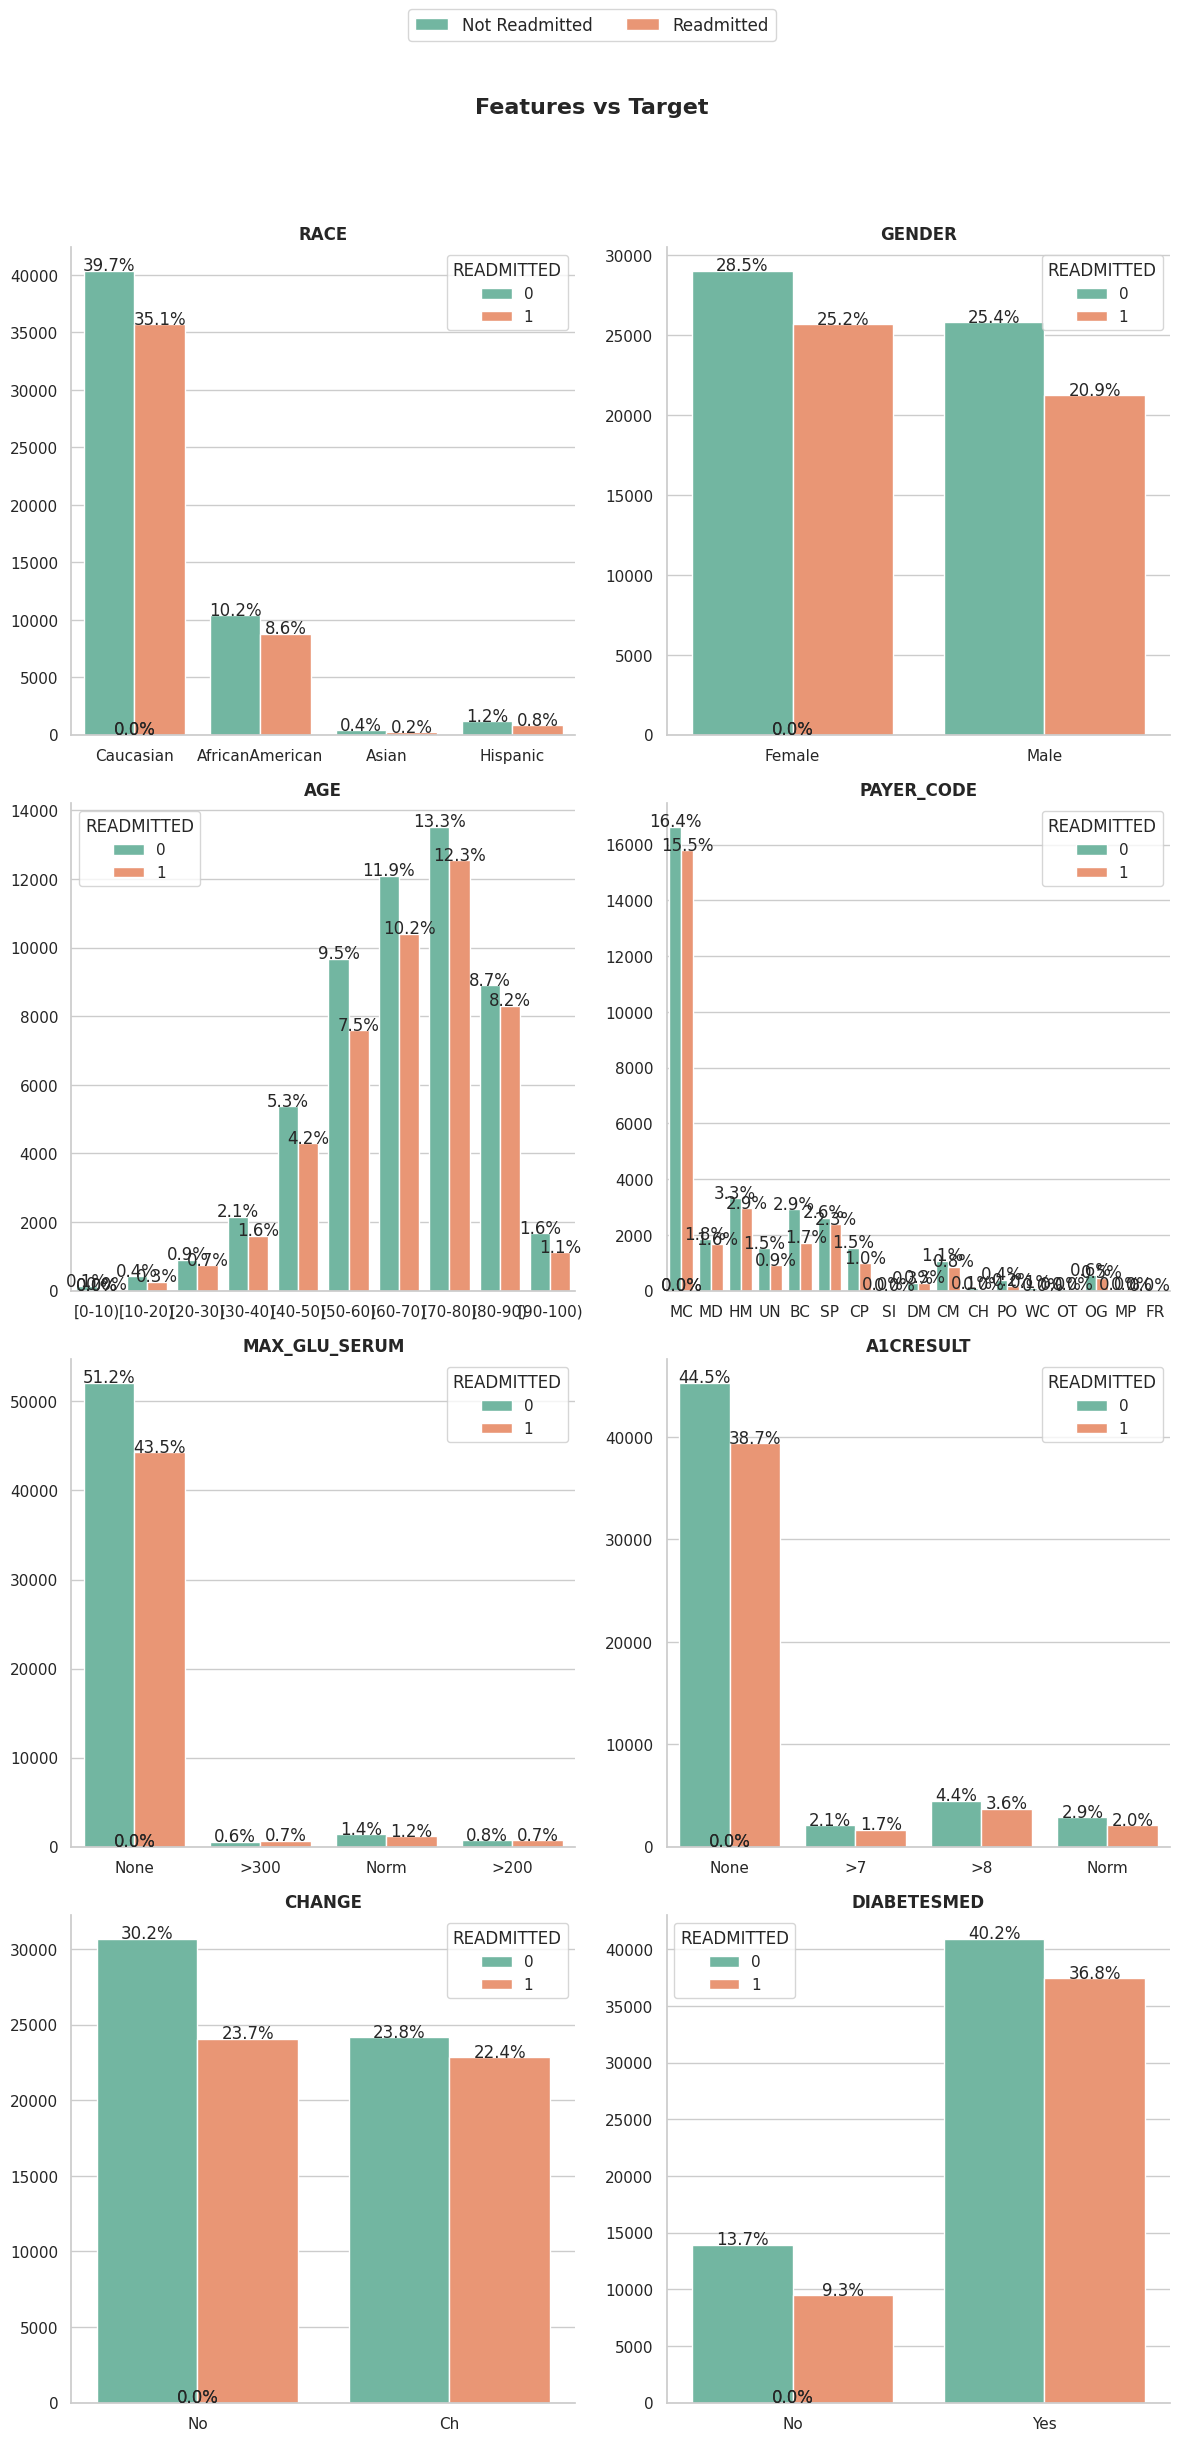

In [1389]:
# Categorical data, hued per readmission

# Determine the size and layout of the subplots
figsize = (12, len(cat_nonmed_plotting) * 3)  # Adjusted for better visualization
n_cols = 2  # Number of columns in the subplot grid
n_rows = len(cat_nonmed_plotting) // n_cols + (
    len(cat_nonmed_plotting) % n_cols > 0
)  # Calculate required number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

for idx, cat_col in enumerate(cat_nonmed_plotting):
    row = idx // n_cols
    col_idx = idx % n_cols
    ax = (
        axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    )  # Adjust for when there's only one row
    sns.countplot(data=df, hue="READMITTED", x=cat_col, palette="Set2", ax=ax)

    # Calculate and display the percentages on the bars
    # ! TODO : Fix the percentages
    for p in ax.patches:
        height = p.get_height()
        total = len(
            df[cat_col]
        )  # Total number of observations for the current category
        percentage = f"{100 * height / total:.1f}%"  # Calculate percentage

        # Get the current patch's x-coordinate and width
        x = p.get_x()
        width = p.get_width()

        # Set the text annotations centered above each patch
        ax.text(x + width / 2.0, height + 5, percentage, ha="center")

    # Improve subplot aesthetics
    ax.set_ylabel("")
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("")
    ax.spines["right"].set_visible(False)
    ax.set_title(f"{cat_col}", loc="center", weight="bold", fontsize=12)

# Hide any unused subplots
if len(cat_nonmed_plotting) % n_cols != 0:
    for idx in range(len(cat_nonmed_plotting), n_rows * n_cols):
        fig.delaxes(axes.flatten()[idx])

# Adjust the layout and add a title
fig.suptitle("Features vs Target", ha="center", fontweight="bold", fontsize=16)

# Add a legend outside the last subplot
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    ["Not Readmitted", "Readmitted"],
    loc="upper center",
    bbox_to_anchor=(0.5, 1.02),
    ncol=2,
    fontsize=12,
)

plt.tight_layout(
    rect=[0, 0, 1, 0.95]
)  # Adjust the rect parameter to make space for the title and legend
plt.show()


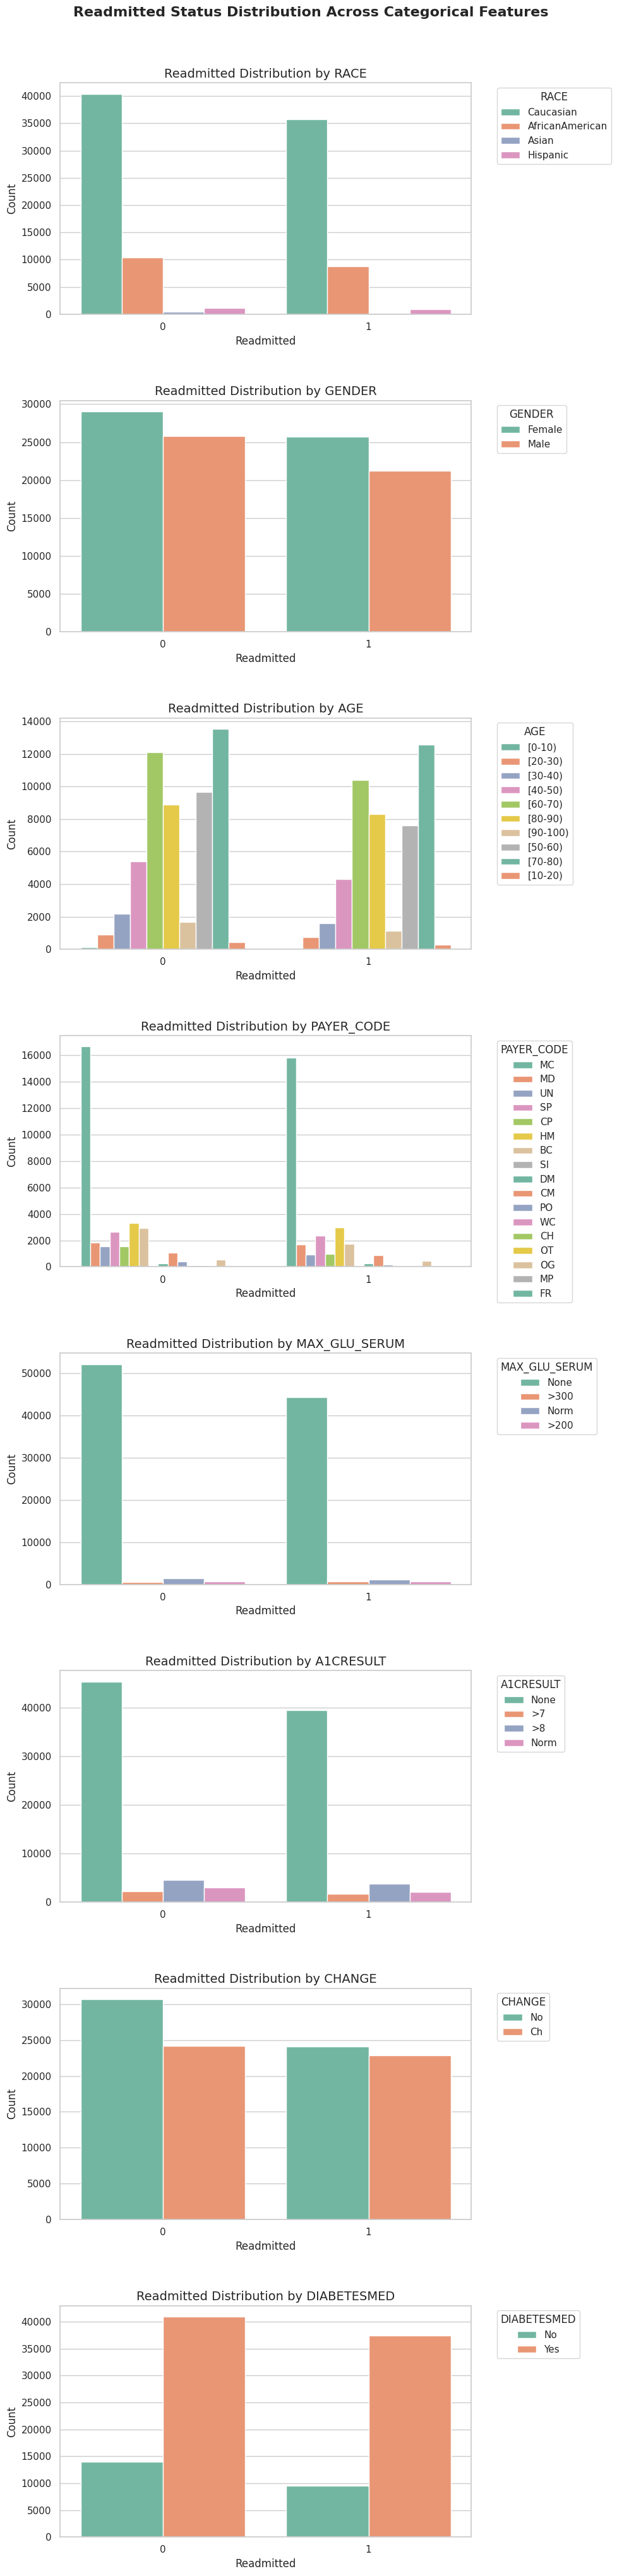

In [1390]:
# Readmissions hued per non-medication categorical features

# Layout Setup
sns.set(style="whitegrid")
num_features = len(cat_nonmed_plotting)
figsize = (
    10,
    5 * num_features,
)  # Height is scaled by the number of features for clarity

# Create a figure to hold the subplots
fig = plt.figure(figsize=figsize)

# Iterate over each categorical feature to create a subplot
for idx, cat_col in enumerate(cat_nonmed_plotting):
    ax = fig.add_subplot(num_features, 1, idx + 1)
    sns.countplot(data=df, x="READMITTED", hue=cat_col, palette="Set2", ax=ax)

    # Improve subplot aesthetics
    ax.set_ylabel("Count")
    ax.set_xlabel("Readmitted")
    ax.set_title(f"Readmitted Distribution by {cat_col}", fontsize=14)
    ax.legend(title=cat_col, bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a main title
fig.suptitle(
    "Readmitted Status Distribution Across Categorical Features",
    fontsize=16,
    fontweight="bold",
    y=1.02,
)

plt.show()


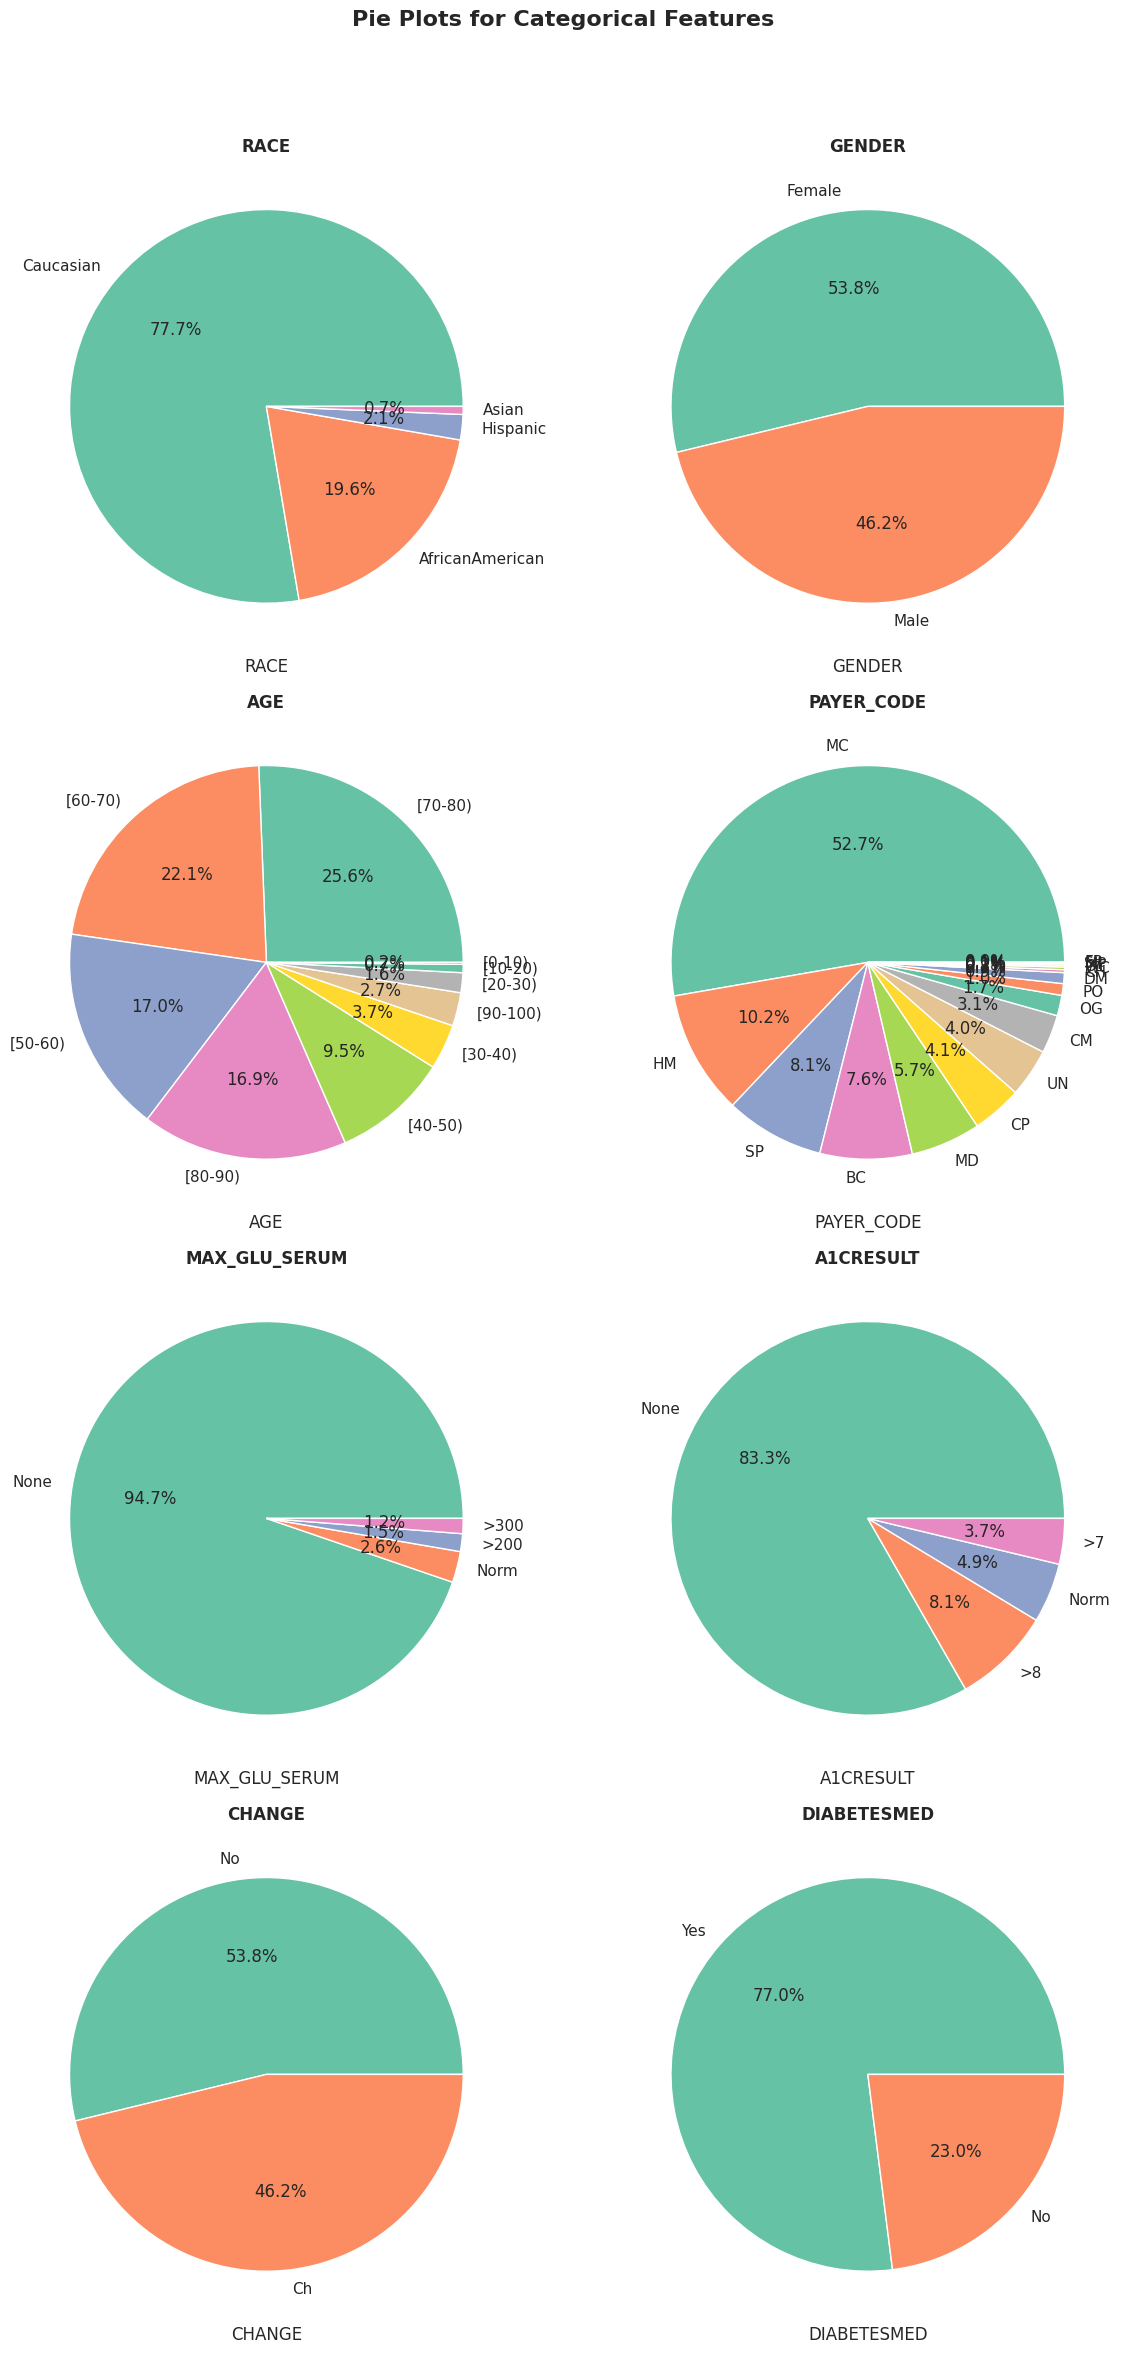

In [1391]:
# PIE CHARTS

figsize = (12, len(cat_nonmed_plotting) * 3)  # Adjusted for better visualization
n_cols = 2  # Number of columns in the subplot grid
n_rows = len(cat_nonmed_plotting) // n_cols + (
    len(cat_nonmed_plotting) % n_cols > 0
)  # Add an extra row if there's an odd number

fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

for idx, cat_col in enumerate(cat_nonmed_plotting):
    row = idx // n_cols
    col_idx = idx % n_cols
    ax = (
        axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    )  # Adjust for when there's only one row
    df[cat_col].value_counts().plot.pie(
        ax=ax, autopct="%.1f%%", colors=sns.color_palette("Set2")
    )

    # Improve subplot aesthetics
    ax.set_ylabel("")
    ax.set_xlabel(cat_col)
    ax.set_title(f"{cat_col}", loc="center", weight="bold", fontsize=12)

# Hide any unused subplots
if len(cat_nonmed_plotting) % n_cols != 0:
    for idx in range(len(cat_nonmed_plotting), n_rows * n_cols):
        fig.delaxes(axes.flatten()[idx])

# Adjust the layout and add a title
fig.suptitle(
    "Pie Plots for Categorical Features", ha="center", fontweight="bold", fontsize=16
)

plt.tight_layout(
    rect=[0, 0, 1, 0.95]
)  # Adjust the rect parameter to make space for the title

plt.show()


### 3/ Identification columns


In [1392]:
id_cols


['ENCOUNTER_ID',
 'PATIENT_NBR',
 'DISCHARGE_DISPOSITION_ID',
 'ADMISSION_SOURCE_ID',
 'ADMISSION_TYPE_ID']

In [1393]:
IDs_mapping_filepath = '/content/drive/My Drive/CODE/24UCL/term2/AAI/CW1/data/IDs_mapping.csv'
IDs_mapping = pd.read_csv(IDs_mapping_filepath)


In [1394]:
IDs_mapping["admission_type_id"].unique()


array(['1', '2', '3', '4', '5', '6', '7', '8', nan,
       'discharge_disposition_id', '9', '10', '11', '12', '13', '14',
       '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '30', '27', '28', '29', 'admission_source_id'], dtype=object)

In [1395]:
len(IDs_mapping)


67

In [1396]:
# Define a function to create a dictionary from a list of lines
def create_dict_from_lines(lines):
    result_dict = {}
    for line in lines:
        parts = line.split(",")
        if len(parts) == 2:  # Ensure there are exactly two elements to unpack
            key, value = parts
            result_dict[key.strip()] = value.strip()
    return result_dict


# Initialize outputs
admission_type_dict = {}
admission_source_dict = {}
discharge_disposition_dict = {}
current_dict = None

# Read the file line by line and process it
with open(IDs_mapping_filepath, "r") as file:
    for line in file:
        line = line.strip()
        if "admission_type_id" in line:
            current_dict = admission_type_dict
        elif "discharge_disposition_id" in line:
            current_dict = discharge_disposition_dict
        elif "admission_source_id" in line:
            current_dict = admission_source_dict
        elif line and current_dict is not None:
            # Skip lines that don't have a comma (e.g., empty lines or malformatted)
            if "," not in line:
                continue
            # Add the entry to the current dictionary
            key, value = line.split(",", 1)
            current_dict[key.strip()] = value.strip()

# Outputs: admission_type_dict, discharge_disposition_dict, admission_source_dict


#### a. Admission type disposition


In [1397]:
admission_type_dict


{'1': 'Emergency',
 '2': 'Urgent',
 '3': 'Elective',
 '4': 'Newborn',
 '5': 'Not Available',
 '6': 'NULL',
 '7': 'Trauma Center',
 '8': 'Not Mapped',
 '': ''}

In [1398]:
admission_type_dict = {str(key): val for key, val in admission_type_dict.items()}


In [1399]:
df_admission_type = df[
    [
        "ENCOUNTER_ID",
        "PATIENT_NBR",
        "READMITTED",
        "ADMISSION_TYPE_ID",
    ]
]
df_admission_type.head()


ENCOUNTER_ID  PATIENT_NBR  READMITTED  ADMISSION_TYPE_ID
0       2278392      8222157           0                  6
1        149190     55629189           1                  1
2         64410     86047875           0                  1
3        500364     82442376           0                  1
4         16680     42519267           0                  1

In [1400]:
# Convert the 'DISCHARGE_DISPOSITION_ID' to string
df_admission_type.loc[:, "ADMISSION_TYPE_ID"] = df_admission_type[
    "ADMISSION_TYPE_ID"
].astype(str)


<ipython-input-1400-7a3408a2561c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_admission_type.loc[:, "ADMISSION_TYPE_ID"] = df_admission_type[


In [1401]:
# Use .loc to ensure you're modifying the original DataFrame
df_admission_type.loc[:, "ADMISSION_TYPE_DESCRIPTION"] = df_admission_type[
    "ADMISSION_TYPE_ID"
].map(admission_type_dict)

# Display the first few rows to verify the changes
df_admission_type.head()


<ipython-input-1401-5a2f567c15cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_admission_type.loc[:, "ADMISSION_TYPE_DESCRIPTION"] = df_admission_type[


ENCOUNTER_ID  PATIENT_NBR  READMITTED ADMISSION_TYPE_ID  \
0       2278392      8222157           0                 6   
1        149190     55629189           1                 1   
2         64410     86047875           0                 1   
3        500364     82442376           0                 1   
4         16680     42519267           0                 1   

  ADMISSION_TYPE_DESCRIPTION  
0                       NULL  
1                  Emergency  
2                  Emergency  
3                  Emergency  
4                  Emergency

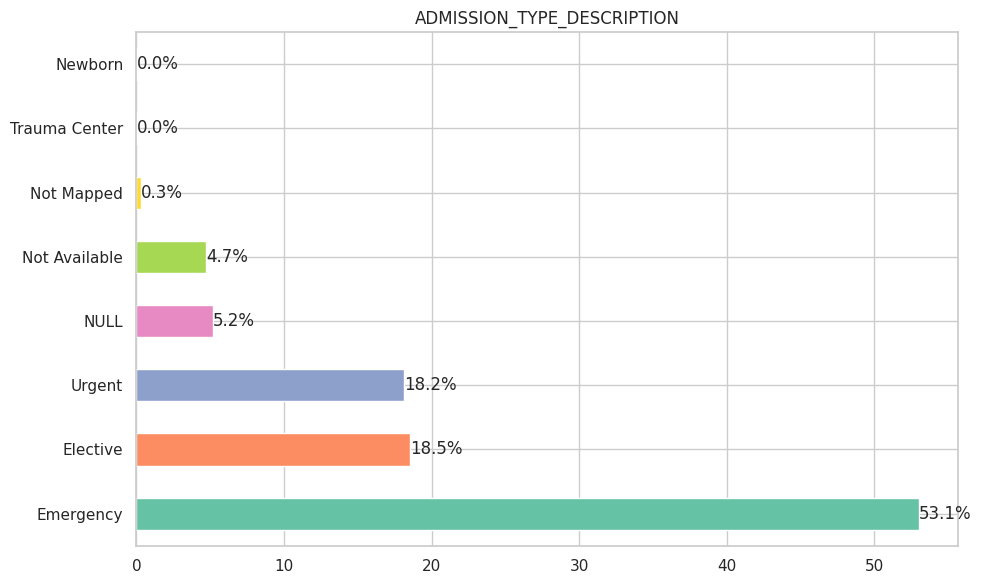

In [1402]:
# Set up the matplotlib figure with 1 row and 1 column
fig, ax = plt.subplots(figsize=(10, 6))

# DISCHARGE_DISPOSITION_DESCRIPTION bar plot
counts_discharge = (
    df_admission_type["ADMISSION_TYPE_DESCRIPTION"].value_counts(normalize=True) * 100
)
filtered_counts_admission_type = counts_discharge[counts_discharge > 0]
filtered_counts_admission_type.plot(kind="barh", color=sns.color_palette("Set2"), ax=ax)
ax.set_title("ADMISSION_TYPE_DESCRIPTION")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_admission_type):
    ax.text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


In [1403]:
# Count the occurrences of each 'ADMISSION_TYPE_ID'
admission_type_counts = df_admission_type["ADMISSION_TYPE_ID"].value_counts(
    ascending=True
)

# Create a DataFrame with 'ADMISSION_TYPE_ID' and its count
admission_type_counts_df = admission_type_counts.reset_index()
admission_type_counts_df.columns = ["ADMISSION_TYPE_ID", "COUNT"]

# Merge with the descriptions to get a full table
admission_type_description_df = df_admission_type[
    ["ADMISSION_TYPE_ID", "ADMISSION_TYPE_DESCRIPTION"]
].drop_duplicates()
admission_type_table = admission_type_counts_df.merge(
    admission_type_description_df, on="ADMISSION_TYPE_ID", how="left"
)

# Sort the table by the count of 'ADMISSION_TYPE_ID' from least to most present
admission_type_table_sorted = admission_type_table.sort_values(by="COUNT")
admission_type_table_sorted[
    ["ADMISSION_TYPE_DESCRIPTION", "ADMISSION_TYPE_ID", "COUNT"]
]


ADMISSION_TYPE_DESCRIPTION ADMISSION_TYPE_ID  COUNT
0                    Newborn                 4     10
1              Trauma Center                 7     21
2                 Not Mapped                 8    320
3              Not Available                 5   4785
4                       NULL                 6   5291
5                     Urgent                 2  18480
6                   Elective                 3  18869
7                  Emergency                 1  53990

#### a. Admission source disposition


In [1404]:
admission_source_dict


{'1': 'Physician Referral',
 '2': 'Clinic Referral',
 '3': 'HMO Referral',
 '4': 'Transfer from a hospital',
 '5': 'Transfer from a Skilled Nursing Facility (SNF)',
 '6': 'Transfer from another health care facility',
 '7': 'Emergency Room',
 '8': 'Court/Law Enforcement',
 '9': 'Not Available',
 '10': 'Transfer from critial access hospital',
 '11': 'Normal Delivery',
 '12': 'Premature Delivery',
 '13': 'Sick Baby',
 '14': 'Extramural Birth',
 '15': 'Not Available',
 '17': 'NULL',
 '18': 'Transfer From Another Home Health Agency',
 '19': 'Readmission to Same Home Health Agency',
 '20': 'Not Mapped',
 '21': 'Unknown/Invalid',
 '22': 'Transfer from hospital inpt/same fac reslt in a sep claim',
 '23': 'Born inside this hospital',
 '24': 'Born outside this hospital',
 '25': 'Transfer from Ambulatory Surgery Center',
 '26': 'Transfer from Hospice'}

In [1405]:
admission_source_dict = {str(key): val for key, val in admission_source_dict.items()}


In [1406]:
df_admission_source = df[
    [
        "ENCOUNTER_ID",
        "PATIENT_NBR",
        "READMITTED",
        "ADMISSION_SOURCE_ID",
    ]
]
df_admission_source.head()


ENCOUNTER_ID  PATIENT_NBR  READMITTED  ADMISSION_SOURCE_ID
0       2278392      8222157           0                    1
1        149190     55629189           1                    7
2         64410     86047875           0                    7
3        500364     82442376           0                    7
4         16680     42519267           0                    7

In [1407]:
# Convert the 'DISCHARGE_DISPOSITION_ID' to string
df_admission_source.loc[:, "ADMISSION_SOURCE_ID"] = df_admission_source[
    "ADMISSION_SOURCE_ID"
].astype(str)


<ipython-input-1407-6001abd565ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_admission_source.loc[:, "ADMISSION_SOURCE_ID"] = df_admission_source[


In [1408]:
# Use .loc to ensure you're modifying the original DataFrame
df_admission_source.loc[:, "ADMISSION_SOURCE_DESCRIPTION"] = df_admission_source[
    "ADMISSION_SOURCE_ID"
].map(admission_source_dict)

# Display the first few rows to verify the changes
df_admission_source.head()


<ipython-input-1408-968c373c0e0c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_admission_source.loc[:, "ADMISSION_SOURCE_DESCRIPTION"] = df_admission_source[


ENCOUNTER_ID  PATIENT_NBR  READMITTED ADMISSION_SOURCE_ID  \
0       2278392      8222157           0                   1   
1        149190     55629189           1                   7   
2         64410     86047875           0                   7   
3        500364     82442376           0                   7   
4         16680     42519267           0                   7   

  ADMISSION_SOURCE_DESCRIPTION  
0           Physician Referral  
1               Emergency Room  
2               Emergency Room  
3               Emergency Room  
4               Emergency Room

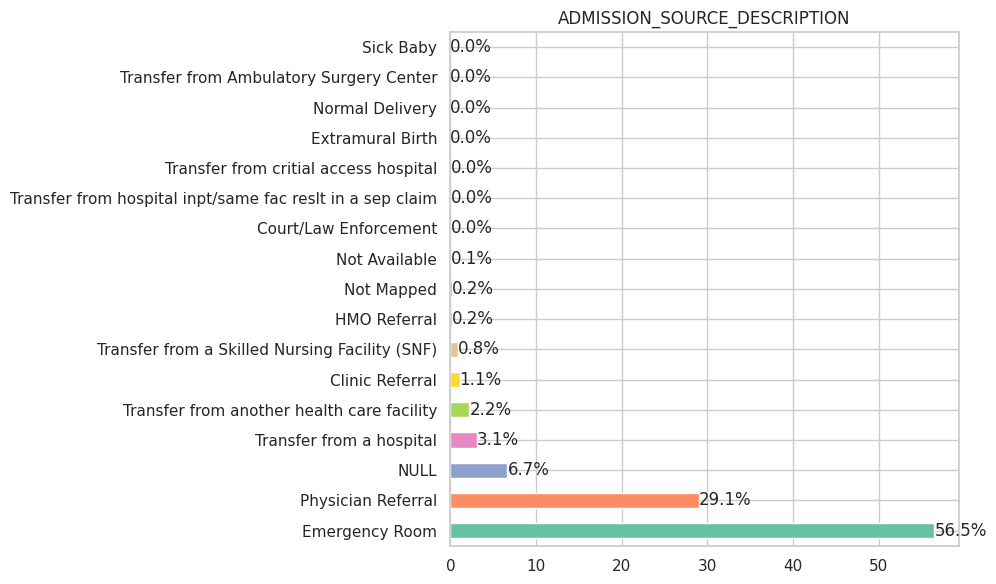

In [1409]:
# Set up the matplotlib figure with 1 row and 1 column
fig, ax = plt.subplots(figsize=(10, 6))

# DISCHARGE_DISPOSITION_DESCRIPTION bar plot
counts_admission_source = (
    df_admission_source["ADMISSION_SOURCE_DESCRIPTION"].value_counts(normalize=True)
    * 100
)
filtered_counts_admission_source = counts_admission_source[counts_admission_source > 0]
filtered_counts_admission_source.plot(
    kind="barh", color=sns.color_palette("Set2"), ax=ax
)
ax.set_title("ADMISSION_SOURCE_DESCRIPTION")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_admission_source):
    ax.text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


In [1410]:

# Count the occurrences of each 'ADMISSION_SOURCE_ID'
admission_source_counts = df_admission_source["ADMISSION_SOURCE_ID"].value_counts(
    ascending=True
)

# Create a DataFrame with 'ADMISSION_SOURCE_ID' and its count
admission_source_counts_df = admission_source_counts.reset_index()
admission_source_counts_df.columns = ["ADMISSION_SOURCE_ID", "COUNT"]

# Merge with the descriptions to get a full table
admission_source_description_df = df_admission_source[
    ["ADMISSION_SOURCE_ID", "ADMISSION_SOURCE_DESCRIPTION"]
].drop_duplicates()
admission_source_table = admission_source_counts_df.merge(
    admission_source_description_df, on="ADMISSION_SOURCE_ID", how="left"
)

# Sort the table by the count of 'ADMISSION_SOURCE_ID' from least to most present
admission_source_table_sorted = admission_source_table.sort_values(by="COUNT")
admission_source_table_sorted[
    ["ADMISSION_SOURCE_DESCRIPTION", "ADMISSION_SOURCE_ID", "COUNT"]
]


ADMISSION_SOURCE_DESCRIPTION ADMISSION_SOURCE_ID  \
0                                           Sick Baby                  13   
1                                     Normal Delivery                  11   
2             Transfer from Ambulatory Surgery Center                  25   
3                                    Extramural Birth                  14   
4               Transfer from critial access hospital                  10   
5   Transfer from hospital inpt/same fac reslt in ...                  22   
6                               Court/Law Enforcement                   8   
7                                       Not Available                   9   
8                                          Not Mapped                  20   
9                                        HMO Referral                   3   
10     Transfer from a Skilled Nursing Facility (SNF)                   5   
11                                    Clinic Referral                   2   
12         Transfer from another health care facility                   6   
13                           Transfer from a hospital                   4   
14                                               NULL                  17   
15                                 Physician Referral                   1   
16                                     Emergency Room                   7   

    COUNT  
0       1  
1       2  
2       2  
3       2  
4       8  
5      12  
6      16  
7     125  
8     161  
9     187  
10    855  
11   1104  
12   2264  
13   3187  
14   6781  
15  29565  
16  57494

#### c. Discharge disposition


In [1411]:
discharge_disposition_dict


{'1': 'Discharged to home',
 '2': 'Discharged/transferred to another short term hospital',
 '3': 'Discharged/transferred to SNF',
 '4': 'Discharged/transferred to ICF',
 '5': 'Discharged/transferred to another type of inpatient care institution',
 '6': 'Discharged/transferred to home with home health service',
 '7': 'Left AMA',
 '8': 'Discharged/transferred to home under care of Home IV provider',
 '9': 'Admitted as an inpatient to this hospital',
 '10': 'Neonate discharged to another hospital for neonatal aftercare',
 '11': 'Expired',
 '12': 'Still patient or expected to return for outpatient services',
 '13': 'Hospice / home',
 '14': 'Hospice / medical facility',
 '15': 'Discharged/transferred within this institution to Medicare approved swing bed',
 '16': 'Discharged/transferred/referred another institution for outpatient services',
 '17': 'Discharged/transferred/referred to this institution for outpatient services',
 '18': 'NULL',
 '19': '"Expired at home. Medicaid only, hospice."'

In [1412]:
discharge_disposition_dict = {
    str(key): val for key, val in discharge_disposition_dict.items()
}


In [1413]:
df_discharge = df[
    [
        "ENCOUNTER_ID",
        "PATIENT_NBR",
        "READMITTED",
        "DISCHARGE_DISPOSITION_ID",
    ]
]
df_discharge.head()


ENCOUNTER_ID  PATIENT_NBR  READMITTED  DISCHARGE_DISPOSITION_ID
0       2278392      8222157           0                        25
1        149190     55629189           1                         1
2         64410     86047875           0                         1
3        500364     82442376           0                         1
4         16680     42519267           0                         1

In [1414]:
print(df_discharge["DISCHARGE_DISPOSITION_ID"].dtype)


int64


In [1415]:
# Convert the 'DISCHARGE_DISPOSITION_ID' to string
df_discharge.loc[:, "DISCHARGE_DISPOSITION_ID"] = df_discharge[
    "DISCHARGE_DISPOSITION_ID"
].astype(str)


<ipython-input-1415-0099177df9f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_discharge.loc[:, "DISCHARGE_DISPOSITION_ID"] = df_discharge[


In [1416]:
# Use .loc to ensure you're modifying the original DataFrame
df_discharge.loc[:, "DISCHARGE_DISPOSITION_DESCRIPTION"] = df_discharge[
    "DISCHARGE_DISPOSITION_ID"
].map(discharge_disposition_dict)

# Display the first few rows to verify the changes
df_discharge.head()


<ipython-input-1416-19e00a96bbd9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_discharge.loc[:, "DISCHARGE_DISPOSITION_DESCRIPTION"] = df_discharge[


ENCOUNTER_ID  PATIENT_NBR  READMITTED DISCHARGE_DISPOSITION_ID  \
0       2278392      8222157           0                       25   
1        149190     55629189           1                        1   
2         64410     86047875           0                        1   
3        500364     82442376           0                        1   
4         16680     42519267           0                        1   

  DISCHARGE_DISPOSITION_DESCRIPTION  
0                        Not Mapped  
1                Discharged to home  
2                Discharged to home  
3                Discharged to home  
4                Discharged to home

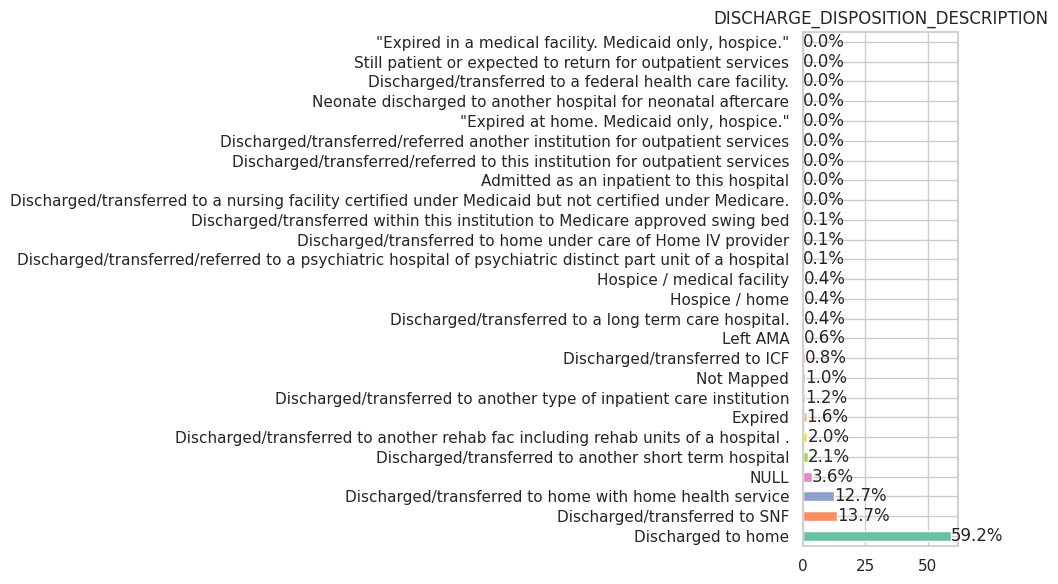

In [1417]:
# Set up the matplotlib figure with 1 row and 1 column
fig, ax = plt.subplots(figsize=(10, 6))

# DISCHARGE_DISPOSITION_DESCRIPTION bar plot
counts_discharge = (
    df_discharge["DISCHARGE_DISPOSITION_DESCRIPTION"].value_counts(normalize=True) * 100
)
filtered_counts_discharge = counts_discharge[counts_discharge > 0]
filtered_counts_discharge.plot(kind="barh", color=sns.color_palette("Set2"), ax=ax)
ax.set_title("DISCHARGE_DISPOSITION_DESCRIPTION")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_discharge):
    ax.text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


In [1418]:
# Count the occurrences of each 'DISCHARGE_DISPOSITION_ID'
discharge_counts = df_discharge["DISCHARGE_DISPOSITION_ID"].value_counts(ascending=True)

# Create a DataFrame with 'DISCHARGE_DISPOSITION_ID' and its count
discharge_counts_df = discharge_counts.reset_index()
discharge_counts_df.columns = ["DISCHARGE_DISPOSITION_ID", "COUNT"]

# Merge with the descriptions to get a full table
discharge_description_df = df_discharge[
    ["DISCHARGE_DISPOSITION_ID", "DISCHARGE_DISPOSITION_DESCRIPTION"]
].drop_duplicates()
discharge_table = discharge_counts_df.merge(
    discharge_description_df, on="DISCHARGE_DISPOSITION_ID", how="left"
)

# Sort the table by the count of 'DISCHARGE_DISPOSITION_ID' from least to most present
discharge_table_sorted = discharge_table.sort_values(by="COUNT")
discharge_table_sorted[
    ["DISCHARGE_DISPOSITION_DESCRIPTION", "DISCHARGE_DISPOSITION_ID", "COUNT"]
]


DISCHARGE_DISPOSITION_DESCRIPTION  \
0   "Expired in a medical facility. Medicaid only,...   
1   Still patient or expected to return for outpat...   
2   Discharged/transferred to a federal health car...   
3   Neonate discharged to another hospital for neo...   
4          "Expired at home. Medicaid only, hospice."   
5   Discharged/transferred/referred another instit...   
6   Discharged/transferred/referred to this instit...   
7           Admitted as an inpatient to this hospital   
8   Discharged/transferred to a nursing facility c...   
9   Discharged/transferred within this institution...   
10  Discharged/transferred to home under care of H...   
11  Discharged/transferred/referred to a psychiatr...   
12                         Hospice / medical facility   
13                                     Hospice / home   
14  Discharged/transferred to a long term care hos...   
15                                           Left AMA   
16                      Discharged/transferred to ICF   
17                                         Not Mapped   
18  Discharged/transferred to another type of inpa...   
19                                            Expired   
20  Discharged/transferred to another rehab fac in...   
21  Discharged/transferred to another short term h...   
22                                               NULL   
23  Discharged/transferred to home with home healt...   
24                      Discharged/transferred to SNF   
25                                 Discharged to home   

   DISCHARGE_DISPOSITION_ID  COUNT  
0                        20      2  
1                        12      3  
2                        27      5  
3                        10      6  
4                        19      8  
5                        16     11  
6                        17     14  
7                         9     21  
8                        24     48  
9                        15     63  
10                        8    108  
11                       28    139  
12                       14    372  
13                       13    399  
14                       23    412  
15                        7    623  
16                        4    815  
17                       25    989  
18                        5   1184  
19                       11   1642  
20                       22   1993  
21                        2   2128  
22                       18   3691  
23                        6  12902  
24                        3  13954  
25                        1  60234

In [1419]:
discharge_ids_outofscope = [11, 13, 14, 19, 20, 21]
# Patients "Expired" or in Hospice


In [1420]:
discharge_disposition_dict


{'1': 'Discharged to home',
 '2': 'Discharged/transferred to another short term hospital',
 '3': 'Discharged/transferred to SNF',
 '4': 'Discharged/transferred to ICF',
 '5': 'Discharged/transferred to another type of inpatient care institution',
 '6': 'Discharged/transferred to home with home health service',
 '7': 'Left AMA',
 '8': 'Discharged/transferred to home under care of Home IV provider',
 '9': 'Admitted as an inpatient to this hospital',
 '10': 'Neonate discharged to another hospital for neonatal aftercare',
 '11': 'Expired',
 '12': 'Still patient or expected to return for outpatient services',
 '13': 'Hospice / home',
 '14': 'Hospice / medical facility',
 '15': 'Discharged/transferred within this institution to Medicare approved swing bed',
 '16': 'Discharged/transferred/referred another institution for outpatient services',
 '17': 'Discharged/transferred/referred to this institution for outpatient services',
 '18': 'NULL',
 '19': '"Expired at home. Medicaid only, hospice."'

In [1421]:
discharge_disposition_dict = {
    str(key): val for key, val in discharge_disposition_dict.items()
}


In [1422]:
df_discharge = df[
    [
        "ENCOUNTER_ID",
        "PATIENT_NBR",
        "READMITTED",
        "DISCHARGE_DISPOSITION_ID",
    ]
]
df_discharge.head()


ENCOUNTER_ID  PATIENT_NBR  READMITTED  DISCHARGE_DISPOSITION_ID
0       2278392      8222157           0                        25
1        149190     55629189           1                         1
2         64410     86047875           0                         1
3        500364     82442376           0                         1
4         16680     42519267           0                         1

In [1423]:
print(df_discharge["DISCHARGE_DISPOSITION_ID"].dtype)


int64


In [1424]:
# Convert the 'DISCHARGE_DISPOSITION_ID' to string
df_discharge.loc[:, "DISCHARGE_DISPOSITION_ID"] = df_discharge[
    "DISCHARGE_DISPOSITION_ID"
].astype(str)


<ipython-input-1424-0099177df9f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_discharge.loc[:, "DISCHARGE_DISPOSITION_ID"] = df_discharge[


In [1425]:
# Use .loc to ensure you're modifying the original DataFrame
df_discharge.loc[:, "DISCHARGE_DISPOSITION_DESCRIPTION"] = df_discharge[
    "DISCHARGE_DISPOSITION_ID"
].map(discharge_disposition_dict)

# Display the first few rows to verify the changes
df_discharge.head()


<ipython-input-1425-19e00a96bbd9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_discharge.loc[:, "DISCHARGE_DISPOSITION_DESCRIPTION"] = df_discharge[


ENCOUNTER_ID  PATIENT_NBR  READMITTED DISCHARGE_DISPOSITION_ID  \
0       2278392      8222157           0                       25   
1        149190     55629189           1                        1   
2         64410     86047875           0                        1   
3        500364     82442376           0                        1   
4         16680     42519267           0                        1   

  DISCHARGE_DISPOSITION_DESCRIPTION  
0                        Not Mapped  
1                Discharged to home  
2                Discharged to home  
3                Discharged to home  
4                Discharged to home

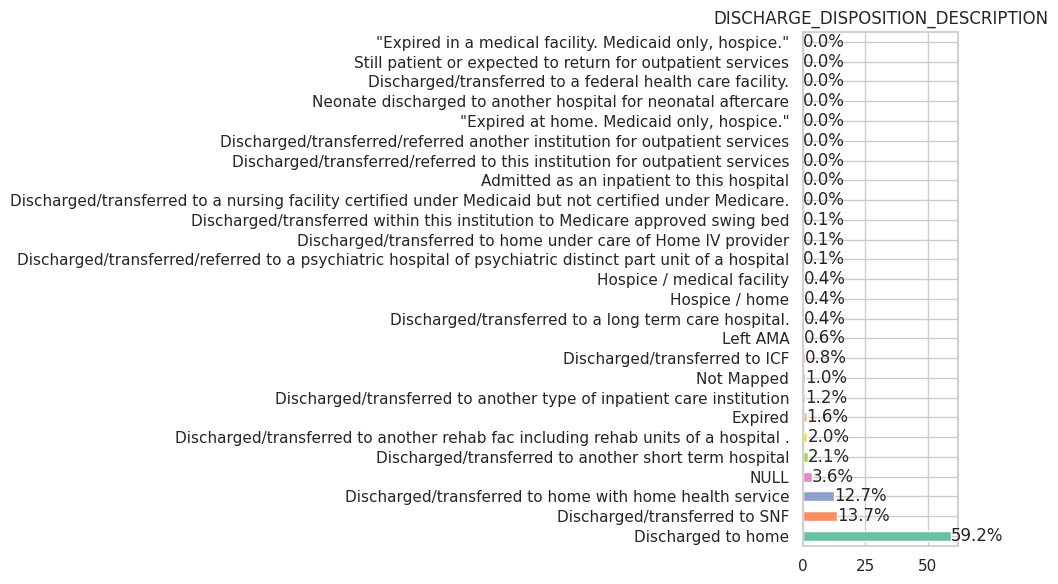

In [1426]:
# Set up the matplotlib figure with 1 row and 1 column
fig, ax = plt.subplots(figsize=(10, 6))

# DISCHARGE_DISPOSITION_DESCRIPTION bar plot
counts_discharge = (
    df_discharge["DISCHARGE_DISPOSITION_DESCRIPTION"].value_counts(normalize=True) * 100
)
filtered_counts_discharge = counts_discharge[counts_discharge > 0]
filtered_counts_discharge.plot(kind="barh", color=sns.color_palette("Set2"), ax=ax)
ax.set_title("DISCHARGE_DISPOSITION_DESCRIPTION")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_discharge):
    ax.text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


In [1427]:
# Count the occurrences of each 'DISCHARGE_DISPOSITION_ID'
discharge_counts = df_discharge["DISCHARGE_DISPOSITION_ID"].value_counts(ascending=True)

# Create a DataFrame with 'DISCHARGE_DISPOSITION_ID' and its count
discharge_counts_df = discharge_counts.reset_index()
discharge_counts_df.columns = ["DISCHARGE_DISPOSITION_ID", "COUNT"]

# Merge with the descriptions to get a full table
discharge_description_df = df_discharge[
    ["DISCHARGE_DISPOSITION_ID", "DISCHARGE_DISPOSITION_DESCRIPTION"]
].drop_duplicates()
discharge_table = discharge_counts_df.merge(
    discharge_description_df, on="DISCHARGE_DISPOSITION_ID", how="left"
)

# Sort the table by the count of 'DISCHARGE_DISPOSITION_ID' from least to most present
discharge_table_sorted = discharge_table.sort_values(by="COUNT")
discharge_table_sorted[
    ["DISCHARGE_DISPOSITION_DESCRIPTION", "DISCHARGE_DISPOSITION_ID", "COUNT"]
]


DISCHARGE_DISPOSITION_DESCRIPTION  \
0   "Expired in a medical facility. Medicaid only,...   
1   Still patient or expected to return for outpat...   
2   Discharged/transferred to a federal health car...   
3   Neonate discharged to another hospital for neo...   
4          "Expired at home. Medicaid only, hospice."   
5   Discharged/transferred/referred another instit...   
6   Discharged/transferred/referred to this instit...   
7           Admitted as an inpatient to this hospital   
8   Discharged/transferred to a nursing facility c...   
9   Discharged/transferred within this institution...   
10  Discharged/transferred to home under care of H...   
11  Discharged/transferred/referred to a psychiatr...   
12                         Hospice / medical facility   
13                                     Hospice / home   
14  Discharged/transferred to a long term care hos...   
15                                           Left AMA   
16                      Discharged/transferred to ICF   
17                                         Not Mapped   
18  Discharged/transferred to another type of inpa...   
19                                            Expired   
20  Discharged/transferred to another rehab fac in...   
21  Discharged/transferred to another short term h...   
22                                               NULL   
23  Discharged/transferred to home with home healt...   
24                      Discharged/transferred to SNF   
25                                 Discharged to home   

   DISCHARGE_DISPOSITION_ID  COUNT  
0                        20      2  
1                        12      3  
2                        27      5  
3                        10      6  
4                        19      8  
5                        16     11  
6                        17     14  
7                         9     21  
8                        24     48  
9                        15     63  
10                        8    108  
11                       28    139  
12                       14    372  
13                       13    399  
14                       23    412  
15                        7    623  
16                        4    815  
17                       25    989  
18                        5   1184  
19                       11   1642  
20                       22   1993  
21                        2   2128  
22                       18   3691  
23                        6  12902  
24                        3  13954  
25                        1  60234

In [1428]:
discharge_ids_outofscope = [11, 13, 14, 19, 20, 21]
# Patients "Expired" or in Hospice


In [1429]:
discharge_disposition_dict


{'1': 'Discharged to home',
 '2': 'Discharged/transferred to another short term hospital',
 '3': 'Discharged/transferred to SNF',
 '4': 'Discharged/transferred to ICF',
 '5': 'Discharged/transferred to another type of inpatient care institution',
 '6': 'Discharged/transferred to home with home health service',
 '7': 'Left AMA',
 '8': 'Discharged/transferred to home under care of Home IV provider',
 '9': 'Admitted as an inpatient to this hospital',
 '10': 'Neonate discharged to another hospital for neonatal aftercare',
 '11': 'Expired',
 '12': 'Still patient or expected to return for outpatient services',
 '13': 'Hospice / home',
 '14': 'Hospice / medical facility',
 '15': 'Discharged/transferred within this institution to Medicare approved swing bed',
 '16': 'Discharged/transferred/referred another institution for outpatient services',
 '17': 'Discharged/transferred/referred to this institution for outpatient services',
 '18': 'NULL',
 '19': '"Expired at home. Medicaid only, hospice."'

In [1430]:
discharge_disposition_dict = {
    str(key): val for key, val in discharge_disposition_dict.items()
}


In [1431]:
df_discharge = df[
    [
        "ENCOUNTER_ID",
        "PATIENT_NBR",
        "READMITTED",
        "DISCHARGE_DISPOSITION_ID",
    ]
]
df_discharge.head()


ENCOUNTER_ID  PATIENT_NBR  READMITTED  DISCHARGE_DISPOSITION_ID
0       2278392      8222157           0                        25
1        149190     55629189           1                         1
2         64410     86047875           0                         1
3        500364     82442376           0                         1
4         16680     42519267           0                         1

In [1432]:
print(df_discharge["DISCHARGE_DISPOSITION_ID"].dtype)


int64


In [1433]:
# Convert the 'DISCHARGE_DISPOSITION_ID' to string
df_discharge.loc[:, "DISCHARGE_DISPOSITION_ID"] = df_discharge[
    "DISCHARGE_DISPOSITION_ID"
].astype(str)


<ipython-input-1433-0099177df9f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_discharge.loc[:, "DISCHARGE_DISPOSITION_ID"] = df_discharge[


In [1434]:
# Use .loc to ensure you're modifying the original DataFrame
df_discharge.loc[:, "DISCHARGE_DISPOSITION_DESCRIPTION"] = df_discharge[
    "DISCHARGE_DISPOSITION_ID"
].map(discharge_disposition_dict)

# Display the first few rows to verify the changes
df_discharge.head()


<ipython-input-1434-19e00a96bbd9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_discharge.loc[:, "DISCHARGE_DISPOSITION_DESCRIPTION"] = df_discharge[


ENCOUNTER_ID  PATIENT_NBR  READMITTED DISCHARGE_DISPOSITION_ID  \
0       2278392      8222157           0                       25   
1        149190     55629189           1                        1   
2         64410     86047875           0                        1   
3        500364     82442376           0                        1   
4         16680     42519267           0                        1   

  DISCHARGE_DISPOSITION_DESCRIPTION  
0                        Not Mapped  
1                Discharged to home  
2                Discharged to home  
3                Discharged to home  
4                Discharged to home

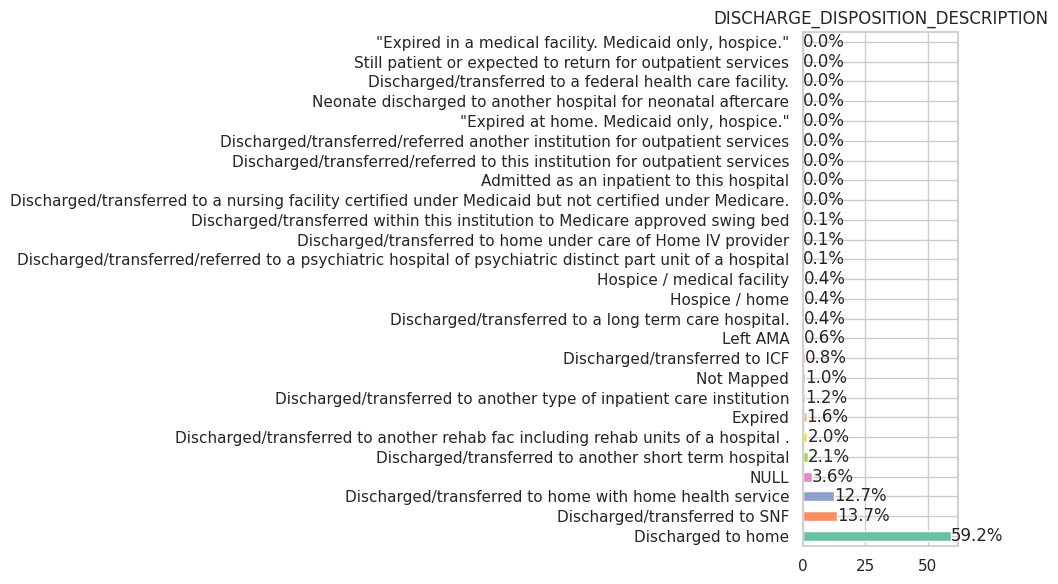

In [1435]:
# Set up the matplotlib figure with 1 row and 1 column
fig, ax = plt.subplots(figsize=(10, 6))

# DISCHARGE_DISPOSITION_DESCRIPTION bar plot
counts_discharge = (
    df_discharge["DISCHARGE_DISPOSITION_DESCRIPTION"].value_counts(normalize=True) * 100
)
filtered_counts_discharge = counts_discharge[counts_discharge > 0]
filtered_counts_discharge.plot(kind="barh", color=sns.color_palette("Set2"), ax=ax)
ax.set_title("DISCHARGE_DISPOSITION_DESCRIPTION")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_discharge):
    ax.text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


In [1436]:
# Count the occurrences of each 'DISCHARGE_DISPOSITION_ID'
discharge_counts = df_discharge["DISCHARGE_DISPOSITION_ID"].value_counts(ascending=True)

# Create a DataFrame with 'DISCHARGE_DISPOSITION_ID' and its count
discharge_counts_df = discharge_counts.reset_index()
discharge_counts_df.columns = ["DISCHARGE_DISPOSITION_ID", "COUNT"]

# Merge with the descriptions to get a full table
discharge_description_df = df_discharge[
    ["DISCHARGE_DISPOSITION_ID", "DISCHARGE_DISPOSITION_DESCRIPTION"]
].drop_duplicates()
discharge_table = discharge_counts_df.merge(
    discharge_description_df, on="DISCHARGE_DISPOSITION_ID", how="left"
)

# Sort the table by the count of 'DISCHARGE_DISPOSITION_ID' from least to most present
discharge_table_sorted = discharge_table.sort_values(by="COUNT")
discharge_table_sorted[
    ["DISCHARGE_DISPOSITION_DESCRIPTION", "DISCHARGE_DISPOSITION_ID", "COUNT"]
]


DISCHARGE_DISPOSITION_DESCRIPTION  \
0   "Expired in a medical facility. Medicaid only,...   
1   Still patient or expected to return for outpat...   
2   Discharged/transferred to a federal health car...   
3   Neonate discharged to another hospital for neo...   
4          "Expired at home. Medicaid only, hospice."   
5   Discharged/transferred/referred another instit...   
6   Discharged/transferred/referred to this instit...   
7           Admitted as an inpatient to this hospital   
8   Discharged/transferred to a nursing facility c...   
9   Discharged/transferred within this institution...   
10  Discharged/transferred to home under care of H...   
11  Discharged/transferred/referred to a psychiatr...   
12                         Hospice / medical facility   
13                                     Hospice / home   
14  Discharged/transferred to a long term care hos...   
15                                           Left AMA   
16                      Discharged/transferred to ICF   
17                                         Not Mapped   
18  Discharged/transferred to another type of inpa...   
19                                            Expired   
20  Discharged/transferred to another rehab fac in...   
21  Discharged/transferred to another short term h...   
22                                               NULL   
23  Discharged/transferred to home with home healt...   
24                      Discharged/transferred to SNF   
25                                 Discharged to home   

   DISCHARGE_DISPOSITION_ID  COUNT  
0                        20      2  
1                        12      3  
2                        27      5  
3                        10      6  
4                        19      8  
5                        16     11  
6                        17     14  
7                         9     21  
8                        24     48  
9                        15     63  
10                        8    108  
11                       28    139  
12                       14    372  
13                       13    399  
14                       23    412  
15                        7    623  
16                        4    815  
17                       25    989  
18                        5   1184  
19                       11   1642  
20                       22   1993  
21                        2   2128  
22                       18   3691  
23                        6  12902  
24                        3  13954  
25                        1  60234

In [1437]:
discharge_ids_outofscope = [11, 13, 14, 19, 20, 21]
# Patients "Expired" or in Hospice


In [1438]:
discharge_disposition_dict


{'1': 'Discharged to home',
 '2': 'Discharged/transferred to another short term hospital',
 '3': 'Discharged/transferred to SNF',
 '4': 'Discharged/transferred to ICF',
 '5': 'Discharged/transferred to another type of inpatient care institution',
 '6': 'Discharged/transferred to home with home health service',
 '7': 'Left AMA',
 '8': 'Discharged/transferred to home under care of Home IV provider',
 '9': 'Admitted as an inpatient to this hospital',
 '10': 'Neonate discharged to another hospital for neonatal aftercare',
 '11': 'Expired',
 '12': 'Still patient or expected to return for outpatient services',
 '13': 'Hospice / home',
 '14': 'Hospice / medical facility',
 '15': 'Discharged/transferred within this institution to Medicare approved swing bed',
 '16': 'Discharged/transferred/referred another institution for outpatient services',
 '17': 'Discharged/transferred/referred to this institution for outpatient services',
 '18': 'NULL',
 '19': '"Expired at home. Medicaid only, hospice."'

In [1439]:
discharge_disposition_dict = {
    str(key): val for key, val in discharge_disposition_dict.items()
}


In [1440]:
df_discharge = df[
    [
        "ENCOUNTER_ID",
        "PATIENT_NBR",
        "READMITTED",
        "DISCHARGE_DISPOSITION_ID",
    ]
]
df_discharge.head()


ENCOUNTER_ID  PATIENT_NBR  READMITTED  DISCHARGE_DISPOSITION_ID
0       2278392      8222157           0                        25
1        149190     55629189           1                         1
2         64410     86047875           0                         1
3        500364     82442376           0                         1
4         16680     42519267           0                         1

In [1441]:
print(df_discharge["DISCHARGE_DISPOSITION_ID"].dtype)


int64


In [1442]:
# Convert the 'DISCHARGE_DISPOSITION_ID' to string
df_discharge.loc[:, "DISCHARGE_DISPOSITION_ID"] = df_discharge[
    "DISCHARGE_DISPOSITION_ID"
].astype(str)


<ipython-input-1442-0099177df9f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_discharge.loc[:, "DISCHARGE_DISPOSITION_ID"] = df_discharge[


In [1443]:
# Use .loc to ensure you're modifying the original DataFrame
df_discharge.loc[:, "DISCHARGE_DISPOSITION_DESCRIPTION"] = df_discharge[
    "DISCHARGE_DISPOSITION_ID"
].map(discharge_disposition_dict)

# Display the first few rows to verify the changes
df_discharge.head()


<ipython-input-1443-19e00a96bbd9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_discharge.loc[:, "DISCHARGE_DISPOSITION_DESCRIPTION"] = df_discharge[


ENCOUNTER_ID  PATIENT_NBR  READMITTED DISCHARGE_DISPOSITION_ID  \
0       2278392      8222157           0                       25   
1        149190     55629189           1                        1   
2         64410     86047875           0                        1   
3        500364     82442376           0                        1   
4         16680     42519267           0                        1   

  DISCHARGE_DISPOSITION_DESCRIPTION  
0                        Not Mapped  
1                Discharged to home  
2                Discharged to home  
3                Discharged to home  
4                Discharged to home

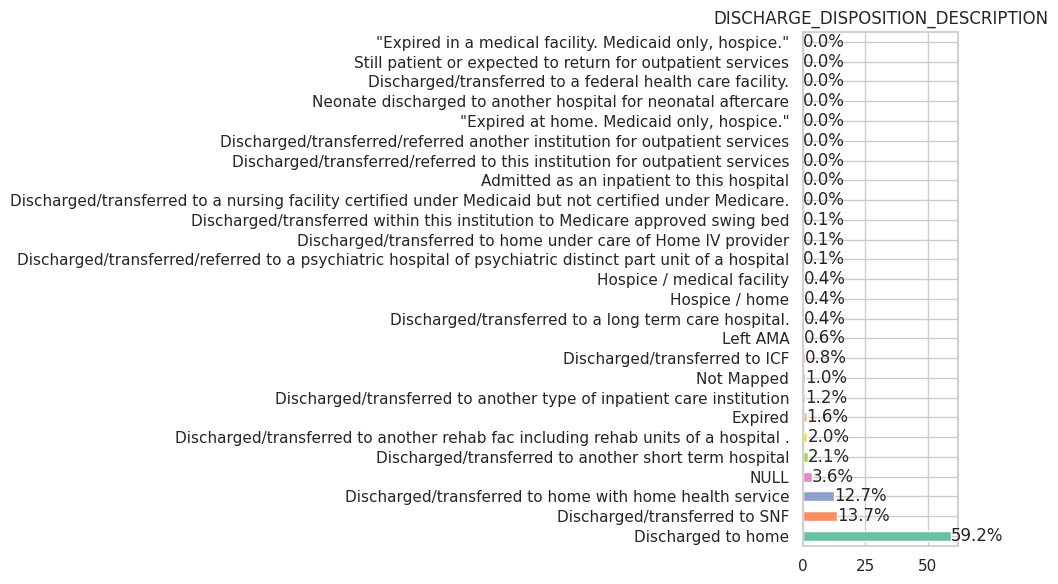

In [1444]:
# Set up the matplotlib figure with 1 row and 1 column
fig, ax = plt.subplots(figsize=(10, 6))

# DISCHARGE_DISPOSITION_DESCRIPTION bar plot
counts_discharge = (
    df_discharge["DISCHARGE_DISPOSITION_DESCRIPTION"].value_counts(normalize=True) * 100
)
filtered_counts_discharge = counts_discharge[counts_discharge > 0]
filtered_counts_discharge.plot(kind="barh", color=sns.color_palette("Set2"), ax=ax)
ax.set_title("DISCHARGE_DISPOSITION_DESCRIPTION")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_discharge):
    ax.text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


In [1445]:
# Count the occurrences of each 'DISCHARGE_DISPOSITION_ID'
discharge_counts = df_discharge["DISCHARGE_DISPOSITION_ID"].value_counts(ascending=True)

# Create a DataFrame with 'DISCHARGE_DISPOSITION_ID' and its count
discharge_counts_df = discharge_counts.reset_index()
discharge_counts_df.columns = ["DISCHARGE_DISPOSITION_ID", "COUNT"]

# Merge with the descriptions to get a full table
discharge_description_df = df_discharge[
    ["DISCHARGE_DISPOSITION_ID", "DISCHARGE_DISPOSITION_DESCRIPTION"]
].drop_duplicates()
discharge_table = discharge_counts_df.merge(
    discharge_description_df, on="DISCHARGE_DISPOSITION_ID", how="left"
)

# Sort the table by the count of 'DISCHARGE_DISPOSITION_ID' from least to most present
discharge_table_sorted = discharge_table.sort_values(by="COUNT")
discharge_table_sorted[
    ["DISCHARGE_DISPOSITION_DESCRIPTION", "DISCHARGE_DISPOSITION_ID", "COUNT"]
]


DISCHARGE_DISPOSITION_DESCRIPTION  \
0   "Expired in a medical facility. Medicaid only,...   
1   Still patient or expected to return for outpat...   
2   Discharged/transferred to a federal health car...   
3   Neonate discharged to another hospital for neo...   
4          "Expired at home. Medicaid only, hospice."   
5   Discharged/transferred/referred another instit...   
6   Discharged/transferred/referred to this instit...   
7           Admitted as an inpatient to this hospital   
8   Discharged/transferred to a nursing facility c...   
9   Discharged/transferred within this institution...   
10  Discharged/transferred to home under care of H...   
11  Discharged/transferred/referred to a psychiatr...   
12                         Hospice / medical facility   
13                                     Hospice / home   
14  Discharged/transferred to a long term care hos...   
15                                           Left AMA   
16                      Discharged/transferred to ICF   
17                                         Not Mapped   
18  Discharged/transferred to another type of inpa...   
19                                            Expired   
20  Discharged/transferred to another rehab fac in...   
21  Discharged/transferred to another short term h...   
22                                               NULL   
23  Discharged/transferred to home with home healt...   
24                      Discharged/transferred to SNF   
25                                 Discharged to home   

   DISCHARGE_DISPOSITION_ID  COUNT  
0                        20      2  
1                        12      3  
2                        27      5  
3                        10      6  
4                        19      8  
5                        16     11  
6                        17     14  
7                         9     21  
8                        24     48  
9                        15     63  
10                        8    108  
11                       28    139  
12                       14    372  
13                       13    399  
14                       23    412  
15                        7    623  
16                        4    815  
17                       25    989  
18                        5   1184  
19                       11   1642  
20                       22   1993  
21                        2   2128  
22                       18   3691  
23                        6  12902  
24                        3  13954  
25                        1  60234

In [1446]:
discharge_ids_outofscope = [11, 13, 14, 19, 20, 21]
# Patients "Expired" or in Hospice


##  II. Data assembling and initial pre-processing (15%)

• Assemble a dataset consisting of features and labels (e.g. X and y). You can create a balanced dataset and use a smaller subset of the data to decrease the computation load (you can make a choice about the subset size depending on your computational resources). Describe the procedure used for assembling the data. (2.5%)

• Apply the pre-processing steps you consider necessary at this stage. Describe which data cleaning and pre-processing steps are needed (dropping features, encoding features, data imputation, etc). Keep in mind that some pre-processing steps need to be embedded in the cross-validation framework to avoid data leaking. (10%)

• Discuss which strategy could be used to better encode the diagnoses features
(diag_1, diag_2, diag_3). (2.5%)


In [1484]:
df.shape

(101766, 50)

###  1/ Initial preprocessing


#####  a/ Dealing with missing values

- Dropping
  - Features to decrease complexity
  - Patients with inconsistent information, or outliers
- Filling: When missing values in actual information, it's encoded as a new category, its' the case for:
  - `DIAG_1`: Missing data means the diagnosis is missing, but it must exist -> It's encoded as "OTHER"
  - `DIAG_2`, `DIAG_3`, missing data means there was no second diagnosis needed -> It's encoded as "NO DIAGNOSIS"
  - `["MAX_GLU_SERUM", "A1CRESULT"]` missing data means no test was taken


In [1485]:
# Dropping features
print(f"Dropped columns are {empty_coltodrop}")
df.drop(empty_coltodrop, axis=1, inplace=True)


Dropped columns are ['WEIGHT', 'EXAMIDE', 'CITOGLIPTON']


In [1486]:
# Replacing all sorts of missing values per NaN
df.replace(
    {"?": np.nan, "nan": np.nan, "Unknown/Invalid": np.nan, "Other": np.nan},
    inplace=True,
)


In [1487]:
# Filling missing values

##  MEDICAL SPECIALTY
df["MEDICAL_SPECIALTY"] = df["MEDICAL_SPECIALTY"].fillna("OTHER")

## PAYER_CODE
df["PAYER_CODE"] = df["PAYER_CODE"].fillna("OTHER")

## DIAGNOSTICS -> not missing at random =>  no fill
df["DIAG_1"] = df["DIAG_1"].fillna("OTHER")
df["DIAG_2"] = df["DIAG_2"].fillna("NO DIAGNOSIS")
df["DIAG_3"] = df["DIAG_3"].fillna("NO DIAGNOSIS")

## MAX_GLU_SERUM
df[["MAX_GLU_SERUM", "A1CRESULT"]] = df[["MAX_GLU_SERUM", "A1CRESULT"]].fillna(
    "NO TEST TAKEN"
)


In [1488]:
df["DIAG_1"].nunique()

717

In [1489]:
# Small number of missing values: Dropping patients

## RACE and GENDER missing values are associated with the same patients
df.dropna(subset=["GENDER", "RACE"], inplace=True)

## Dropping patients that can't be readmitted
df = df[~df["DISCHARGE_DISPOSITION_ID"].isin(discharge_ids_outofscope)]


In [1490]:
df.shape

(95637, 47)

#####  b/ Dealing with large number of categories


In [1491]:
# MEDICAL SPECIALTY

## Selecting the 10 most common specialities
top_10_medspec = df["MEDICAL_SPECIALTY"].value_counts().nlargest(10).index.tolist()
print(top_10_medspec)

## Filtering
df["MEDICAL_SPECIALTY"] = df["MEDICAL_SPECIALTY"].apply(
    lambda x: x if x in top_10_medspec else "OTHER"
)


['OTHER', 'InternalMedicine', 'Emergency/Trauma', 'Family/GeneralPractice', 'Cardiology', 'Surgery-General', 'Nephrology', 'Orthopedics', 'Orthopedics-Reconstructive', 'Radiologist']


<ipython-input-1491-c2ee5c8398dc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MEDICAL_SPECIALTY"] = df["MEDICAL_SPECIALTY"].apply(


In [1492]:
# PAYER_CODE

## Selecting the 10 most common specialities
top_10_payercode = df["PAYER_CODE"].value_counts().nlargest(10).index.tolist()
print(top_10_payercode)

## Filtering
df["PAYER_CODE"] = df["PAYER_CODE"].apply(
    lambda x: x if x in top_10_payercode else "OTHER"
)


['OTHER', 'MC', 'HM', 'SP', 'BC', 'MD', 'CP', 'UN', 'CM', 'OG']


In [1493]:
# DIAG_1

## Selecting the 10 most common specialities
top_diag_1 = df["DIAG_1"].value_counts().nlargest(5).index.tolist()
if "OTHER" not in top_diag_1:
    top_diag_1.append("OTHER")
print(top_diag_1)

## Filtering
df["DIAG_1"] = df["DIAG_1"].apply(lambda x: x if x in top_diag_1 else "OTHER")
print(f"Unique values: {df['DIAG_1'].nunique()}")

['428', '414', '786', '410', '486', 'OTHER']
Unique values: 6


In [1494]:
# DIAG_2

## Selecting the 10 most common specialities
top_diag_2 = df["DIAG_2"].value_counts().nlargest(5).index.tolist()
if "NO DIAGNOSIS" not in top_diag_2:
    top_diag_2.append("NO DIAGNOSIS")
print(top_diag_2)

## Filtering
df["DIAG_2"] = df["DIAG_2"].apply(lambda x: x if x in top_diag_2 else "OTHER")
print(f"Unique values: {df['DIAG_2'].nunique()}")

['276', '428', '250', '427', '401', 'NO DIAGNOSIS']
Unique values: 7


In [1495]:
# DIAG_3

## Selecting the 10 most common specialities
top_diag_3 = df["DIAG_3"].value_counts().nlargest(5).index.tolist()
if "NO DIAGNOSIS" not in top_diag_3:
    top_diag_3.append("NO DIAGNOSIS")
print(top_diag_3)

## Filtering
df["DIAG_3"] = df["DIAG_3"].apply(lambda x: x if x in top_diag_3 else "OTHER")
print(f"Unique values: {df['DIAG_3'].nunique()}")

['250', '401', '276', '428', '427', 'NO DIAGNOSIS']
Unique values: 7


Medications with unique or almost values


In [1496]:
# Medication features: Removing outliers and homogeneous columns

# Step 1: Identify columns containing outliers
cat_med_todrop

# Step 2: Identify patients to remove
patients_to_remove = set()
for column in cat_med_todrop:
    # Add patients who have medication not marked as 'No' to the set
    patients_to_remove.update(df[df[column] != "No"]["PATIENT_NBR"].unique())

# Step 3: Remove all rows associated with these patients
df = df[~df["PATIENT_NBR"].isin(patients_to_remove)]

# Step 4: Drop the features
df.drop(cat_med_todrop, axis=1, inplace=True)

# Step 5: Updating cat_med
cat_med = [col for col in cat_med if col not in cat_med_todrop]
cat_cols = [col for col in cat_cols if col not in cat_med_todrop]
print(cat_med)


['GLIMEPIRIDE', 'GLIPIZIDE', 'GLYBURIDE', 'INSULIN', 'METFORMIN', 'PIOGLITAZONE', 'ROSIGLITAZONE']


<ipython-input-1496-7fb05ffc0d02>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(cat_med_todrop, axis=1, inplace=True)


In [1497]:
features = [col for col in df.columns if col != target]

target

'READMITTED'

### 2/ Creating a balanced dataset


#### a. df.groupby -> Not StratifiedGroup


In [1498]:
proportion_subset=0.1 # Taking 10% of the dataset
stratification_variables=[target,'RACE','GENDER']
test_metric=torch.nn.CrossEntropyLoss()
RANDOM_STATE = 42

In [1499]:
grp_df=df.groupby(stratification_variables).apply(lambda x: x.sample(frac=proportion_subset,random_state=RANDOM_STATE))
grp_df.reset_index(drop=True, inplace=True)

In [1500]:
grp_df.head().T

0                 1  \
ENCOUNTER_ID                     148882788         121210614   
PATIENT_NBR                       24257187          23354847   
RACE                       AfricanAmerican   AfricanAmerican   
GENDER                              Female            Female   
AGE                                [50-60)           [80-90)   
ADMISSION_TYPE_ID                        1                 1   
DISCHARGE_DISPOSITION_ID                 1                 6   
ADMISSION_SOURCE_ID                      5                 7   
TIME_IN_HOSPITAL                        14                 8   
PAYER_CODE                              MD                MC   
MEDICAL_SPECIALTY         InternalMedicine  InternalMedicine   
NUM_LAB_PROCEDURES                      53                44   
NUM_PROCEDURES                           1                 3   
NUM_MEDICATIONS                         23                29   
NUMBER_OUTPATIENT                        0                 0   
NUMBER_EMERGENCY                         0                 0   
NUMBER_INPATIENT                         1                 2   
DIAG_1                               OTHER               410   
DIAG_2                                 276             OTHER   
DIAG_3                               OTHER             OTHER   
NUMBER_DIAGNOSES                         9                 8   
MAX_GLU_SERUM                         None              None   
A1CRESULT                             None              None   
METFORMIN                               No                No   
GLIMEPIRIDE                             No                No   
GLIPIZIDE                               No                No   
GLYBURIDE                               No                No   
PIOGLITAZONE                            No                No   
ROSIGLITAZONE                           No                No   
INSULIN                                 Up                Up   
CHANGE                                  Ch                Ch   
DIABETESMED                            Yes               Yes   
READMITTED                             <30               <30   

                                         2                3  \
ENCOUNTER_ID                     113882640         35340666   
PATIENT_NBR                       24319422          7920918   
RACE                       AfricanAmerican  AfricanAmerican   
GENDER                              Female           Female   
AGE                                [70-80)          [50-60)   
ADMISSION_TYPE_ID                        1                1   
DISCHARGE_DISPOSITION_ID                 6                5   
ADMISSION_SOURCE_ID                      7                7   
TIME_IN_HOSPITAL                         8                5   
PAYER_CODE                              MD            OTHER   
MEDICAL_SPECIALTY         InternalMedicine            OTHER   
NUM_LAB_PROCEDURES                      50               57   
NUM_PROCEDURES                           1                2   
NUM_MEDICATIONS                         26               10   
NUMBER_OUTPATIENT                        0                0   
NUMBER_EMERGENCY                         1                0   
NUMBER_INPATIENT                         2                0   
DIAG_1                               OTHER            OTHER   
DIAG_2                                 427            OTHER   
DIAG_3                                 276            OTHER   
NUMBER_DIAGNOSES                         9                9   
MAX_GLU_SERUM                         None             None   
A1CRESULT                             None             None   
METFORMIN                               No               No   
GLIMEPIRIDE                             No               No   
GLIPIZIDE                               No               No   
GLYBURIDE                               No               No   
PIOGLITAZONE                            No               No   
ROSIGLITAZONE                        

In [1501]:
y=grp_df[target]
X=grp_df.drop(target,axis=1)

In [1502]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=RANDOM_STATE
)

In [1503]:
print(f'Train shape {X_train.shape}, Val shape {X_val.shape}, Test shape {X_test.shape}')

Train shape (4455, 32), Val shape (1910, 32), Test shape (2729, 32)


#### b. If time ->  StratifiedGroup


### 3/ Encoding


In [1504]:
cat_cols = [col for col in cat_cols if col not in empty_coltodrop]
cat_cols

['RACE',
 'GENDER',
 'AGE',
 'PAYER_CODE',
 'MEDICAL_SPECIALTY',
 'DIAG_1',
 'DIAG_2',
 'DIAG_3',
 'MAX_GLU_SERUM',
 'A1CRESULT',
 'METFORMIN',
 'GLIMEPIRIDE',
 'GLIPIZIDE',
 'GLYBURIDE',
 'PIOGLITAZONE',
 'ROSIGLITAZONE',
 'INSULIN',
 'CHANGE',
 'DIABETESMED',
 'READMITTED']

In [1505]:
X_train.isnull().sum()

ENCOUNTER_ID                0
PATIENT_NBR                 0
RACE                        0
GENDER                      0
AGE                         0
ADMISSION_TYPE_ID           0
DISCHARGE_DISPOSITION_ID    0
ADMISSION_SOURCE_ID         0
TIME_IN_HOSPITAL            0
PAYER_CODE                  0
MEDICAL_SPECIALTY           0
NUM_LAB_PROCEDURES          0
NUM_PROCEDURES              0
NUM_MEDICATIONS             0
NUMBER_OUTPATIENT           0
NUMBER_EMERGENCY            0
NUMBER_INPATIENT            0
DIAG_1                      0
DIAG_2                      0
DIAG_3                      0
NUMBER_DIAGNOSES            0
MAX_GLU_SERUM               0
A1CRESULT                   0
METFORMIN                   0
GLIMEPIRIDE                 0
GLIPIZIDE                   0
GLYBURIDE                   0
PIOGLITAZONE                0
ROSIGLITAZONE               0
INSULIN                     0
CHANGE                      0
DIABETESMED                 0
dtype: int64

#### a. LabelEncoding


In [1506]:
# LABEL ENCODING
label_encoder = LabelEncoder()

label_encoding_features = [
    'GENDER',  # Binary
    'AGE',  # Ordinal
    'MAX_GLU_SERUM',  # Ordinal -> order to specify? 4 of them
    'A1CRESULT',  # Ordinal
    'METFORMIN', # All the medications are ordinal because it can be No - down - steady - up
    'GLIMEPIRIDE',
    'GLIPIZIDE',
    'GLYBURIDE',
    'PIOGLITAZONE',
    'ROSIGLITAZONE',
    'INSULIN',
    "CHANGE",  # Binary
    "DIABETESMED",  # Binary
]

def custom_label_encode(train_series, val_series, test_series):
    le = LabelEncoder()

    le.fit(train_series)
    train_encoded = le.transform(train_series)

    val_encoded = [le.transform([x])[0] if x in le.classes_ else -1 for x in val_series]
    test_encoded = [le.transform([x])[0] if x in le.classes_ else -1 for x in test_series]

    return train_encoded, val_encoded, test_encoded


for col in label_encoding_features:
    X_train[col], X_val[col], X_test[col] = custom_label_encode(X_train[col], X_val[col], X_test[col])

In [1507]:
X_train.shape

(4455, 32)

#### b. OneHotEncoding


In [1508]:
# ONE HOT ENCODING : Defining the features
onehot_categ= [
    "RACE", # Non-ordinal
    "PAYER_CODE", # Non-ordinal
    "MEDICAL_SPECIALTY", # Non-ordinal
    "DIAG_1", # All the diagnoses are non-ordinal
    "DIAG_2",
    "DIAG_3",
]

for col in onehot_categ:
    print(f"Column: {col}")
    print(f"Number of unique values: {X_train[col].nunique()}")
    print("---------------")

Column: RACE
Number of unique values: 4
---------------
Column: PAYER_CODE
Number of unique values: 10
---------------
Column: MEDICAL_SPECIALTY
Number of unique values: 10
---------------
Column: DIAG_1
Number of unique values: 6
---------------
Column: DIAG_2
Number of unique values: 7
---------------
Column: DIAG_3
Number of unique values: 7
---------------


In [1512]:
# ONE HOT ENCODING : Applying it to X_train,X_val,X_test
## Fitting to X_train
onehot_encoder = OneHotEncoder(sparse_output=False).fit(
    X_train[onehot_categ]
)

## Transforming X_train
encoded = onehot_encoder.transform(X_train[onehot_categ])
encoded_df = pd.DataFrame(encoded, columns=onehot_encoder.get_feature_names_out())

X_train_noOHFeature = X_train.drop(onehot_categ, axis=1)

X_train_noOHFeature = X_train_noOHFeature.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)
X_train = pd.concat([X_train_noOHFeature, encoded_df], axis=1)


X_train = pd.concat([X_train_noOHFeature, encoded_df], axis=1)


## Transforming X_val
encoded_val = onehot_encoder.transform(X_val[onehot_categ])
encoded_val_df = pd.DataFrame(encoded_val, columns=onehot_encoder.get_feature_names_out())

X_val_noOHFeature = X_val.drop(onehot_categ, axis=1)

X_val_noOHFeature.reset_index(drop=True, inplace=True)
encoded_val_df.reset_index(drop=True, inplace=True)
X_val = pd.concat([X_val_noOHFeature, encoded_val_df], axis=1)


# Transforming X_test with OneHotEncoder
encoded_test = onehot_encoder.transform(X_test[onehot_categ])
encoded_test_df = pd.DataFrame(encoded_test, columns=onehot_encoder.get_feature_names_out())

X_test_noOHFeature = X_test.drop(onehot_categ, axis=1)

X_test_noOHFeature.reset_index(drop=True, inplace=True)
encoded_test_df.reset_index(drop=True, inplace=True)

X_test = pd.concat([X_test_noOHFeature, encoded_test_df], axis=1)


## Verifying it's all ok
X_train.shape[1], X_val.shape[1], X_test.shape[1]
# X_train.isna().sum()

KeyError: "None of [Index(['RACE', 'PAYER_CODE', 'MEDICAL_SPECIALTY', 'DIAG_1', 'DIAG_2',\n       'DIAG_3'],\n      dtype='object')] are in the [columns]"

### c/Scaling

In [1510]:
X_train.isna().sum()

ENCOUNTER_ID           0
PATIENT_NBR            0
GENDER                 0
AGE                    0
ADMISSION_TYPE_ID      0
                      ..
DIAG_3_401             0
DIAG_3_427             0
DIAG_3_428             0
DIAG_3_NO DIAGNOSIS    0
DIAG_3_OTHER           0
Length: 70, dtype: int64

In [1516]:
# Define scalers and models
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'Normalizer': Normalizer()
}

models = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(random_state=RANDOM_STATE),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=RANDOM_STATE)
}

# Store results
results = {}

# Iterate over each scaler
for scaler_name, scaler in scalers.items():
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)

    # Iterate over each model
    for model_name, model in models.items():
        key = f'{scaler_name}_{model_name}'

        model.fit(scaled_X_train, y_train)
        scaled_y_hat = model.predict(scaled_X_test)
        scaled_acc = accuracy_score(y_test, scaled_y_hat)

        # Store results
        results[key] = {
            'Accuracy': scaled_acc
        }


results_df = pd.DataFrame(results)
results_df.T



StandardScaler_KNeighborsClassifier  StandardScaler_SVC  \
Scaled Accuracy                             0.489923            0.554416   

                 StandardScaler_DecisionTreeClassifier  \
Scaled Accuracy                                0.45841   

                 MinMaxScaler_KNeighborsClassifier  MinMaxScaler_SVC  \
Scaled Accuracy                           0.464639           0.54672   

                 MinMaxScaler_DecisionTreeClassifier  \
Scaled Accuracy                              0.45841   

                 Normalizer_KNeighborsClassifier  Normalizer_SVC  \
Scaled Accuracy                         0.458043        0.529864   

                 Normalizer_DecisionTreeClassifier  
Scaled Accuracy                            0.43166

In [1517]:
# Histogram BEFORE Scaling

df_before_scaling = pd.DataFrame(X_train)

In [1518]:
from sklearn.preprocessing import MinMaxScaler

MinMax_Scaler = MinMaxScaler()
MinMax_Scaler.fit(X_train)

X_train = MinMax_Scaler.transform(X_train)
X_val = MinMax_Scaler.transform(X_val)
X_test = MinMax_Scaler.transform(X_test)


In [1519]:
df_after_scaling = pd.DataFrame(X_train)

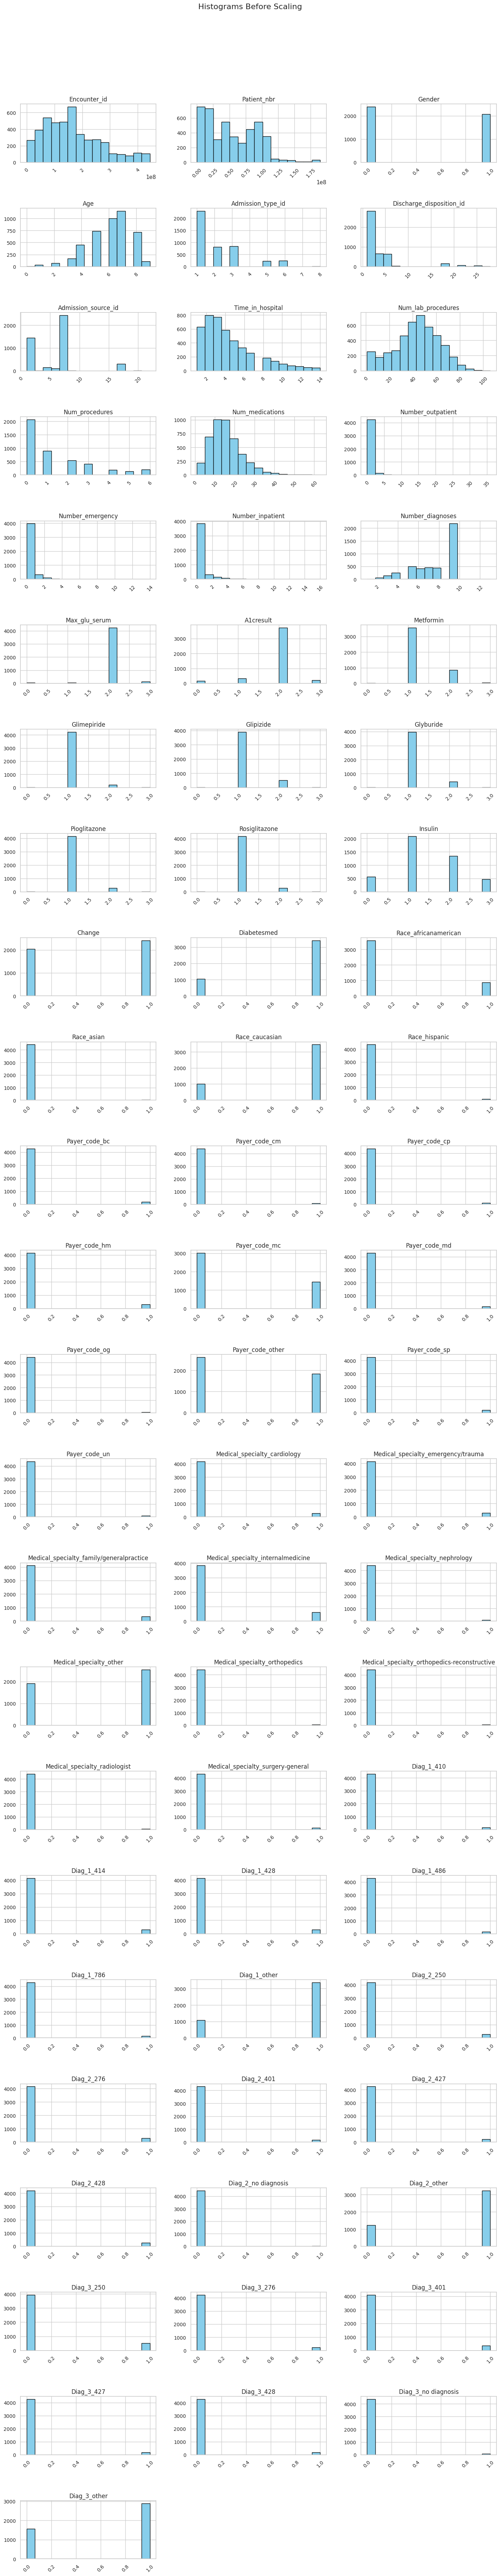

AttributeError: 'int' object has no attribute 'capitalize'

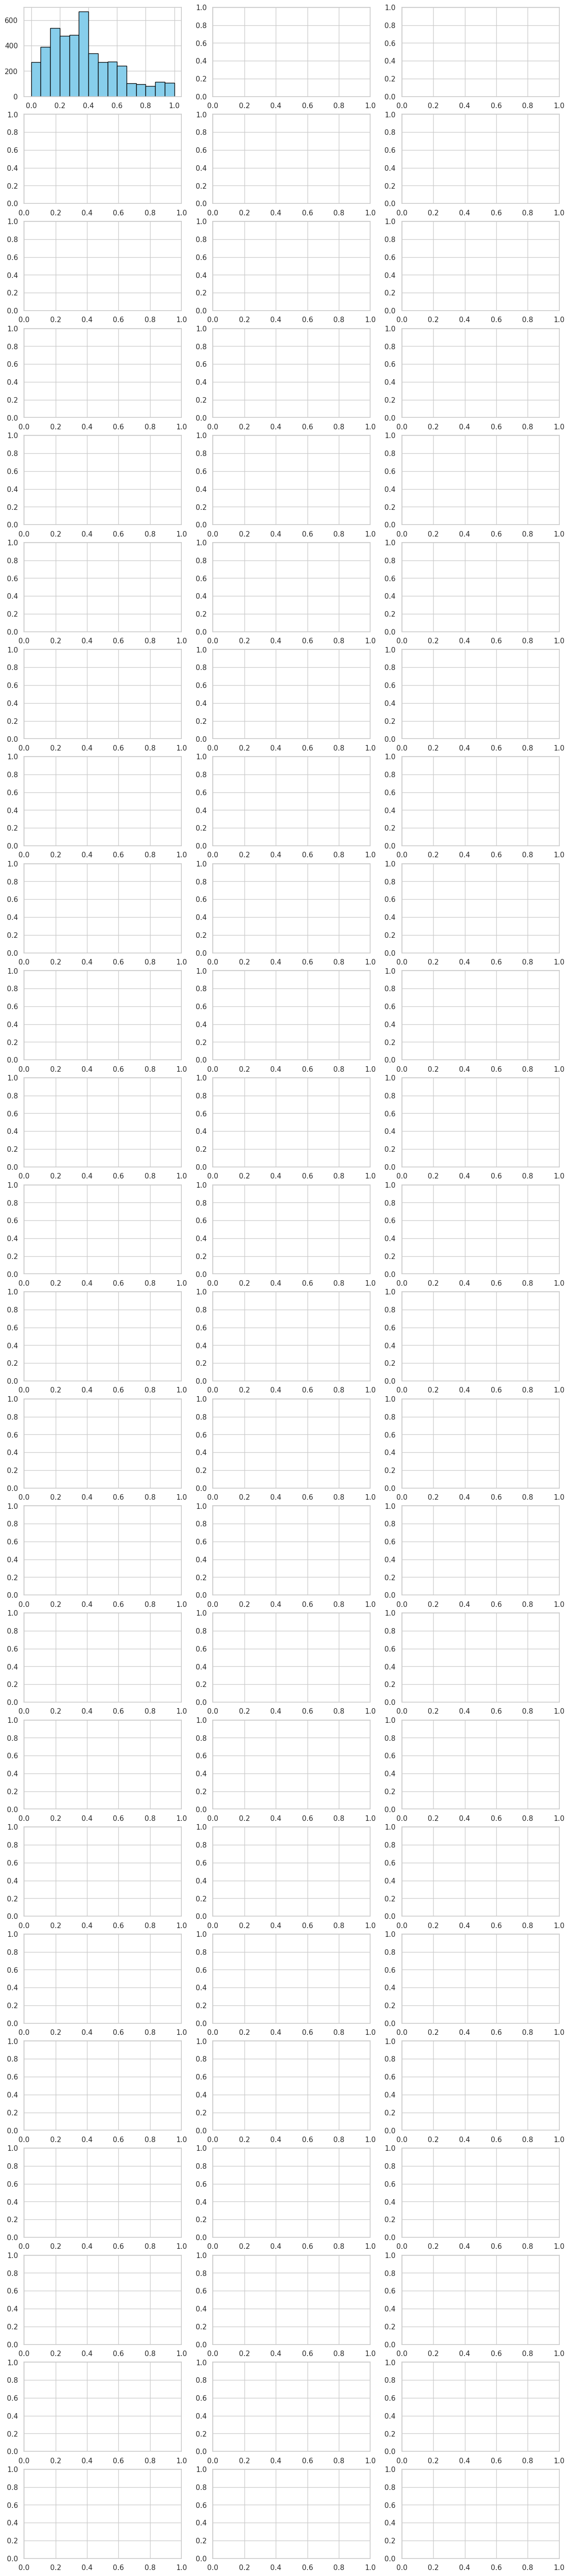

In [1528]:
# Histograms BEFORE and AFTER scaling

def plot_histograms(df, title, cols_per_row=3):
    num_features = len(df.columns)
    num_rows = int(np.ceil(num_features / cols_per_row))

    fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, num_rows * 3))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, col in enumerate(df.columns):
        ax = axes[i]
        df[col].hist(ax=ax, bins=15, color='skyblue', edgecolor='black')
        ax.set_title(col.capitalize(), fontsize=12)
        ax.tick_params(axis='x', labelrotation=45, labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

    # Remove any extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout(pad=3.0)
    plt.show()

# Plotting
plot_histograms(df_before_scaling, 'Histograms Before Scaling')
plot_histograms(df_after_scaling, 'Histograms After Scaling')



KeyError: 'ENCOUNTER_ID'

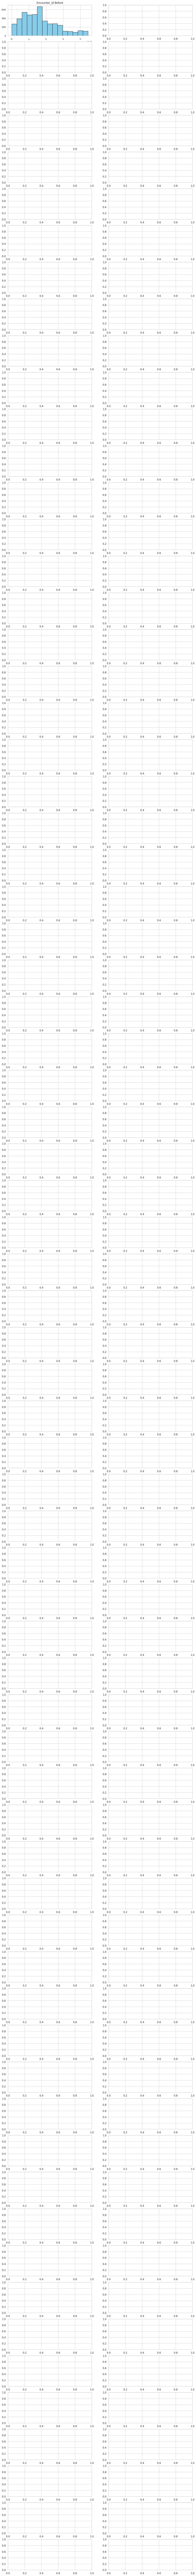

In [1529]:
def plot_before_after_histograms(df_before, df_after, feature_names, cols_per_row=2):
    num_features = len(feature_names)
    num_rows = num_features  # One row per feature

    fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, num_rows * 3))

    for i, col in enumerate(feature_names):
        # Plot "before" histogram
        axes[i, 0].hist(df_before[col], bins=15, color='skyblue', edgecolor='black')
        axes[i, 0].set_title(f'{col.capitalize()} Before', fontsize=12)
        axes[i, 0].tick_params(axis='x', labelrotation=45, labelsize=10)
        axes[i, 0].tick_params(axis='y', labelsize=10)

        # Plot "after" histogram
        axes[i, 1].hist(df_after[col], bins=15, color='lightgreen', edgecolor='black')
        axes[i, 1].set_title(f'{col.capitalize()} After', fontsize=12)
        axes[i, 1].tick_params(axis='x', labelrotation=45, labelsize=10)
        axes[i, 1].tick_params(axis='y', labelsize=10)

    plt.tight_layout(pad=3.0)
    plt.show()

# Feature names for histograms
feature_names = df_before_scaling.columns.tolist()

# Plotting
plot_before_after_histograms(df_before_scaling, df_after_scaling, feature_names)


##  III. Design and build a Machine Learning Pipeline (40%)

In [1101]:
gpu=True

# RESSOURCES


In [ ]:
# from mpl_toolkits.mplot3d import Axes3D


# def visualise_data(X, labels=None, column_names=None, set_labels=False):
#     """
#     Visualize the data with 2D or 3D scatter plot.

#     @param X: DataFrame containing the data to be plotted.
#     @param labels: Default is None, but if you have labels from clustering, you can pass them here.
#     @param column_names: List of column names of dataset X to be selected for plotting; List with two elements for a 2D plot, or three elements for a 3D plot.
#     @param set_labels: If True, set column names as labels for the axes.
#     """
#     assert type(column_names) in [list, tuple], "column_names must be a list or a tuple"
#     assert len(column_names) in [
#         2,
#         3,
#     ], "You must provide two or three column names for 2D or 3D plot, respectively"

#     if len(column_names) == 2:  # 2D
#         if set_labels:
#             plt.xlabel(column_names[0])
#             plt.ylabel(column_names[1])

#         plt.scatter(X[column_names[0]], X[column_names[1]], c=labels)

#     elif len(column_names) == 3:  # 3D
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection="3d")

#         if set_labels:
#             ax.set_xlabel(column_names[0])
#             ax.set_ylabel(column_names[1])
#             ax.set_zlabel(column_names[2])

#         ax.scatter(X[column_names[0]], X[column_names[1]], X[column_names[2]], c=labels)

#     plt.tight_layout()
#     plt.show()


In [ ]:
# visualise_data(df[cat_cols], labels=df["READMITTED"], column_names=["INSULIN", "METFORMIN"])


In [ ]:
# # CORRELATION MATRIX
# plt.figure(figsize=(12, 10))
# sns.heatmap(df[num_cols].corr(), annot=True, cmap="magma", fmt=".2f")
# num_cols.remove("READMITTED")


In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier()

# # Split the data into features (X) and target (y)
# X = df[num_cols].drop("READMITTED", axis=1)
# y = df["READMITTED"]

# # Fit the random forest classifier to the data
# rf.fit(X, y)

# # Get the feature importances into a df
# feature_importances = rf.feature_importances_
# importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
# importance_df = importance_df.sort_values("Importance", ascending=False)

# # Plotting feature importances using a bar plot
# plt.figure(figsize=(10, 6))
# sns.barplot(data=importance_df, x="Importance", y="Feature", palette="YlGnBu")
# plt.title("Feature Importance")
# plt.show()
